# Toy Distributions for L2HMC

## Setup

### Imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

# Global imports
import sys
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import horovod.tensorflow as hvd
hvd.init()

from collections import namedtuple

# append parent directory to `sys.path`
# to load from modules in `../l2hmc-qcd/`
module_path = os.path.join('..')
if module_path not in sys.path:
    sys.path.append(module_path)

# Local imports
from utils.attr_dict import AttrDict
from utils.training_utils import train_dynamics
from dynamics.config import DynamicsConfig
from dynamics.base_dynamics import BaseDynamics
from dynamics.generic_dynamics import GenericDynamics
from network.config import LearningRateConfig
from config import (State, NetWeights, MonteCarloStates,
                    BASE_DIR, BIN_DIR, TF_FLOAT)

from utils.distributions import (plot_samples2D, contour_potential,
                                 two_moons_potential, sin_potential,
                                 sin_potential1, sin_potential2)

#sns.set_palette('bright')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of devices: 1


In [2]:
sns.set(context="notebook")
plt.style.use("/Users/saforem2/.config/matplotlib/stylelib/molokai.mplstyle")

## Helper functions

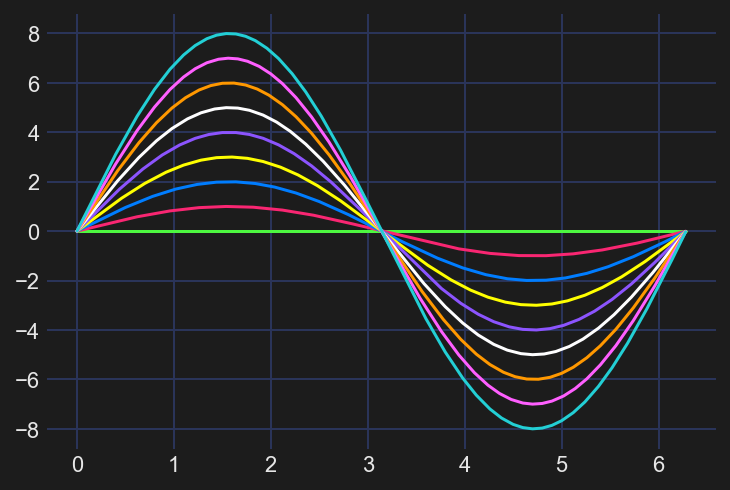

In [3]:
x = np.arange(0, 2*np.pi, 0.02)
y_arr = [i * np.sin(x) for i in range(9)]
fig, ax = plt.subplots()
for y in y_arr:
    _ = ax.plot(x, y)

In [4]:
from network.config import NetworkConfig, LearningRateConfig

def identity(x):
    return x

def get_dynamics(flags):
    """Return `GenericDynamics` object, initialized from `flags`."""
    config = DynamicsConfig(eps=flags.eps,
                            num_steps=flags.num_steps,
                            aux_weight=flags.aux_weight,
                            loss_scale=0.1,
                            hmc=flags.hmc,
                            eps_fixed=flags.eps_fixed,
                            model_type=flags.model_type)


    net_config = NetworkConfig(units=flags.units,
                               dropout_prob=flags.dropout_prob,
                               name=flags.network_name,
                               activation_fn=flags.activation_fn)

    lr_config = LearningRateConfig(flags.lr_init,
                                   decay_steps=flags.decay_steps,
                                   decay_rate=flags.decay_rate,
                                   warmup_steps=flags.warmup_steps)

    dynamics = GenericDynamics(params=flags,
                               config=config,
                               lr_config=lr_config,
                               normalizer=identity,
                               network_config=net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
    
    return dynamics

In [5]:
import utils.file_io as io
from utils.distributions import contour_potential

#%matplotlib inline

def plot_chains(dirs, x_arr, potential_fn, label=None, cmap='rainbow'):
    figs_dir = os.path.join(dirs.log_dir, 'figures')
    io.check_else_make_dir(figs_dir)

    x_arr = tf.convert_to_tensor(x_arr).numpy()

    for chain in range(4):
        fig, ax = plt.subplots()
        xy = np.array((x_arr[1000:, chain, 0], x_arr[1000:, chain, 1]))
        #sns.kdeplot(*xy, ax=ax)
        #grid = xy.reshape(2, -1).T
        #Z = np.exp(-POTENTIAL_FN(grid))
        #_ = ax.contourf(xy[0], xy[1], Z.reshape(xy[0].shape, xy[1].shape), cmap='inferno')
        #xlim = np.abs(np.floor(np.min(xy[0]))) + 1
        #ylim = np.abs(np.floor(np.max(xy[1]))) + 1
        xlim = 5
        ylim = 5
        _ = contour_potential(POTENTIAL_FN, ax=ax, cmap=cmap, xlim=xlim, ylim=ylim)
        _ = ax.plot(*xy, alpha=0.3, mew=0.9, ls='', marker='+',
                    color='white', label='l2hmc samples')
        #_ = ax.legend(markerscale=5., loc='best')
        _ = ax.set_xlim((-xlim, xlim))
        _ = ax.set_ylim((-ylim, ylim))
        out_file = os.path.join(figs_dir, f'trained_samples_chain{chain}.png')
        print(f'Saving figure to: {out_file}')
        _ = plt.savefig(out_file, dpi=400, bbox_inches='tight')
        plt.show()

In [6]:
def plot_density_estimation(potential_fn, x_l2hmc, x_hmc,
                            title=None, cmap=None, num_plots=5):
    def _format_arr(x):
        x = np.array(x)
        n = x.shape[0]
        therm = 2 * n // 10  # Drop first 20% of samples (thermalization)
        return x[therm:]
    
    x_l2hmc = _format_arr(x_l2hmc)
    x_hmc = _format_arr(x_hmc)
    
    for idx in range(num_plots):
        fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
        _ = contour_potential(potential_fn, title=title, ax=axes[0], cmap=cmap)
        _ = sns.kdeplot(x_l2hmc[:, idx, 0], x_l2hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[1])
        _ = sns.kdeplot(x_hmc[:, idx, 0], x_hmc[:, idx, 1],
                        shade=True, cmap=cmap, ax=axes[2])
        _ = axes[1].set_title('L2HMC samples')
        _ = axes[2].set_title('HMC samples')
        plt.tight_layout()
        
    return fig, axes

### Plot examples of (toy) target distributions:

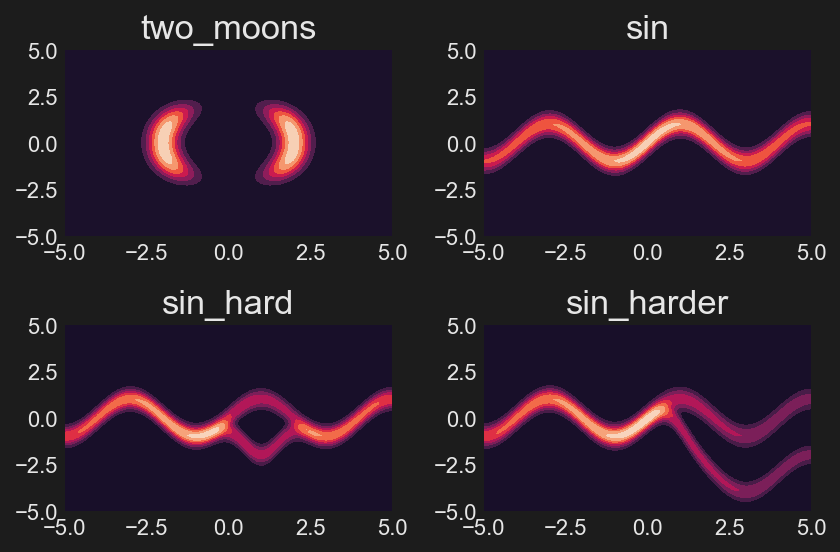

In [7]:
fig, axes = plt.subplots(nrows=2, ncols=2)
axes = axes.flatten()
names = ['two_moons', 'sin', 'sin_hard', 'sin_harder']
potentials = [two_moons_potential, sin_potential, sin_potential1, sin_potential2]
potentials_and_axes = zip(potentials, axes)
potentials_dict = {}
for idx, (p_fn, ax) in enumerate(zip(potentials, axes)):
    _ = contour_potential(p_fn, ax, title=f'{names[idx]}', cmap='rocket')
    ax.facecolor = '#1c1c1c'
    fig = plt.gcf()
    fig.facecolor = '#1c1c1c'
    potentials_dict[names[idx]] = p_fn
    

plt.grid(True)
plt.show()

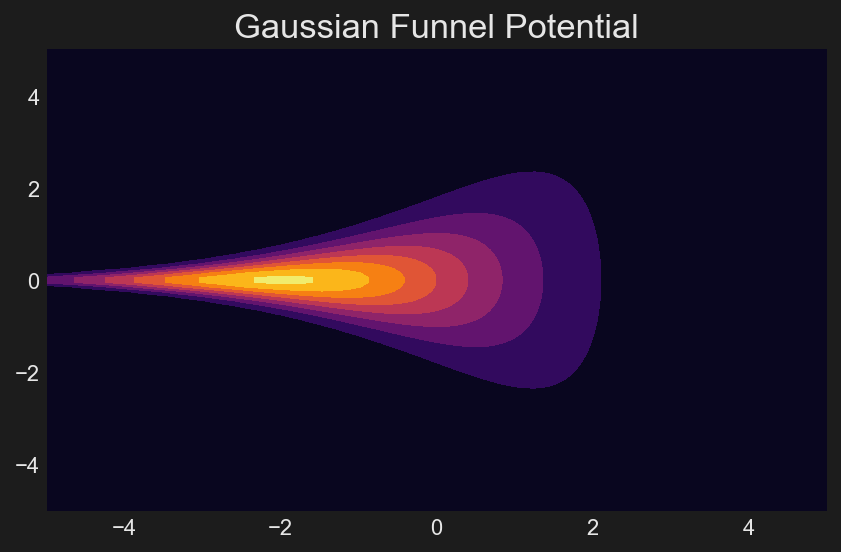

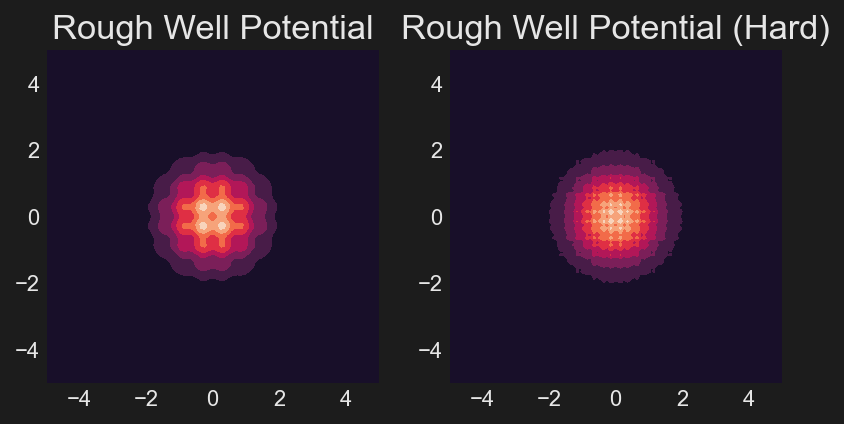

In [8]:
from utils.distributions import GaussianFunnel, RoughWell

funnel = GaussianFunnel()
funnel_potential = funnel.get_energy_function()
fig, ax = plt.subplots()
_ = contour_potential(funnel_potential, ax=ax, title=f'Gaussian Funnel Potential')
plt.show()

rough_well = RoughWell(dim=2, eps=0.1, easy=True)
rough_well_hard = RoughWell(dim=2, eps=0.1, easy=False)

rw_potential = rough_well.get_energy_function()
rwh_potential = rough_well_hard.get_energy_function()

fig, axes = plt.subplots(nrows=1, ncols=2)
axes = axes.flatten()
ax0 = contour_potential(rw_potential, ax=axes[0], cmap='rocket', title='Rough Well Potential')
ax1 = contour_potential(rwh_potential, ax=axes[1], cmap='rocket', title='Rough Well Potential (Hard)')
ax0.set_aspect('equal')
ax1.set_aspect('equal')

potentials_dict.update({
    'funnel': funnel_potential,
    'rough_well': rw_potential,
    'rough_well_hard': rwh_potential,
})

In [9]:
from utils.distributions import GaussianMixtureModel, meshgrid
import tensorflow_probability as tfp

tfd = tfp.distributions
floatx = tf.keras.backend.floatx()


def make_gmm_model(mus, sigmas, pis):
    def to_tensors(x):
        return (tf.convert_to_tensor(i, dtype=floatx) for i in x)
    
    mus, sigmas, pis = to_tensors([mus, sigmas, pis])
    gmm = tfd.Mixture(
        cat=tfd.Categorical(probs=pis),
        components=[
            tfd.MultivariateNormalDiag(loc=m, scale_diag=s)
            for m, s in zip(mus, sigmas)
        ]
    )
    
    def potential(x):
        return -1. * gmm.log_prob(x)
    
    #model = GaussianMixtureModel(mus, sigmas, pis) 
    #potential_fn = lambda x: -1. * model.dist.log_prob(x)
    #return model, potential_fn
    
    return gmm, potential

Gaussian mixture models:

 1. 2-Component mixture: 
 $$x \sim p(x) \equiv \frac{1}{2}\mathcal{N}(\vec{x}_{0}, \Sigma_{0}) + \frac{1}{2}\mathcal{N}(\vec{x}_{1}, \Sigma_{1})$$
 2. $4\times 4$ Lattice of Gaussians: 
 $$x\sim\mathcal{N}(\vec{x}_{ij}, \Sigma_{ij})$$

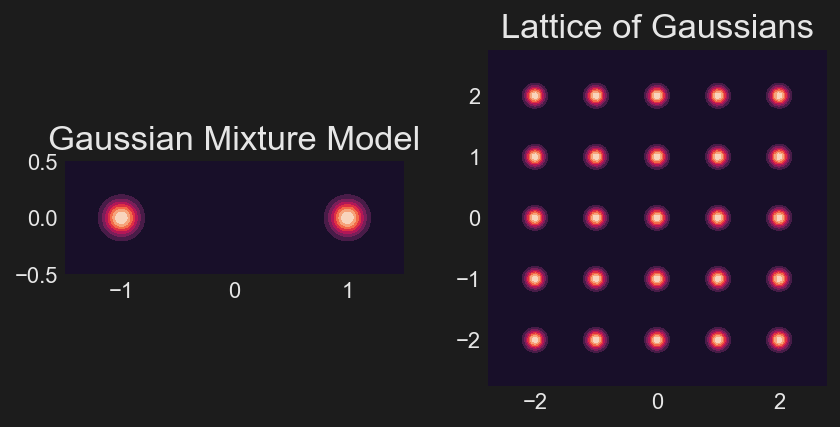

In [10]:
# ==== Mixture of two components
mus = [(-1., 0), (1., 0)]
sigmas = [0.1 * np.ones(2) for _ in range(len(mus))]
pis = len(mus) * [1. / len(mus)]

gmm, gmm_potential = make_gmm_model(mus, sigmas, pis)


# ==== 4x4 Lattice of Gaussians
# xy locations of each component
mus = [(-2, -2), (-2, -1), (-2, +0), (-2, +1), (-2, +2),
       (-1, -2), (-1, -1), (-1, +0), (-1, +1), (-1, +2),
       (+0, -2), (+0, -1), (+0, +0), (+0, +1), (+0, +2),
       (+1, -2), (+1, -1), (+1, +0), (+1, +1), (+1, +2),
       (+2, -2), (+2, -1), (+2, +0), (+2, +1), (+2, +2)]

sigmas = [0.1 * np.ones(2) for _ in range(len(mus))]
pis = len(mus) * [1. / len(mus)]

gmm_latt, gmm_latt_potential = make_gmm_model(mus, sigmas, pis)


potentials_dict.update({
    'gmm': gmm_potential,
    'lattice_of_gaussians': gmm_latt_potential,
})


# ==== Plot contours of both potentials
fig, axes = plt.subplots(ncols=2)
axes = axes.flatten()

ax0 = contour_potential(gmm_potential, ax=axes[0],
                        cmap='rocket', xlim=1.5, ylim=0.5,
                        title='Gaussian Mixture Model')

ax1 = contour_potential(gmm_latt_potential, ax=axes[1],
                        cmap='rocket', xlim=2.7777775, ylim=2.75,
                        title='Lattice of Gaussians')
    
_ = [ax.set_aspect('equal') for ax in axes]

## Define parameters of the model and target distribution

In [11]:
import utils.file_io as io
import datetime

LOGS_DIR = os.path.abspath('../../logs')

# DEFINE THE TARGET DISTRIBUTION
MODEL_TYPE = 'two_moons'
POTENTIAL_FN = potentials_dict[MODEL_TYPE]

now = datetime.datetime.now()
date_str = now.strftime('%Y-%m-%d')
timestamp = now.strftime('%Y-%m-%d-%H%M%S')

log_dir = os.path.join(LOGS_DIR, f'{MODEL_TYPE}', date_str)
if os.path.isdir(log_dir):
    log_dir = os.path.join(log_dir, timestamp)
    
io.check_else_make_dir(log_dir)


flags = AttrDict({
    'profiler': False,
    'xdim': 2,
    'eps': 0.01,
    'aux_weight': 0.,
    'loss_scale': 0.1,
    'batch_size': 256,
    'num_steps': 10,
    'beta_init': 1.,
    'beta_final': 1.,
    'compile': True,
    'hmc_steps': 0,
    'lr_init': 1e-3,
    'train_steps': 5000,
    'clip_val': 1.0,
    'decay_rate': 0.96,
    'save_steps': 1000,
    'logging_steps': 100,
    'warmup_steps': 1000,
    'print_steps': 1,
    'units': [128, 128],
    'hmc': False,
    'eps_fixed': False,
    'model_type': MODEL_TYPE,
    'network_name': 'GenericNetwork',
    'dropout_prob': 0.,
    'activation_fn': tf.nn.relu,
    'log_dir': log_dir,
})

flags.decay_steps = flags.train_steps // 5
#flags.warmup_steps = flags.train_steps // 10

Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140


## Train

### Start by training HMC to find optimal step-size $\varepsilon$ and thermalized config $x_{\mathrm{therm}}$ 

In [21]:
from network.config import NetworkConfig, LearningRateConfig

flags.hmc_steps = 1000
flags.restore = False

x_shape = (flags.batch_size, flags.xdim)
x = tf.random.normal(shape=x_shape, dtype=TF_FLOAT)

net_config = NetworkConfig(units=flags.units,
                           dropout_prob=flags.dropout_prob,
                           name=flags.network_name,
                           activation_fn=flags.activation_fn)

lr_config = LearningRateConfig(flags.lr_init,
                     decay_steps=flags.decay_steps,
                     decay_rate=flags.decay_rate,
                     warmup_steps=flags.warmup_steps)

# TRAIN HMC
if flags.hmc_steps > 0:
    hmc_flags = AttrDict({k: v for k, v in flags.items()})
    #hmc_flags.train_steps = hmc_flags.pop('hmc_steps')
    hmc_flags.train_steps = 5000
    hmc_flags.logging_steps = hmc_flags.train_steps // 20
    hmc_flags.beta_final = hmc_flags.beta_init
    hmc_flags.compile = True
    hmc_config = DynamicsConfig(eps=hmc_flags.eps,
                                num_steps=hmc_flags.num_steps,
                                hmc=True,
                                eps_fixed=flags.eps_fixed,
                                model_type=MODEL_TYPE)
    hmc_dynamics = GenericDynamics(params=hmc_flags,
                                   config=hmc_config,
                                   lr_config=lr_config,
                                   network_config=net_config,
                                   potential_fn=POTENTIAL_FN,
                                   name=MODEL_TYPE)
    hmc_dirs = io.setup_directories(hmc_flags, 'training_hmc')
    x, train_data = train_dynamics(hmc_dynamics, hmc_flags, dirs=hmc_dirs, x=x)
    
    output_dir = os.path.join(hmc_dirs.train_dir, 'outputs')
    train_data.save_data(output_dir)
    #flags.eps = hmc_dynamics.eps.numpy()

2020-09-28 17:13:47,870:INFO:Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/training_hmc/FLAGS.z.
2020-09-28 17:13:48,526:INFO:************************************************************************************************************************
2020-09-28 17:14:04,121:INFO:Compiled `dynamics.train_step` using tf.function!
2020-09-28 17:14:04,122:INFO:************************************************************************************************************************


------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
     0/5000     0.01806      208.3         1        0.01002       0.01         0      
     1/5000     0.01691      298.6         1        0.01003       0.01         0      
     2/5000     0.01756      318.9         1        0.01005       0.01         0      
     3/5000     0.01652      194.8         1        0.01006       0.01         0      
     4/5000     0.01664      187.4         1        0.01007       0.01         0      
     5/5000     0.01811      334.1         1        0.01009       0.01         0      
     6/5000      0.017       247.7         1        0.01011       0.01         0      
     7/5000     0.01777      246.7         1        0.01012       0.01         0      
     8/5000     0.01684      230.1         1     

    94/5000     0.01767      161.7         1        0.01436       0.01         0      
    95/5000     0.01747      126.2         1        0.01443       0.01         0      
    96/5000     0.01693      105.2         1        0.01449       0.01         0      
    97/5000     0.01752      109.6         1        0.01456       0.01         0      
    98/5000     0.01775       122          1        0.01462       0.01         0      
    99/5000     0.01757       115          1        0.01469       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   100/5000     0.01771       141          1        0.01475       0.01         0      
   101/5000     0.01781      187.7         1        0.01482       0.01         0      
   102/5000     0.01709      98.09         1     

   188/5000      0.0185       60.3       0.9999     0.02048       0.01         0      
   189/5000     0.01893      77.16       0.9999     0.02055       0.01         0      
   190/5000     0.01849      59.71       0.9999     0.02061       0.01         0      
   191/5000     0.01873      86.07         1        0.02066       0.01         0      
   192/5000     0.01972      59.53         1        0.02072       0.01         0      
   193/5000      0.019       84.04         1        0.02078       0.01         0      
   194/5000      0.0182       90.6         1        0.02084       0.01         0      
   195/5000     0.01886      52.89         1         0.0209       0.01         0      
   196/5000     0.01816      80.39         1        0.02096       0.01         0      
   197/5000     0.01832      76.68       0.9999     0.02103       0.01         0      
   198/5000     0.01821      55.22       0.9997     0.02109       0.01         0      
   199/5000     0.01816      79.27         

   278/5000     0.01854      32.31       0.9996      0.0256       0.01         0      
   279/5000     0.01835      39.52       0.9999     0.02565       0.01         0      
   280/5000     0.01875      72.36       0.9998      0.0257       0.01         0      
   281/5000     0.01849      66.21       0.9999     0.02576       0.01         0      
   282/5000     0.01983      31.78       0.9999     0.02582       0.01         0      
   283/5000     0.01883      42.01       0.9999     0.02587       0.01         0      
   284/5000     0.01866      72.74       0.9998     0.02592       0.01         0      
   285/5000     0.01944      58.35       0.9999     0.02597       0.01         0      
   286/5000     0.01818      104.1       0.9999     0.02603       0.01         0      
   287/5000      0.0189      51.36       0.9999     0.02608       0.01         0      
   288/5000     0.01858      59.56       0.9999     0.02614       0.01         0      
   289/5000     0.01895      91.62       0.

   374/5000     0.02104      61.06       0.9998     0.03091       0.01         0      
   375/5000     0.01918      26.31       0.9999     0.03097       0.01         0      
   376/5000      0.0198      61.97       0.9997     0.03105       0.01         0      
   377/5000     0.02093      36.65       0.9999     0.03112       0.01         0      
   378/5000     0.02013      64.57       0.9996      0.0312       0.01         0      
   379/5000     0.02019      29.84       0.9999     0.03128       0.01         0      
   380/5000     0.01955      23.63       0.9998     0.03136       0.01         0      
   381/5000     0.01962      34.54       0.9998     0.03143       0.01         0      
   382/5000     0.02031      22.47       0.9998      0.0315       0.01         0      
   383/5000     0.01994      20.02       0.9998     0.03157       0.01         0      
   384/5000     0.01978      26.69       0.9999     0.03164       0.01         0      
   385/5000     0.01967      31.57       0.

   469/5000     0.02194      19.74       0.9995     0.03649       0.01         0      
   470/5000     0.02006      15.91       0.9997     0.03656       0.01         0      
   471/5000     0.02189       36.1       0.9995     0.03663       0.01         0      
   472/5000     0.02075      47.32       0.9995     0.03667       0.01         0      
   473/5000     0.02101      23.91       0.9997     0.03671       0.01         0      
   474/5000     0.02121      20.72       0.9998     0.03675       0.01         0      
   475/5000     0.02026      44.76       0.9994     0.03679       0.01         0      
   476/5000     0.02027      32.83       0.9997     0.03685       0.01         0      
   477/5000     0.02136      21.27       0.9996      0.0369       0.01         0      
   478/5000     0.01994      22.84       0.9999     0.03695       0.01         0      
   479/5000     0.02037      18.48       0.9998      0.037        0.01         0      
   480/5000     0.02146      26.72       0.

   559/5000     0.02279      37.02       0.9995     0.04102       0.01         0      
   560/5000     0.02257      21.02       0.9997     0.04111       0.01         0      
   561/5000     0.02216      10.97       0.9998     0.04118       0.01         0      
   562/5000     0.02194       10.9       0.9997     0.04125       0.01         0      
   563/5000     0.02156      21.02       0.9999     0.04132       0.01         0      
   564/5000     0.02103      22.44       0.9994     0.04138       0.01         0      
   565/5000     0.02062      26.59       0.9998     0.04145       0.01         0      
   566/5000     0.02138      22.91       0.9995     0.04152       0.01         0      
   567/5000     0.02229       26.8       0.9996      0.0416       0.01         0      
   568/5000     0.02206      24.68       0.9995     0.04166       0.01         0      
   569/5000     0.02174      34.19       0.9997     0.04174       0.01         0      
   570/5000     0.02298      18.04       0.

   657/5000     0.02256       19.3       0.9998     0.04681       0.01         0      
   658/5000     0.02182       37.6       0.9995     0.04686       0.01         0      
   659/5000     0.02179      9.696       0.9995      0.0469       0.01         0      
   660/5000     0.02161      17.98       0.9993     0.04695       0.01         0      
   661/5000     0.02145      9.973       0.9998     0.04699       0.01         0      
   662/5000     0.02165      29.21       0.9996     0.04704       0.01         0      
   663/5000     0.02204      14.77       0.9992      0.0471       0.01         0      
   664/5000     0.02279      21.87       0.9998     0.04716       0.01         0      
   665/5000     0.02306      50.54       0.9994     0.04723       0.01         0      
   666/5000     0.02411      21.98       0.9997     0.04731       0.01         0      
   667/5000     0.02285      12.19       0.9991     0.04737       0.01         0      
   668/5000     0.02463      8.105       0.

   749/5000     0.02308       48.1       0.9992     0.05099       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
   750/5000     0.02239      9.697       0.9994     0.05099       0.01         0      
   751/5000     0.02284      17.43       0.9994      0.051        0.01         0      
   752/5000     0.02277      9.388       0.9996     0.05101       0.01         0      
   753/5000     0.02341       10.1       0.9994     0.05102       0.01         0      
   754/5000     0.02273      29.31       0.9993      0.051        0.01         0      
   755/5000      0.0257      7.575       0.9992     0.05098       0.01         0      
   756/5000     0.02549      23.71       0.9992     0.05098       0.01         0      
   757/5000      0.0225      8.297       0.9993  

   841/5000     0.03063      12.03       0.9995     0.05408       0.01         0      
   842/5000     0.02512      12.83       0.9989      0.0541       0.01         0      
   843/5000     0.02546      8.069       0.9992     0.05413       0.01         0      
   844/5000      0.0272      20.45       0.999      0.05416       0.01         0      
   845/5000     0.02547      33.32       0.9987     0.05411       0.01         0      
   846/5000     0.02424      23.95       0.9993     0.05408       0.01         0      
   847/5000     0.02438      8.087       0.9992     0.05405       0.01         0      
   848/5000     0.02517      14.24       0.9993     0.05405       0.01         0      
   849/5000     0.02631      11.97       0.9997     0.05405       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
-----------------------------------------------

   938/5000     0.02299      16.44       0.9988     0.05788       0.01         0      
   939/5000     0.02366      8.154       0.9991      0.0579       0.01         0      
   940/5000     0.02298      46.08       0.9981     0.05793       0.01         0      
   941/5000     0.02339      16.55       0.9983     0.05796       0.01         0      
   942/5000      0.0232      10.25       0.9989      0.058        0.01         0      
   943/5000     0.02278      14.55       0.9987     0.05804       0.01         0      
   944/5000     0.02446      7.535       0.9992     0.05809       0.01         0      
   945/5000     0.02606      8.447       0.9996     0.05814       0.01         0      
   946/5000     0.03017      7.452       0.9992     0.05819       0.01         0      
   947/5000     0.02576       7.62       0.9995     0.05823       0.01         0      
   948/5000     0.02328      9.519       0.9988     0.05829       0.01         0      
   949/5000     0.02287      36.32       0.

  1029/5000     0.02432      24.75       0.9995     0.06108       0.01         0      
  1030/5000     0.02543      11.67       0.9986     0.06118       0.01         0      
  1031/5000      0.0314      9.275       0.9981     0.06127       0.01         0      
  1032/5000     0.03379      10.54       0.9992     0.06135       0.01         0      
  1033/5000     0.02936      5.586       0.9994     0.06142       0.01         0      
  1034/5000     0.03194      5.463       0.9993     0.06149       0.01         0      
  1035/5000     0.03421       7.09       0.9988     0.06155       0.01         0      
  1036/5000      0.0308      11.84       0.9993     0.06162       0.01         0      
  1037/5000     0.02937      27.85       0.9978     0.06171       0.01         0      
  1038/5000     0.03182      10.13       0.9986     0.06181       0.01         0      
  1039/5000     0.02834      6.448       0.999       0.0619       0.01         0      
  1040/5000     0.02784      6.544       0.

  1123/5000     0.02776      5.347       0.9984      0.066        0.01         0      
  1124/5000     0.02516      20.08       0.998      0.06609       0.01         0      
  1125/5000     0.02397      15.31       0.9987     0.06611       0.01         0      
  1126/5000     0.02636      3.345       0.9986     0.06614       0.01         0      
  1127/5000     0.02646      15.24       0.9984     0.06619       0.01         0      
  1128/5000     0.02455      6.743       0.9987     0.06624       0.01         0      
  1129/5000     0.02599      8.839       0.9987     0.06629       0.01         0      
  1130/5000     0.02652      4.393       0.9987     0.06634       0.01         0      
  1131/5000     0.02523      4.305       0.9986     0.06638       0.01         0      
  1132/5000     0.02483      4.078       0.9982     0.06642       0.01         0      
  1133/5000     0.02586      5.199       0.9986     0.06646       0.01         0      
  1134/5000     0.02736      6.109       0.

  1212/5000     0.02577      38.63       0.9975     0.06726       0.01         0      
  1213/5000     0.02558      12.46       0.9988     0.06735       0.01         0      
  1214/5000     0.02535      12.41       0.9985     0.06745       0.01         0      
  1215/5000     0.02568      4.707       0.9991     0.06753       0.01         0      
  1216/5000     0.02517      5.211       0.999      0.06761       0.01         0      
  1217/5000     0.02669      9.231       0.9978     0.06769       0.01         0      
  1218/5000     0.02747      5.398       0.9983     0.06775       0.01         0      
  1219/5000      0.0275      4.659       0.9984     0.06782       0.01         0      
  1220/5000     0.02631      6.964       0.998      0.06788       0.01         0      
  1221/5000     0.02753      6.282       0.9984     0.06794       0.01         0      
  1222/5000     0.02644      4.862       0.9987     0.06799       0.01         0      
  1223/5000     0.02589      4.622       0.

  1303/5000     0.02841      3.623       0.999      0.07223       0.01         0      
  1304/5000     0.02763      10.08       0.9982     0.07238       0.01         0      
  1305/5000     0.02693      3.638       0.9978     0.07251       0.01         0      
  1306/5000     0.02906       40.8       0.9984     0.07258       0.01         0      
  1307/5000     0.03046      8.454       0.9979     0.07264       0.01         0      
  1308/5000     0.02637      7.131       0.9977      0.0727       0.01         0      
  1309/5000     0.02585      7.263       0.9985     0.07276       0.01         0      
  1310/5000      0.0248      5.425       0.9985     0.07282       0.01         0      
  1311/5000     0.02404      4.062       0.9988     0.07288       0.01         0      
  1312/5000     0.02504      14.31       0.9975     0.07291       0.01         0      
  1313/5000     0.02431      16.71       0.9985     0.07298       0.01         0      
  1314/5000     0.02374      3.755       0.

  1402/5000      0.0255      3.952       0.999      0.08013       0.01         0      
  1403/5000     0.03028      5.851       0.9964     0.08029       0.01         0      
  1404/5000     0.03118      4.316       0.9973     0.08044       0.01         0      
  1405/5000     0.02922      9.013       0.9974     0.08055       0.01         0      
  1406/5000     0.02918      6.798       0.9983     0.08066       0.01         0      
  1407/5000     0.02857       4.2        0.9982     0.08075       0.01         0      
  1408/5000     0.03195      4.262       0.9979     0.08083       0.01         0      
  1409/5000     0.02889      33.02       0.9981     0.08111       0.01         0      
  1410/5000     0.02949       3.46       0.9987     0.08137       0.01         0      
  1411/5000     0.02913      5.638       0.998      0.08159       0.01         0      
  1412/5000      0.0291      4.427       0.9979      0.0818       0.01         0      
  1413/5000     0.02844      10.82       0.

  1495/5000     0.02568      6.634       0.9967     0.08877       0.01         0      
  1496/5000      0.0262      3.327       0.9972     0.08897       0.01         0      
  1497/5000     0.02644      0.6114      0.9966     0.08916       0.01         0      
  1498/5000      0.0259      49.01       0.9957     0.08931       0.01         0      
  1499/5000     0.02487      1.944       0.997      0.08944       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1500/5000     0.02474       1.64       0.9976     0.08957       0.01         0      
  1501/5000     0.02664      5.272       0.9981     0.08968       0.01         0      
  1502/5000     0.02546      3.844       0.997      0.08978       0.01         0      
  1503/5000     0.02501      1.628       0.9967  

  1588/5000     0.02653      1.168       0.9966     0.09666       0.01         0      
  1589/5000     0.02614      1.778       0.9967     0.09669       0.01         0      
  1590/5000     0.02828      23.75       0.9962     0.09697       0.01         0      
  1591/5000     0.02712      2.784       0.9947     0.09723       0.01         0      
  1592/5000     0.02757      2.566       0.997      0.09747       0.01         0      
  1593/5000     0.02735      1.175       0.9964     0.09769       0.01         0      
  1594/5000     0.02456      4.414       0.9969      0.0979       0.01         0      
  1595/5000     0.02501      2.613       0.9966     0.09809       0.01         0      
  1596/5000     0.02437       7.1        0.9955     0.09829       0.01         0      
  1597/5000     0.02424      0.9969      0.9966     0.09847       0.01         0      
  1598/5000     0.02479      1.106       0.9964     0.09863       0.01         0      
  1599/5000     0.02594      3.546       0.

  1683/5000     0.02681      0.6682      0.9958      0.1015       0.01         0      
  1684/5000     0.02547      2.461       0.9955      0.1015       0.01         0      
  1685/5000     0.02627      1.313       0.9968      0.1015       0.01         0      
  1686/5000     0.02483      0.4527      0.9971      0.1015       0.01         0      
  1687/5000     0.02668      0.141       0.9944      0.1016       0.01         0      
  1688/5000     0.02509      8.969       0.9961      0.1017       0.01         0      
  1689/5000     0.02482      28.11       0.9965      0.1016       0.01         0      
  1690/5000     0.02469      2.797       0.9947      0.1016       0.01         0      
  1691/5000     0.02506     -0.1668      0.9953      0.1015       0.01         0      
  1692/5000     0.02616      3.255       0.9954      0.1015       0.01         0      
  1693/5000     0.02542      0.3686      0.9962      0.1015       0.01         0      
  1694/5000     0.02431       1.77       0.

  1775/5000     0.02626      3.711       0.9945      0.1042       0.01         0      
  1776/5000      0.0255      4.425       0.9966      0.1042       0.01         0      
  1777/5000     0.02651      1.576       0.9954      0.1043       0.01         0      
  1778/5000     0.02551      1.003       0.9952      0.1043       0.01         0      
  1779/5000     0.02697      2.766       0.9961      0.1044       0.01         0      
  1780/5000      0.0262       1.35       0.9971      0.1044       0.01         0      
  1781/5000      0.0248     -0.3865      0.996       0.1045       0.01         0      
  1782/5000     0.02566      1.031       0.994       0.1045       0.01         0      
  1783/5000     0.02734      1.256       0.9964      0.1046       0.01         0      
  1784/5000     0.02674      0.9327      0.9959      0.1046       0.01         0      
  1785/5000     0.02601      4.284       0.9943      0.1047       0.01         0      
  1786/5000     0.02738      0.6676      0.

  1868/5000     0.02748      1.196       0.9953      0.1065       0.01         0      
  1869/5000     0.02756       1.82       0.9951      0.1064       0.01         0      
  1870/5000     0.02891     -0.08127     0.9948      0.1064       0.01         0      
  1871/5000      0.0302      1.677       0.9946      0.1064       0.01         0      
  1872/5000     0.02975      1.511       0.9975      0.1064       0.01         0      
  1873/5000     0.02694      0.2274      0.9948      0.1064       0.01         0      
  1874/5000     0.02581      2.864       0.9956      0.1064       0.01         0      
  1875/5000     0.02511      20.61       0.9946      0.1063       0.01         0      
  1876/5000     0.02592      17.87       0.9965      0.1065       0.01         0      
  1877/5000     0.02676      10.35       0.998       0.1067       0.01         0      
  1878/5000     0.02622      8.712       0.9945      0.1068       0.01         0      
  1879/5000     0.02706      2.345       0.

  1962/5000     0.02862      2.205       0.996       0.1044       0.01         0      
  1963/5000     0.02863      1.006       0.9957      0.1043       0.01         0      
  1964/5000      0.0275      0.5426      0.9949      0.1042       0.01         0      
  1965/5000     0.02655      3.464       0.9952      0.1041       0.01         0      
  1966/5000     0.02692      5.093       0.9964      0.104        0.01         0      
  1967/5000     0.02756      4.357       0.9969      0.104        0.01         0      
  1968/5000     0.02661      0.6496      0.9951      0.1039       0.01         0      
  1969/5000     0.02664       1.09       0.9973      0.1039       0.01         0      
  1970/5000     0.02623      1.353       0.9972      0.1038       0.01         0      
  1971/5000     0.02632      0.673       0.9947      0.1038       0.01         0      
  1972/5000     0.02779      1.051       0.9968      0.1037       0.01         0      
  1973/5000     0.02616     -0.4248      0.

  2055/5000     0.03087      0.3736      0.9974      0.1101       0.01         0      
  2056/5000     0.03008      2.705       0.9972      0.1102       0.01         0      
  2057/5000      0.031       1.677       0.9958      0.1102       0.01         0      
  2058/5000     0.02625     0.03655      0.9949      0.1102       0.01         0      
  2059/5000     0.02572      0.6582      0.996       0.1102       0.01         0      
  2060/5000     0.02505      1.157       0.9933      0.1103       0.01         0      
  2061/5000     0.02859      0.0865      0.9959      0.1103       0.01         0      
  2062/5000     0.03015      1.577       0.9951      0.1103       0.01         0      
  2063/5000     0.02679      0.6812      0.9963      0.1103       0.01         0      
  2064/5000     0.02797     -0.6703      0.9953      0.1103       0.01         0      
  2065/5000      0.0303     0.05652      0.9944      0.1103       0.01         0      
  2066/5000     0.03129      0.151       0.

  2147/5000     0.02815      0.4517      0.9922      0.1105       0.01         0      
  2148/5000     0.02617     -0.2666      0.9941      0.1104       0.01         0      
  2149/5000     0.02688     -0.2409      0.9929      0.1104       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2150/5000     0.02958      0.4763      0.9957      0.1103       0.01         0      
  2151/5000     0.02586      2.655       0.9952      0.1102       0.01         0      
  2152/5000     0.02597     -0.6776      0.9949      0.1102       0.01         0      
  2153/5000      0.0256      0.2335      0.9957      0.1101       0.01         0      
  2154/5000     0.02825      1.889       0.9963      0.1101       0.01         0      
  2155/5000     0.02852      2.034       0.9944  

  2237/5000     0.02709      1.443       0.996       0.1038       0.01         0      
  2238/5000     0.02574      0.6732      0.9955      0.1038       0.01         0      
  2239/5000     0.03202      10.89       0.9952      0.1038       0.01         0      
  2240/5000     0.03181      0.4885      0.9977      0.1038       0.01         0      
  2241/5000     0.03056      13.93       0.9957      0.1038       0.01         0      
  2242/5000     0.02739      1.285       0.9969      0.1038       0.01         0      
  2243/5000     0.02664     -0.4683      0.9956      0.1038       0.01         0      
  2244/5000     0.03334     0.05919      0.9951      0.1037       0.01         0      
  2245/5000     0.03626      5.796       0.9961      0.1037       0.01         0      
  2246/5000     0.03225      5.373       0.9948      0.1036       0.01         0      
  2247/5000     0.03489      35.03       0.9952      0.1038       0.01         0      
  2248/5000     0.03294      0.9154      0.

  2326/5000     0.02752      2.339       0.9965      0.1076       0.01         0      
  2327/5000     0.02787      0.5855      0.9947      0.1077       0.01         0      
  2328/5000     0.02903      7.822       0.9934      0.1077       0.01         0      
  2329/5000     0.02904      2.367       0.995       0.1077       0.01         0      
  2330/5000     0.02731      4.207       0.9966      0.1078       0.01         0      
  2331/5000     0.02615      2.956       0.9955      0.1078       0.01         0      
  2332/5000     0.02557      5.313       0.9948      0.1078       0.01         0      
  2333/5000     0.02905     -0.3364      0.9945      0.1078       0.01         0      
  2334/5000     0.02628      3.388       0.9959      0.1079       0.01         0      
  2335/5000     0.02706      0.5504      0.9944      0.1079       0.01         0      
  2336/5000      0.0273     -0.04365     0.9961      0.1079       0.01         0      
  2337/5000     0.02774      2.675       0.

  2417/5000     0.03019       3.09       0.9964      0.1093       0.01         0      
  2418/5000     0.02813      0.5197      0.9946      0.1094       0.01         0      
  2419/5000      0.0282      1.948       0.9956      0.1094       0.01         0      
  2420/5000     0.02714      4.734       0.995       0.1095       0.01         0      
  2421/5000     0.02692      -0.61       0.9943      0.1095       0.01         0      
  2422/5000     0.02861      0.3338      0.9955      0.1096       0.01         0      
  2423/5000     0.02648      1.061       0.9959      0.1096       0.01         0      
  2424/5000     0.02653      1.559       0.994       0.1097       0.01         0      
  2425/5000     0.02698     -0.3877      0.9962      0.1097       0.01         0      
  2426/5000     0.02792      3.094       0.9957      0.1098       0.01         0      
  2427/5000     0.02655      1.254       0.9945      0.1098       0.01         0      
  2428/5000     0.02825      2.933       0.

  2508/5000     0.02759      0.4899      0.9946      0.1135       0.01         0      
  2509/5000     0.02719     -0.3211      0.9958      0.1136       0.01         0      
  2510/5000     0.02887      2.043       0.994       0.1137       0.01         0      
  2511/5000     0.03133     0.06975      0.9947      0.1138       0.01         0      
  2512/5000     0.02958      0.2835      0.9967      0.1139       0.01         0      
  2513/5000     0.02766     -0.6833      0.9951      0.114        0.01         0      
  2514/5000     0.02697      1.363       0.9961      0.1141       0.01         0      
  2515/5000     0.02736      0.2882      0.9946      0.1141       0.01         0      
  2516/5000     0.02663     -0.05322     0.9952      0.1142       0.01         0      
  2517/5000     0.02741      0.3867      0.9945      0.1143       0.01         0      
  2518/5000     0.03101      -1.155      0.9946      0.1143       0.01         0      
  2519/5000     0.02701     -0.5649      0.

  2605/5000     0.02738      -1.069      0.9933      0.1235       0.01         0      
  2606/5000     0.02963     -0.6739      0.9961      0.1236       0.01         0      
  2607/5000     0.02988     -0.6838      0.9928      0.1237       0.01         0      
  2608/5000     0.02732     -0.4909      0.9962      0.1237       0.01         0      
  2609/5000     0.02621      -1.697      0.9958      0.1238       0.01         0      
  2610/5000     0.02645     -0.6885      0.9953      0.1238       0.01         0      
  2611/5000     0.02773       1.65       0.9933      0.1239       0.01         0      
  2612/5000     0.02883      5.553       0.9919      0.1239       0.01         0      
  2613/5000     0.02695        8         0.9933      0.1238       0.01         0      
  2614/5000      0.0263     -0.7811      0.9948      0.1237       0.01         0      
  2615/5000     0.02647      2.904       0.9929      0.1236       0.01         0      
  2616/5000     0.02809      2.852       0.

  2703/5000     0.03205      -1.112      0.9935      0.1197       0.01         0      
  2704/5000     0.02772     -0.1713      0.9927      0.1197       0.01         0      
  2705/5000     0.02996      -0.196      0.9953      0.1197       0.01         0      
  2706/5000     0.02876     -0.9398      0.9947      0.1198       0.01         0      
  2707/5000     0.02948      0.5149      0.9953      0.1198       0.01         0      
  2708/5000     0.02774      0.4603      0.9928      0.1198       0.01         0      
  2709/5000     0.02725      3.765       0.9933      0.1199       0.01         0      
  2710/5000     0.02693     -0.05962     0.9955      0.1199       0.01         0      
  2711/5000     0.02845      0.3286      0.9924      0.1199       0.01         0      
  2712/5000     0.02712      10.83       0.9903      0.1198       0.01         0      
  2713/5000     0.02825       1.63       0.9946      0.1197       0.01         0      
  2714/5000     0.02933      1.019       0.

  2799/5000     0.02707     -0.4166      0.9953      0.1173       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  2800/5000     0.02591      2.859       0.9939      0.1171       0.01         0      
  2801/5000     0.03002        -1        0.9947      0.1171       0.01         0      
  2802/5000     0.02693     -0.1549      0.9935      0.117        0.01         0      
  2803/5000     0.02711      0.8656      0.995       0.1169       0.01         0      
  2804/5000     0.02594      0.1507      0.9954      0.1169       0.01         0      
  2805/5000     0.03178     -0.1824      0.9933      0.1168       0.01         0      
  2806/5000     0.02702     -0.6579      0.9946      0.1168       0.01         0      
  2807/5000     0.02581      0.6655      0.9942  

  2890/5000      0.031       0.4954      0.9964      0.1192       0.01         0      
  2891/5000     0.02963      0.4066      0.9948      0.1192       0.01         0      
  2892/5000     0.02709     0.04151      0.9946      0.1192       0.01         0      
  2893/5000     0.02709      6.349       0.9947      0.1193       0.01         0      
  2894/5000     0.02685     -0.2649      0.9927      0.1194       0.01         0      
  2895/5000     0.02619     -0.1502      0.9953      0.1195       0.01         0      
  2896/5000     0.02704     0.06301      0.9957      0.1196       0.01         0      
  2897/5000     0.02717     -0.8687      0.9946      0.1196       0.01         0      
  2898/5000     0.02613     -0.1717      0.9956      0.1197       0.01         0      
  2899/5000     0.02772     0.01568      0.9946      0.1198       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_pr

  2980/5000     0.02801      0.8223      0.9935      0.1185       0.01         0      
  2981/5000     0.02804     -0.1417      0.9947      0.1185       0.01         0      
  2982/5000     0.03479     -0.2679      0.9946      0.1186       0.01         0      
  2983/5000      0.0292    0.0002589     0.9939      0.1186       0.01         0      
  2984/5000     0.02869      -0.565      0.9942      0.1186       0.01         0      
  2985/5000     0.02857      0.1126      0.9935      0.1186       0.01         0      
  2986/5000     0.02707     -0.5937      0.9943      0.1187       0.01         0      
  2987/5000     0.03103      0.6293      0.9946      0.1187       0.01         0      
  2988/5000      0.0331     0.08237      0.9961      0.1187       0.01         0      
  2989/5000      0.0332     -0.6107      0.9929      0.1187       0.01         0      
  2990/5000     0.03065      0.8979      0.9938      0.1187       0.01         0      
  2991/5000     0.03829      0.4685      0.

  3068/5000     0.03106      1.662       0.9947      0.1185       0.01         0      
  3069/5000     0.02947     -0.8512      0.9953      0.1185       0.01         0      
  3070/5000     0.03045      -0.283      0.994       0.1186       0.01         0      
  3071/5000     0.02974     0.02976      0.9944      0.1186       0.01         0      
  3072/5000     0.02749     -0.3728      0.9946      0.1186       0.01         0      
  3073/5000     0.02853     -0.8935      0.9945      0.1186       0.01         0      
  3074/5000     0.02877      3.435       0.9962      0.1187       0.01         0      
  3075/5000     0.03114      7.789       0.9947      0.1188       0.01         0      
  3076/5000     0.03125      0.1342      0.9938      0.1189       0.01         0      
  3077/5000     0.03252     -0.6729      0.9943      0.1189       0.01         0      
  3078/5000     0.03163      1.905       0.9926      0.119        0.01         0      
  3079/5000     0.03086       1.45       0.

  3162/5000     0.03983     -0.3091      0.9946      0.1311       0.01         0      
  3163/5000     0.05809      1.508       0.9935      0.1312       0.01         0      
  3164/5000     0.06567      -1.383      0.9939      0.1313       0.01         0      
  3165/5000     0.05225      0.8259      0.9936      0.1313       0.01         0      
  3166/5000     0.05526     -0.3096      0.9929      0.1314       0.01         0      
  3167/5000     0.04344     -0.4986      0.9936      0.1315       0.01         0      
  3168/5000     0.05607      -1.841      0.9908      0.1315       0.01         0      
  3169/5000     0.04046      -1.281      0.9934      0.1316       0.01         0      
  3170/5000      0.0418     -0.09943     0.9927      0.1317       0.01         0      
  3171/5000     0.04273      8.681       0.9934      0.1318       0.01         0      
  3172/5000     0.03902      18.53       0.9952      0.1317       0.01         0      
  3173/5000     0.03793      -1.46       0.

  3254/5000     0.03481      -2.277      0.9928      0.1349       0.01         0      
  3255/5000     0.03447     -0.9655      0.9936      0.135        0.01         0      
  3256/5000     0.03702      0.521       0.9922      0.135        0.01         0      
  3257/5000     0.03472      -0.47       0.9932      0.1351       0.01         0      
  3258/5000     0.03416      -1.28       0.9918      0.1352       0.01         0      
  3259/5000     0.03241      -0.937      0.9927      0.1352       0.01         0      
  3260/5000     0.03237     -0.9024      0.9938      0.1353       0.01         0      
  3261/5000     0.02837     -0.3644      0.9944      0.1354       0.01         0      
  3262/5000     0.03325      -2.053      0.9915      0.1354       0.01         0      
  3263/5000     0.03143      -1.073      0.9943      0.1354       0.01         0      
  3264/5000     0.03118      -1.478      0.9945      0.1355       0.01         0      
  3265/5000     0.03321      1.296       0.

  3349/5000     0.03213     -0.3135      0.9916      0.1323       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  3350/5000     0.03013      -1.169      0.9936      0.1322       0.01         0      
  3351/5000      0.0346      -1.103      0.9932      0.1321       0.01         0      
  3352/5000     0.03441      -1.54       0.9953      0.132        0.01         0      
  3353/5000     0.03275      -1.734      0.9893      0.132        0.01         0      
  3354/5000     0.03288      2.055       0.9954      0.1319       0.01         0      
  3355/5000     0.03472      -1.039      0.9932      0.1318       0.01         0      
  3356/5000     0.03203      0.5802      0.9927      0.1318       0.01         0      
  3357/5000     0.03349      -0.41       0.9917  

  3439/5000     0.03531      -1.496      0.9907      0.1333       0.01         0      
  3440/5000     0.03252      1.225       0.9913      0.1333       0.01         0      
  3441/5000     0.03356      -0.782      0.9913      0.1333       0.01         0      
  3442/5000     0.03298     -0.07381     0.9893      0.1333       0.01         0      
  3443/5000     0.03688     -0.8737      0.9929      0.1334       0.01         0      
  3444/5000     0.03138      1.096       0.9948      0.1334       0.01         0      
  3445/5000      0.0345     -0.8264      0.9907      0.1334       0.01         0      
  3446/5000     0.03196      -1.841      0.9912      0.1335       0.01         0      
  3447/5000     0.03728      -1.057      0.9954      0.1335       0.01         0      
  3448/5000     0.03212      -1.533      0.9912      0.1336       0.01         0      
  3449/5000      0.0338     -0.8638      0.9939      0.1336       0.01         0      
-------------------------------------------

  3530/5000     0.03341      -2.138      0.9889      0.1454       0.01         0      
  3531/5000     0.03244      -1.144      0.9939      0.1455       0.01         0      
  3532/5000     0.03059      -2.418      0.9933      0.1456       0.01         0      
  3533/5000     0.02862      -2.315      0.9887      0.1456       0.01         0      
  3534/5000      0.0304      -1.742      0.9933      0.1457       0.01         0      
  3535/5000     0.02766      -1.386      0.9902      0.1458       0.01         0      
  3536/5000     0.02859      -2.194      0.9927      0.1458       0.01         0      
  3537/5000     0.03149       -1.3       0.9916      0.1459       0.01         0      
  3538/5000     0.02905      2.395       0.9947      0.1459       0.01         0      
  3539/5000     0.02898      -1.981      0.9924      0.146        0.01         0      
  3540/5000     0.03107      0.9116      0.9916      0.146        0.01         0      
  3541/5000     0.02855      -1.845      0.

  3622/5000     0.02841     -0.8463      0.9903      0.1504       0.01         0      
  3623/5000     0.02875      -2.174      0.9884      0.1505       0.01         0      
  3624/5000      0.0288      -2.112      0.9906      0.1506       0.01         0      
  3625/5000     0.03279     -0.2054      0.9922      0.1507       0.01         0      
  3626/5000     0.03119      -1.526      0.992       0.1507       0.01         0      
  3627/5000     0.02788      -2.57       0.9904      0.1508       0.01         0      
  3628/5000     0.02738      -1.354      0.9909      0.1509       0.01         0      
  3629/5000     0.02825      -2.012      0.9903      0.1509       0.01         0      
  3630/5000     0.03015      -1.678      0.9903      0.151        0.01         0      
  3631/5000     0.02957      -2.475      0.9887      0.151        0.01         0      
  3632/5000     0.03026      -1.406      0.993       0.1511       0.01         0      
  3633/5000     0.02773      -2.633      0.

  3711/5000     0.02941      -2.456      0.9895      0.155        0.01         0      
  3712/5000     0.03099      -3.283      0.9871      0.1559       0.01         0      
  3713/5000     0.02934      -1.76       0.9924      0.1568       0.01         0      
  3714/5000     0.02879      -2.376      0.9939      0.1576       0.01         0      
  3715/5000     0.02837      0.9692      0.9912      0.1583       0.01         0      
  3716/5000     0.02771      -2.869      0.9902      0.1589       0.01         0      
  3717/5000     0.02728      -2.436      0.9914      0.1595       0.01         0      
  3718/5000     0.02774      -2.59       0.9906       0.16        0.01         0      
  3719/5000     0.02734      -1.095      0.9895      0.1605       0.01         0      
  3720/5000     0.02877      -2.807       0.99       0.1609       0.01         0      
  3721/5000     0.02954      -2.143      0.9906      0.1613       0.01         0      
  3722/5000     0.03097      -3.392      0.

  3805/5000     0.02776      -3.525      0.9874      0.1711       0.01         0      
  3806/5000     0.02852      1.322       0.9856      0.1711       0.01         0      
  3807/5000     0.03264      -3.11       0.9893      0.1712       0.01         0      
  3808/5000     0.02798      -2.126      0.9817      0.1713       0.01         0      
  3809/5000     0.02966      -3.402      0.9913      0.1713       0.01         0      
  3810/5000     0.02734      -3.712      0.9843      0.1713       0.01         0      
  3811/5000     0.02944      -3.237      0.9921      0.1714       0.01         0      
  3812/5000      0.0299      -3.077      0.984       0.1714       0.01         0      
  3813/5000     0.03023      -3.564      0.9873      0.1714       0.01         0      
  3814/5000     0.02764      -3.042      0.9863      0.1715       0.01         0      
  3815/5000     0.02973      13.22       0.9881      0.1712       0.01         0      
  3816/5000     0.02848      -2.99       0.

  3903/5000     0.02794      -3.606      0.9901      0.1635       0.01         0      
  3904/5000     0.02761      -3.042      0.9914      0.1635       0.01         0      
  3905/5000     0.02962      -1.95       0.9904      0.1636       0.01         0      
  3906/5000      0.029       -3.164      0.9903      0.1637       0.01         0      
  3907/5000     0.02909      -2.549      0.9885      0.1637       0.01         0      
  3908/5000     0.02902      -3.507      0.9897      0.1638       0.01         0      
  3909/5000     0.02813      -3.457      0.9913      0.1638       0.01         0      
  3910/5000     0.02808      -2.282      0.9889      0.1639       0.01         0      
  3911/5000     0.02704       -3.5       0.9882      0.1639       0.01         0      
  3912/5000     0.02945     -0.1595      0.9882      0.164        0.01         0      
  3913/5000     0.02819      -3.443      0.9872      0.164        0.01         0      
  3914/5000     0.02781      -3.152      0.

  4000/5000     0.02968      -2.569      0.9901      0.1726       0.01         0      
  4001/5000     0.03477      -2.65       0.9886      0.1726       0.01         0      
  4002/5000     0.02821      -3.518      0.9884      0.1726       0.01         0      
  4003/5000     0.02863     -0.8627      0.9854      0.1725       0.01         0      
  4004/5000     0.03356      -3.656      0.9879      0.1725       0.01         0      
  4005/5000     0.02807      -3.413      0.9891      0.1724       0.01         0      
  4006/5000     0.02817      -3.729      0.9859      0.1724       0.01         0      
  4007/5000     0.03051       13.5       0.9869      0.1717       0.01         0      
  4008/5000     0.03218      -2.028      0.9866      0.1712       0.01         0      
  4009/5000     0.03209      -3.748      0.9853      0.1707       0.01         0      
  4010/5000     0.02854      -3.581      0.9882      0.1702       0.01         0      
  4011/5000     0.03157      -3.299      0.

  4094/5000     0.02796      -2.844      0.9912      0.1658       0.01         0      
  4095/5000     0.02811      -3.416      0.9891      0.1658       0.01         0      
  4096/5000     0.03362      -3.391      0.9909      0.1659       0.01         0      
  4097/5000      0.0311      -3.264      0.9909      0.1659       0.01         0      
  4098/5000     0.02764      -3.433      0.9867      0.166        0.01         0      
  4099/5000     0.02893      -3.086      0.9898      0.166        0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4100/5000     0.02967      -2.871      0.9902      0.166        0.01         0      
  4101/5000      0.0296      -2.967      0.988       0.1661       0.01         0      
  4102/5000     0.03012      -2.602      0.9913  

  4184/5000     0.02969      -3.224      0.9867      0.1672       0.01         0      
  4185/5000     0.02961      -3.577      0.9867      0.1672       0.01         0      
  4186/5000     0.02861      -2.247      0.9887      0.1672       0.01         0      
  4187/5000     0.03053      -2.62       0.9905      0.1673       0.01         0      
  4188/5000     0.03222      -2.88       0.9873      0.1673       0.01         0      
  4189/5000      0.0333      -3.479      0.9894      0.1673       0.01         0      
  4190/5000      0.0321      -2.992      0.9895      0.1673       0.01         0      
  4191/5000     0.03592      -3.877      0.9916      0.1673       0.01         0      
  4192/5000     0.03619      0.1452      0.9857      0.1674       0.01         0      
  4193/5000     0.03217      -3.398      0.9922      0.1675       0.01         0      
  4194/5000     0.03271      3.414       0.9917      0.1677       0.01         0      
  4195/5000     0.03485      8.113       0.

  4273/5000      0.0334      -1.072      0.9872      0.1699       0.01         0      
  4274/5000     0.03281      -1.071      0.9884      0.1699       0.01         0      
  4275/5000     0.03066      -2.588      0.987        0.17        0.01         0      
  4276/5000     0.03218      -1.778      0.9916       0.17        0.01         0      
  4277/5000     0.03447      -2.699      0.987        0.17        0.01         0      
  4278/5000     0.03137      -1.379      0.9907      0.1701       0.01         0      
  4279/5000     0.03408      -3.709      0.9881      0.1701       0.01         0      
  4280/5000     0.03779      -4.05       0.9899      0.1701       0.01         0      
  4281/5000     0.03483      -3.529      0.9901      0.1702       0.01         0      
  4282/5000     0.03178      -2.345      0.9897      0.1702       0.01         0      
  4283/5000     0.03045      -3.895      0.9872      0.1702       0.01         0      
  4284/5000     0.03021      -3.456      0.

  4363/5000     0.03058      -3.315      0.9871      0.1679       0.01         0      
  4364/5000     0.02951      -1.843      0.9907      0.1679       0.01         0      
  4365/5000     0.03026      -2.876      0.9865      0.1679       0.01         0      
  4366/5000     0.03112      -3.429      0.9851      0.168        0.01         0      
  4367/5000     0.03156      -2.931       0.99       0.168        0.01         0      
  4368/5000     0.03248      -1.971      0.9902      0.168        0.01         0      
  4369/5000     0.02993      -3.14       0.984       0.1681       0.01         0      
  4370/5000     0.03202      -2.235      0.9905      0.1681       0.01         0      
  4371/5000     0.03033      -3.757      0.9916      0.1682       0.01         0      
  4372/5000     0.03068      -2.36       0.9886      0.1682       0.01         0      
  4373/5000     0.03202      -2.671      0.9876      0.1682       0.01         0      
  4374/5000     0.03589      -3.353      0.

  4457/5000     0.03685      -2.354      0.9875      0.1624       0.01         0      
  4458/5000     0.03923      -3.355      0.9885      0.1624       0.01         0      
  4459/5000     0.04019      -3.51       0.9931      0.1624       0.01         0      
  4460/5000      0.0387      -3.017      0.987       0.1624       0.01         0      
  4461/5000     0.04016      -2.966      0.9876      0.1623       0.01         0      
  4462/5000     0.03827      -2.461      0.9944      0.1623       0.01         0      
  4463/5000     0.03339      -2.909      0.991       0.1623       0.01         0      
  4464/5000     0.04019      -1.752      0.9879      0.1623       0.01         0      
  4465/5000     0.03916      -2.363      0.9904      0.1623       0.01         0      
  4466/5000     0.03966      -2.121      0.9896      0.1623       0.01         0      
  4467/5000     0.03741      -3.106      0.9874      0.1623       0.01         0      
  4468/5000     0.03552      -3.144      0.

  4553/5000     0.02869      -2.757      0.9914      0.1643       0.01         0      
  4554/5000     0.02804      -2.275      0.9856      0.1642       0.01         0      
  4555/5000     0.02896      -2.939      0.9859      0.1642       0.01         0      
  4556/5000      0.029       -3.042      0.9897      0.1642       0.01         0      
  4557/5000     0.02864      -4.043      0.9861      0.1642       0.01         0      
  4558/5000     0.02779      -3.165      0.9896      0.1642       0.01         0      
  4559/5000     0.02751      -2.823      0.9914      0.1642       0.01         0      
  4560/5000     0.02821      -2.31       0.9921      0.1642       0.01         0      
  4561/5000     0.02939      -3.65       0.9927      0.1642       0.01         0      
  4562/5000     0.03163      -3.066      0.9888      0.1642       0.01         0      
  4563/5000      0.0296      -3.33       0.9895      0.1642       0.01         0      
  4564/5000     0.02808      -2.363      0.

  4650/5000     0.03308     -0.7362      0.9873      0.1669       0.01         0      
  4651/5000     0.03019      -2.99       0.9898      0.167        0.01         0      
  4652/5000     0.03265      -2.592      0.9886      0.167        0.01         0      
  4653/5000     0.02763       -3.1       0.9859      0.1671       0.01         0      
  4654/5000     0.02922      -3.343      0.9845      0.1672       0.01         0      
  4655/5000     0.03115      -3.436      0.9894      0.1672       0.01         0      
  4656/5000     0.02794      -2.618      0.993       0.1673       0.01         0      
  4657/5000     0.02822      -3.339      0.9871      0.1673       0.01         0      
  4658/5000     0.03072      -2.889      0.9904      0.1674       0.01         0      
  4659/5000      0.0305      -3.338      0.9895      0.1674       0.01         0      
  4660/5000     0.02887      -2.928      0.988       0.1675       0.01         0      
  4661/5000     0.02865      -3.37       0.

  4743/5000      0.0272      -1.548      0.9934      0.1625       0.01         0      
  4744/5000      0.0284      -3.09       0.9921      0.1626       0.01         0      
  4745/5000     0.02925      -2.111      0.9906      0.1627       0.01         0      
  4746/5000     0.02992     -0.8408      0.9904      0.1628       0.01         0      
  4747/5000     0.03079      3.256       0.9897      0.1628       0.01         0      
  4748/5000     0.03318      -1.032      0.9908      0.1629       0.01         0      
  4749/5000     0.03696      -3.224      0.9884      0.1629       0.01         0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  4750/5000     0.03273      -3.041      0.9895      0.1629       0.01         0      
  4751/5000     0.03464      -3.044      0.9849  

  4838/5000     0.02937      -1.052      0.9892      0.1635       0.01         0      
  4839/5000      0.0337      -2.749      0.989       0.1635       0.01         0      
  4840/5000     0.03385      -2.387      0.9922      0.1635       0.01         0      
  4841/5000      0.0321      -2.437      0.9854      0.1635       0.01         0      
  4842/5000     0.03052      -2.995      0.9892      0.1635       0.01         0      
  4843/5000     0.03588      -2.727      0.9907      0.1635       0.01         0      
  4844/5000     0.03415      -3.166      0.9904      0.1635       0.01         0      
  4845/5000     0.03219      -3.857      0.9907      0.1635       0.01         0      
  4846/5000     0.03357     -0.6805      0.991       0.1635       0.01         0      
  4847/5000     0.03431      -3.541      0.9896      0.1635       0.01         0      
  4848/5000     0.03143      -2.315      0.9897      0.1635       0.01         0      
  4849/5000      0.0311      -2.835      0.

  4930/5000     0.02916      -2.852      0.989       0.1706       0.01         0      
  4931/5000     0.02835      -4.189      0.9888      0.1709       0.01         0      
  4932/5000     0.03635      -3.765      0.9875      0.1711       0.01         0      
  4933/5000     0.03282      -2.696      0.9868      0.1714       0.01         0      
  4934/5000     0.03029      -4.264      0.9889      0.1716       0.01         0      
  4935/5000     0.02807      -3.729       0.99       0.1718       0.01         0      
  4936/5000     0.02923      4.098       0.9883      0.172        0.01         0      
  4937/5000      0.0305      -3.079      0.9894      0.1722       0.01         0      
  4938/5000      0.0307      0.641       0.9867      0.1724       0.01         0      
  4939/5000     0.03067      -3.153      0.9862      0.1725       0.01         0      
  4940/5000      0.0287      -3.892      0.986       0.1727       0.01         0      
  4941/5000     0.02939      -3.436      0.

### Create `GenericDynamics` object

In [12]:
dynamics = get_dynamics(flags)

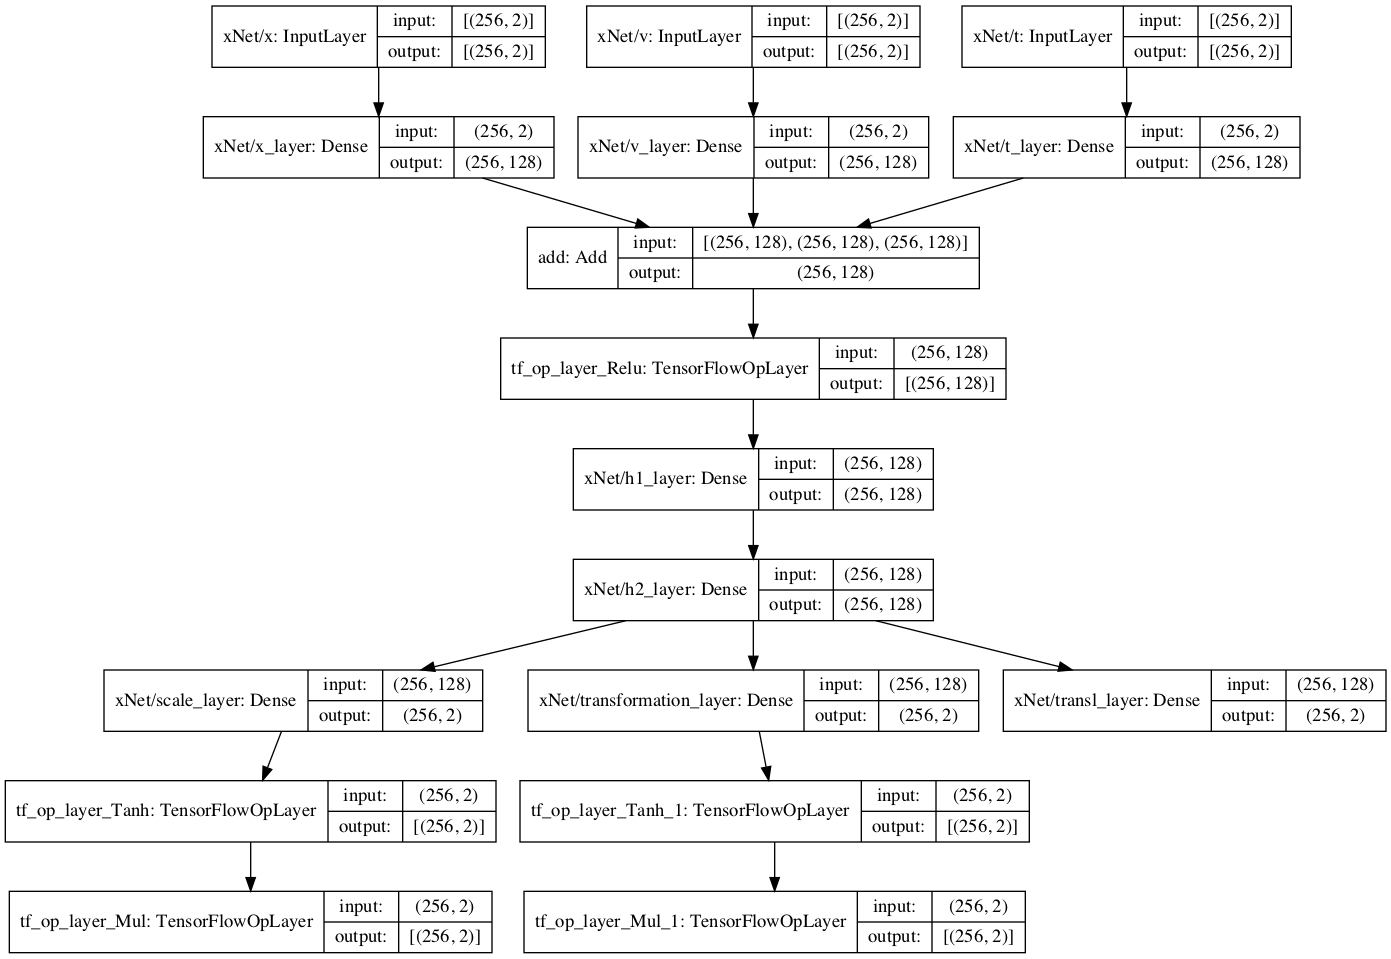

In [13]:
tf.keras.utils.plot_model(dynamics.xnet, show_shapes=True)

### Train L2HMC sampler using HMC sampler as starting point

In [14]:
flags.restore = False

In [15]:
dirs = io.setup_directories(flags)
x = tf.random.normal(dynamics.x_shape)
flags.train_steps = 2000
x, train_data = train_dynamics(dynamics, flags, dirs=dirs, x=x)

Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training
Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/train_data
Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/checkpoints
Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/summaries
Creating directory: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/dynamics_configs
Saving FLAGS to /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/FLAGS.z.
************************************************************************************************************************
Compiled `dynamics.train_step` using tf.function!
************************************************************************************************************************
-----------------------------------------------------------

    0/2000    0.04381      24.97       0.9679     0.01002        1        0.001043  
    1/2000    0.04415       26.3       0.9699     0.01003        1       -0.001964  
    2/2000    0.04165      21.65       0.9688     0.01005        1        0.004535  
    3/2000    0.03854       22.7       0.971      0.01006        1       0.0002307  
    4/2000    0.04157      21.22       0.9695     0.01007        1       -0.001051  
    5/2000    0.04097      23.51       0.9603     0.01009        1        0.003056  
    6/2000    0.03892      20.54       0.9708      0.0101        1        0.002127  
    7/2000    0.04087      22.46       0.9746     0.01012        1       -0.005774  
    8/2000    0.04345      18.32       0.9752     0.01014        1         0.0033   
    9/2000    0.04272      21.89       0.9728     0.01016        1       0.0007729  
   10/2000    0.04775      23.04       0.9736     0.01018        1        0.001834  
   11/2000    0.04503      29.25       0.9727      0.0102        

   96/2000    0.04754       6.07       0.9611     0.01421        1       -0.004213  
   97/2000     0.0446      16.33       0.9527     0.01427        1       0.0009099  
   98/2000    0.03895      7.888       0.9531     0.01434        1       -0.001696  
   99/2000    0.03839      14.89       0.9565      0.0144        1       0.0004831  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  100/2000    0.03951      8.771       0.9491     0.01446        1       -0.001529  
  101/2000    0.04007      8.991       0.9486     0.01452        1       -0.002658  
  102/2000    0.04365      9.407       0.948      0.01458        1       -0.000408  
  103/2000     0.0406      7.376       0.9416     0.01464        1        0.004783  
  104/2000    0.04131      13.88       0.9488      0.0147        

  191/2000    0.04188      0.5969      0.8267     0.01929        1       -0.006554  
  192/2000    0.04693      1.702       0.8374     0.01933        1        0.000381  
  193/2000    0.05143      1.533       0.8588     0.01938        1       -0.007243  
  194/2000    0.04419      0.9948      0.8507     0.01942        1       -0.0002166 
  195/2000     0.0469      0.2959      0.8257     0.01946        1        0.01085   
  196/2000    0.04556      2.025       0.8291      0.0195        1       -0.007759  
  197/2000     0.0527      1.793       0.8406     0.01955        1        -0.02047  
  198/2000    0.04833      0.6847      0.8437     0.01959        1        0.009606  
  199/2000    0.04534      1.266       0.834      0.01963        1        0.008579  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
-----------------------------------------------------------------

  285/2000    0.04271      0.8189      0.7424     0.02405        1       -0.003427  
  286/2000    0.04601      -1.02       0.7703      0.0241        1        0.008793  
  287/2000    0.03962      0.5969      0.7601     0.02414        1        -0.01772  
  288/2000    0.04221      3.218       0.7832      0.0242        1        -0.00932  
  289/2000    0.04505      -1.361      0.7763     0.02425        1       -0.005532  
  290/2000    0.04352     -0.8947      0.7725      0.0243        1        0.01653   
  291/2000    0.04709      -1.805      0.8027     0.02436        1       -0.004612  
  292/2000    0.04728     -0.9653      0.7879     0.02441        1        0.001416  
  293/2000    0.05798      -2.082      0.8064     0.02446        1        0.008234  
  294/2000    0.04851      -2.274      0.7922     0.02452        1        0.003417  
  295/2000    0.05253      -2.025      0.8009     0.02458        1        -0.01162  
  296/2000    0.05017      -1.155      0.7978     0.02464        

  379/2000    0.04951      -7.454      0.597      0.02956        1        -0.02251  
  380/2000    0.05021      -8.044      0.6125     0.02961        1        -0.00228  
  381/2000    0.04811      -8.956      0.6293     0.02965        1       -0.004359  
  382/2000    0.05391      -9.096      0.6162      0.0297        1       -0.004205  
  383/2000    0.05075      -10.26      0.6285     0.02976        1        -0.01753  
  384/2000    0.04824      -8.334      0.6141     0.02981        1        -0.01851  
  385/2000    0.04577      -7.999      0.6028     0.02986        1        -0.01049  
  386/2000    0.04683      -7.909      0.6275     0.02991        1        0.02206   
  387/2000    0.04213      -9.31       0.6371     0.02996        1        0.01553   
  388/2000    0.04549      -8.671      0.6345     0.03003        1       -0.004214  
  389/2000    0.04319      -9.859      0.6202      0.0301        1        -0.03141  
  390/2000    0.04158      -9.417      0.6056     0.03017        

  471/2000    0.04574      -13.66      0.5626     0.03554        1       -0.003315  
  472/2000     0.0464      -13.37      0.5401     0.03558        1        0.02052   
  473/2000    0.04857      -12.61      0.5081     0.03562        1        -0.02554  
  474/2000    0.04277      -12.73      0.5259     0.03565        1        -0.01339  
  475/2000    0.04296      -13.71      0.5444     0.03569        1        -0.01825  
  476/2000    0.04392      -13.14      0.5269     0.03573        1        -0.03257  
  477/2000    0.04674      -9.328      0.5128      0.0359        1        -0.02862  
  478/2000    0.04491      -13.96      0.5354     0.03604        1        0.007586  
  479/2000    0.04788      -16.58      0.5997     0.03619        1        0.02121   
  480/2000    0.04542      -13.52      0.5348     0.03632        1        0.003725  
  481/2000    0.04985      -12.8       0.5512     0.03644        1        0.007734  
  482/2000    0.04815      -8.879      0.5296     0.03655        

  565/2000    0.04278      -34.88      0.7247     0.04392        1        -0.0041   
  566/2000    0.04382      -33.33      0.7175     0.04392        1       0.0001442  
  567/2000    0.04171      -33.65      0.7157     0.04391        1       -0.0009023 
  568/2000    0.04179      -37.59      0.7351     0.04392        1        0.008245  
  569/2000    0.04096      -27.71      0.6933     0.04386        1       -0.001611  
  570/2000     0.0431      -30.72      0.6533      0.0438        1       -0.001991  
  571/2000    0.04539      -33.58      0.7205     0.04373        1       0.0008923  
  572/2000    0.04219      -35.32      0.6884     0.04369        1       -0.0001876 
  573/2000    0.04965      -30.69      0.685      0.04365        1        -0.01359  
  574/2000    0.04538      -36.54      0.7139     0.04362        1        0.01901   
  575/2000    0.04542      -36.65      0.7079     0.04361        1        0.007512  
  576/2000    0.05136      -32.58      0.6942     0.04369        

  659/2000    0.05059      -31.86      0.6873     0.04123        1       -0.002798  
  660/2000    0.06782      -31.49      0.6898     0.04118        1       -0.009935  
  661/2000     0.0547      -35.66      0.6836     0.04114        1        -0.0229   
  662/2000    0.06533      -32.28      0.6314     0.04109        1        0.01359   
  663/2000    0.05316      -36.05      0.6515     0.04105        1        -0.02462  
  664/2000    0.06112      -30.77      0.6482     0.04104        1        -0.0231   
  665/2000    0.04965      -30.78      0.618      0.04094        1        0.02883   
  666/2000    0.04346      -25.67      0.5945     0.04083        1        0.006009  
  667/2000    0.04586      -28.58      0.6306     0.04076        1        0.01599   
  668/2000    0.05118      -34.62      0.6546     0.04066        1        0.008774  
  669/2000    0.05202      -35.29      0.7227     0.04063        1        0.006064  
  670/2000    0.05018      -35.4       0.6846     0.04061        

  750/2000    0.04287      -47.55      0.8016     0.03489        1       -0.002362  
  751/2000    0.04633      -48.02      0.8503     0.03484        1        0.01146   
  752/2000    0.04238      -50.05      0.8413     0.03486        1       -0.002738  
  753/2000    0.04356      -48.13      0.8069     0.03488        1        -0.01503  
  754/2000    0.04281      -46.38      0.7933     0.03493        1         0.0127   
  755/2000    0.04339      -46.04      0.7904     0.03494        1       -0.002205  
  756/2000     0.0461      -48.41      0.828       0.0349        1       -0.004864  
  757/2000    0.04313      -49.77      0.8323     0.03486        1        0.01908   
  758/2000    0.04451      -52.48      0.8515     0.03477        1        -0.01919  
  759/2000    0.04286      -49.51      0.8325     0.03468        1        0.01128   
  760/2000    0.04787      -51.67      0.8242     0.03459        1       -0.007033  
  761/2000    0.04883      -50.28      0.8276     0.03457        

  846/2000    0.04623      -36.45      0.7122     0.03342        1        0.01549   
  847/2000    0.04697      -34.24      0.706      0.03327        1        -0.01001  
  848/2000    0.04491      -40.9       0.7386     0.03312        1       0.0004981  
  849/2000    0.04711      -40.56      0.7447     0.03294        1       -0.0003024 
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  850/2000    0.04793      -38.12      0.6963     0.03273        1        0.004996  
  851/2000    0.04985      -40.76      0.7059     0.03254        1       -0.007518  
  852/2000    0.05427      -43.1       0.7494     0.03236        1        0.00124   
  853/2000    0.04953      -39.59      0.7261     0.03224        1        -0.01273  
  854/2000    0.04646      -39.91      0.7344     0.03216        

  938/2000    0.04919      -51.27      0.8329     0.03289        1        0.006167  
  939/2000    0.05584      -51.15      0.8432     0.03274        1        -0.01731  
  940/2000     0.0596      -49.1       0.8597     0.03266        1        0.006756  
  941/2000    0.05621      -49.61      0.8234     0.03252        1        0.005089  
  942/2000    0.04996      -48.95      0.8401     0.03238        1       -0.0002364 
  943/2000    0.05298      -50.48      0.8444     0.03226        1       0.0006061  
  944/2000    0.05113      -48.63      0.8112     0.03215        1       -0.0002126 
  945/2000    0.04984      -49.05      0.8491     0.03211        1       -0.009131  
  946/2000    0.05029      -45.1        0.85      0.03234        1        0.01018   
  947/2000    0.05362      -49.33      0.8408      0.0325        1        0.01892   
  948/2000     0.0523      -48.63      0.835      0.03269        1        0.01108   
  949/2000    0.05857      -49.39      0.8235     0.03281        

 1029/2000    0.05283      -47.17      0.857      0.03035        1        0.01162   
 1030/2000    0.05393      -47.69      0.8546     0.03031        1        -0.01731  
 1031/2000    0.05186      -48.69      0.8534     0.03031        1        0.002672  
 1032/2000    0.05508      -49.03      0.8623     0.03031        1        -0.00745  
 1033/2000    0.06001      -49.43      0.8767     0.03038        1       -0.007965  
 1034/2000    0.05917      -46.97      0.8563     0.03048        1        0.01962   
 1035/2000    0.05575      -49.48      0.8605     0.03057        1        0.01259   
 1036/2000    0.06439      -50.06      0.8695      0.0306        1        -0.01787  
 1037/2000    0.05905      -51.78      0.8876      0.0306        1        0.02029   
 1038/2000    0.06679      -50.7       0.8622     0.03054        1        -0.01022  
 1039/2000    0.05797      -49.79      0.8782     0.03046        1        0.004922  
 1040/2000    0.06245      -49.58      0.8578     0.03043        

 1120/2000    0.07207      -41.49      0.7696      0.0286        1       -0.007619  
 1121/2000    0.06423      -38.86      0.7285     0.02811        1        0.03349   
 1122/2000    0.06031      -37.31      0.7178     0.02766        1        0.007415  
 1123/2000    0.05746      -35.96      0.6798     0.02725        1       -0.0005808 
 1124/2000    0.06478      -33.21      0.6675     0.02687        1        0.01473   
 1125/2000    0.06885      -31.92      0.6773     0.02655        1        0.01184   
 1126/2000    0.06713      -30.45      0.6404      0.0263        1        0.02122   
 1127/2000    0.05821      -30.18      0.6422     0.02638        1        0.001578  
 1128/2000    0.05892      -32.56      0.6848     0.02648        1        -0.00701  
 1129/2000      0.06       -35.78      0.6919     0.02659        1        0.008381  
 1130/2000    0.05893      -34.65      0.6809     0.02674        1       -0.006612  
 1131/2000    0.05978      -37.26      0.6892     0.02691        

 1211/2000     0.0734      -52.14      0.8686      0.0243        1        -0.04227  
 1212/2000    0.08209      -49.08      0.8239     0.02426        1        0.02249   
 1213/2000    0.06485      -51.13       0.85      0.02428        1        -0.02992  
 1214/2000    0.06405      -50.01      0.8348     0.02445        1        0.02812   
 1215/2000    0.06226      -49.58      0.8337     0.02467        1        -0.03134  
 1216/2000     0.0634      -51.76      0.8697     0.02493        1        0.01504   
 1217/2000    0.06059      -50.31      0.8364     0.02503        1        -0.00169  
 1218/2000    0.06912      -51.01      0.8456      0.0252        1       -0.0004349 
 1219/2000    0.06494      -49.5       0.8256     0.02517        1        0.00194   
 1220/2000    0.06303      -47.48      0.8406     0.02506        1       -0.007949  
 1221/2000    0.06099      -50.54      0.8749     0.02482        1         0.0242   
 1222/2000    0.06192      -48.91      0.8461      0.0245        

 1305/2000    0.05976      -42.7       0.7781     0.02443        1        0.01487   
 1306/2000    0.06143      -43.38      0.7831     0.02444        1        0.02604   
 1307/2000    0.05604      -43.64      0.7853      0.0244        1        0.004788  
 1308/2000    0.06348      -42.79      0.7632      0.0243        1        0.004379  
 1309/2000    0.05798      -41.2       0.7367      0.0241        1        -0.01682  
 1310/2000    0.05478      -43.29      0.7686     0.02388        1        0.01672   
 1311/2000    0.05924      -46.05      0.778      0.02369        1        0.002696  
 1312/2000     0.0664      -47.5       0.8115     0.02352        1        0.006629  
 1313/2000    0.06172      -44.47      0.7813     0.02348        1        0.01662   
 1314/2000    0.05958      -46.72      0.8181     0.02349        1       -0.003912  
 1315/2000    0.05606      -46.18      0.7913     0.02346        1        -0.01167  
 1316/2000    0.05966       -45        0.825      0.02406        

 1401/2000    0.06119      -54.36      0.8882      0.0233        1       -0.005444  
 1402/2000    0.06333      -52.53      0.8571     0.02323        1       -0.004018  
 1403/2000    0.06748      -53.08      0.8635     0.02325        1        -0.01465  
 1404/2000    0.06497      -53.47      0.8815     0.02331        1       0.0007858  
 1405/2000    0.06444      -53.29      0.8803     0.02348        1        0.01517   
 1406/2000    0.06766      -54.08      0.8803     0.02314        1       -0.006891  
 1407/2000    0.06196      -54.81      0.8882     0.02297        1        0.01982   
 1408/2000    0.07004      -52.27      0.8476     0.02294        1       -0.005046  
 1409/2000    0.06837      -53.35      0.8845     0.02302        1        0.004471  
 1410/2000     0.0659      -50.71      0.8486     0.02323        1       -0.006887  
 1411/2000    0.05376      -52.25      0.8453     0.02349        1        0.01173   
 1412/2000    0.06254      -53.22      0.8778      0.0238        

 1497/2000    0.06798      -45.48      0.8461     0.02423        1        0.006531  
 1498/2000    0.07254      -46.07      0.8369     0.02442        1        -0.01866  
 1499/2000    0.07215      -46.52      0.8524     0.02458        1        -0.02196  
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
 1500/2000    0.07319      -46.32      0.8423     0.02467        1       -0.002779  
 1501/2000    0.06705      -47.79      0.8475     0.02466        1        -0.01317  
 1502/2000    0.06224      -48.28      0.8684     0.02455        1       -0.005572  
 1503/2000    0.06062      -47.4       0.8703      0.0244        1        0.00361   
 1504/2000    0.05976      -45.37      0.8587     0.02435        1        -0.0124   
 1505/2000    0.06151      -48.83      0.8621     0.02424        

 1588/2000    0.05753      -53.68      0.8613     0.02359        1       -0.003948  
 1589/2000    0.05363      -52.39      0.8756      0.0234        1        0.002788  
 1590/2000    0.05394      -54.5       0.8842     0.02326        1       -0.002751  
 1591/2000    0.05373      -56.26      0.8863     0.02317        1        0.001688  
 1592/2000    0.05846      -55.27      0.8718     0.02316        1       -0.008743  
 1593/2000     0.0556      -54.45      0.8652     0.02343        1       -0.009057  
 1594/2000    0.05949      -53.29      0.8725     0.02372        1        -0.01027  
 1595/2000    0.05799      -52.54      0.8778     0.02395        1       0.0006353  
 1596/2000    0.05961      -53.36      0.8875     0.02396        1       -0.0004026 
 1597/2000    0.06081      -51.75      0.8694     0.02392        1        0.003645  
 1598/2000    0.06574      -52.49      0.8525     0.02383        1        0.002406  
 1599/2000    0.05831      -51.99      0.8669     0.02373        

 1681/2000    0.05333      -47.2       0.8833     0.02323        1       6.085e-05  
 1682/2000     0.0519      -47.24      0.8701     0.02339        1       -0.001079  
 1683/2000    0.05858      -49.3       0.8932     0.02351        1       -0.009624  
 1684/2000    0.05774      -47.25      0.8574     0.02357        1        0.009033  
 1685/2000    0.05248      -48.01      0.8889      0.0235        1        0.002179  
 1686/2000    0.05329      -48.51      0.8707     0.02334        1        0.01764   
 1687/2000    0.05845      -52.03      0.8927      0.0232        1        0.002912  
 1688/2000    0.05938       -51        0.8809     0.02308        1       -0.003821  
 1689/2000    0.05909      -47.91      0.8829     0.02226        1         0.0102   
 1690/2000    0.06165      -45.33      0.8725     0.02164        1       -0.0008635 
 1691/2000    0.05613      -37.82      0.7972     0.02149        1        0.002163  
 1692/2000    0.05282      -39.21      0.7739     0.02149        

 1773/2000    0.05317      -8.709      0.7345     0.01429        1        0.002157  
 1774/2000    0.05179      -10.8       0.7288     0.01465        1        0.006943  
 1775/2000    0.05376      -9.212      0.6941      0.015         1       -0.002365  
 1776/2000    0.05651      -8.477      0.6641     0.01534        1       -0.002905  
 1777/2000    0.05356      -10.47      0.6867     0.01565        1         0.0184   
 1778/2000    0.05374      -5.449      0.6869     0.01595        1        -0.02368  
 1779/2000    0.06182      -12.59      0.6802     0.01613        1        -0.00387  
 1780/2000    0.05753      -9.896      0.6727     0.01641        1        0.005963  
 1781/2000    0.06417      -11.88      0.6857     0.01671        1       -0.0006462 
 1782/2000    0.06429      -12.91      0.6826      0.017         1        0.009308  
 1783/2000    0.05987      -13.83      0.7067      0.0173        1        -0.01486  
 1784/2000    0.05552      -15.63      0.7146     0.01769        

 1865/2000    0.06389      -50.82      0.8783     0.02445        1       -0.003099  
 1866/2000    0.05638      -49.46      0.8574     0.02453        1        0.005799  
 1867/2000    0.04925      -51.07      0.8629      0.0246        1        0.001259  
 1868/2000    0.05151      -49.46      0.8575     0.02486        1       -0.004526  
 1869/2000    0.05785      -50.8       0.8703     0.02513        1        0.006446  
 1870/2000    0.05514      -50.87      0.8774     0.02531        1        -0.00275  
 1871/2000    0.05962      -49.68      0.8279     0.02538        1        0.008413  
 1872/2000    0.05505      -49.08      0.8423     0.02531        1       -0.0008173 
 1873/2000     0.055       -50.56      0.8482     0.02517        1       -0.003927  
 1874/2000    0.05244      -48.27      0.8346     0.02499        1       0.0002106  
 1875/2000    0.05307      -51.07      0.8476     0.02477        1       -0.0004337 
 1876/2000    0.05404      -50.86      0.8746     0.02454        

 1956/2000    0.06023      -53.74      0.9064      0.0239        1        0.00417   
 1957/2000    0.05534      -54.73      0.9118     0.02378        1       -0.002968  
 1958/2000    0.05286      -51.83      0.8772     0.02375        1        0.005084  
 1959/2000    0.05807      -51.93      0.8847     0.02375        1        0.01105   
 1960/2000    0.05672      -53.52      0.9046     0.02379        1        -0.00342  
 1961/2000    0.05658      -52.52      0.8967     0.02386        1       -0.005164  
 1962/2000    0.05629      -52.88      0.8966     0.02395        1        -0.0132   
 1963/2000    0.05439      -53.04      0.8967     0.02398        1        0.003111  
 1964/2000    0.05879      -51.5       0.8708     0.02397        1        0.007398  
 1965/2000    0.06091      -52.85      0.9064     0.02392        1        0.008979  
 1966/2000    0.05826      -52.33      0.8969     0.02388        1       -0.0009197 
 1967/2000    0.06004      -51.55      0.8988     0.02385        

In [50]:
#dynamicspath = os.path.join(dirs.log_dir, 'training', 'dynamics.h5')
dynamicspath1 = os.path.join(dirs.log_dir, 'training', 'dynamics')
#print(f'Saving `dynamics` to: {dynamicspath}')
print(f'Saving `dynamics` to: {dynamicspath1}')

#dynamics.save(dynamicspath)
dynamics.save(dynamicspath1)
      

Saving `dynamics` to: /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/dynamics


ValueError: Cannot convert a partially known TensorShape to a Tensor: (None, 2)

In [44]:
xnetpath = os.path.join(dirs.log_dir, 'training', 'dynamics_xnet.h5')
vnetpath = os.path.join(dirs.log_dir, 'training', 'dynamics_vnet.h5')
print(f'Saving `dynamics.xnet` to : {xnetpath}')
print(f'Saving `dynamics.vnet` to : {vnetpath}')
dynamics.xnet.save(xnetpath)
dynamics.vnet.save(vnetpath)


xnetpath1 = os.path.join(dirs.log_dir, 'training', 'dynamics_xnet1')
vnetpath1 = os.path.join(dirs.log_dir, 'training', 'dynamics_vnet1')
print(f'Saving `dynamics.xnet` to : {xnetpath1}')
print(f'Saving `dynamics.vnet` to : {vnetpath1}')
dynamics.xnet.save(xnetpath1)
dynamics.vnet.save(vnetpath1)

Saving `dynamics.xnet` to : /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/dynamics_xnet.h5
Saving `dynamics.vnet` to : /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/dynamics_vnet.h5
Saving `dynamics.xnet` to : /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/dynamics_xnet1
Saving `dynamics.vnet` to : /Users/saforem2/l2hmc-qcd/logs/two_moons/2020-09-30/2020-09-30-124140/training/dynamics_vnet1


In [45]:
xnet_copy = tf.keras.models.load_model(xnetpath)
vnet_copy = tf.keras.models.load_model(vnetpath)

xnet_copy1 = tf.keras.models.load_model(xnetpath1)
vnet_copy1 = tf.keras.models.load_model(vnetpath1)

In [37]:
#x = tf.random.normal(dynamics.x_shape)
#v = tf.random.normal(dynamics.x_shape)
x = tf.ones(dynamics.x_shape)
v = tf.ones(dynamics.x_shape)
t = dynamics._get_time(0, tile=tf.shape(x)[0])

In [32]:
for l1, l2 in zip(dynamics.xnet.layers, xnet_copy.layers):
    print(f'{l1.name}, {l2.name}')
    if l1.weights != [] and l2.weights != []:
        for w1, w2 in zip(l1.weights, l2.weights):
            print(f'dw = {tf.reduce_sum(w1 - w2)}')
    #print(f'  Original:\n w = {l1.weights}\n   copy:\n w = {l2.weights}\n')
    #print(f'  Original:\n w = {l1.weights}\n   copy:\n w = {l2.weights}\n')
    #print(f'  Original:\n b = {l1.weights[1].numpy()}\n   copy:\n b = {l2.weights[1].numpy()}\n')

xNet/x, xNet/x
xNet/v, xNet/v
xNet/t, xNet/t
xNet/x_layer, xNet/x_layer
dw = 0.0
dw = 0.0
xNet/v_layer, xNet/v_layer
dw = 0.0
dw = 0.0
xNet/t_layer, xNet/t_layer
dw = 0.0
dw = 0.0
add, add
tf_op_layer_Relu, tf_op_layer_Relu
xNet/h1_layer, xNet/h1_layer
dw = 0.0
dw = 0.0
xNet/h2_layer, xNet/h2_layer
dw = 0.0
dw = 0.0
xNet/scale_layer, xNet/scale_layer
dw = 0.0
dw = 0.0
xNet/transformation_layer, xNet/transformation_layer
dw = 0.0
dw = 0.0
tf_op_layer_Tanh, tf_op_layer_Tanh
tf_op_layer_Tanh_1, tf_op_layer_Tanh_1
tf_op_layer_Mul, tf_op_layer_Mul
xNet/transl_layer, xNet/transl_layer
dw = 0.0
dw = 0.0
tf_op_layer_Mul_1, tf_op_layer_Mul_1


In [46]:
x = tf.ones(dynamics.x_shape)
v = tf.ones(dynamics.x_shape)
t = dynamics._get_time(0, tile=tf.shape(x)[0])

s, t, q = dynamics.xnet((x, v, t), training=False)
s_, t_, q_ = xnet_copy((x, v, t), training=False)
s1_, t1_, q1_ = xnet_copy1((x, v, t), training=False)

np.allclose(s.numpy(), s_.numpy())
np.allclose(s.numpy(), s1_.numpy())
np.allclose(s_.numpy(), s1_.numpy())

np.allclose(t.numpy(), t_.numpy())
np.allclose(t.numpy(), t1_.numpy())
np.allclose(t_.numpy(), t1_.numpy())

np.allclose(q.numpy(), q_.numpy())
np.allclose(q.numpy(), q1_.numpy())
np.allclose(q_.numpy(), q1_.numpy())


False

False

True

False

False

True

False

False

True

In [47]:
s.numpy()

array([[0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.0843413 , 0.49418637],
       [0.

In [48]:
s_.numpy()

array([[-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,  0.9999926 ],
       [-0.15311253,

In [18]:
from network.layers import ScaledTanhLayer


stl = ScaledTanhLayer(128, 1., name='scale1')

In [19]:
config = stl.get_config()

In [20]:
config

{'name': 'scale1',
 'trainable': True,
 'dtype': 'float32',
 'units': 128,
 'factor': 1.0,
 'coeff': array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]],
       dtype=float32)}

## Run inference

In [1]:
import utils.file_io as io

ckpt = tf.train.Checkpoint(model=dynamics, optimizer=dynamics.optimizer)
manager = tf.train.CheckpointManager(ckpt, dirs.ckpt_dir, max_to_keep=5)
if manager.latest_checkpoint:
    io.log(f'INFO:Checkpoint restored from: {manager.latest_checkpoint}')
    ckpt.restore(manager.latest_checkpoint)
    current_step = dynamics.optimizer.iterations.numpy()

NameError: name 'tf' is not defined

In [28]:
from utils.inference_utils import run_dynamics
import utils.file_io as io

flags.log_dir = dirs.log_dir
flags.beta = flags.beta_final

summary_dir = os.path.join(flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir)
writer = tf.summary.create_file_writer(summary_dir)
writer.set_as_default()

flags.run_steps = 5000
run_data, x, x_arr = run_dynamics(dynamics, flags, save_x=True)

writer.flush()
writer.close()

2020-09-28 17:40:28,975:INFO:Creating directory: /Users/saforem2/l2hmc-qcd/logs/gmm/2020-09-28/2020-09-28-171311/inference/summaries
2020-09-28 17:40:28,978:INFO:Running inference with:
 beta: 1.0
eps: 0.02285
net_weights: NetWeights(x_scale=1.0, x_translation=1.0, x_transformation=1.0, v_scale=1.0, v_translation=1.0, v_transformation=1.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000      0.0141      411.2       0.3879     0.02285        1        -0.01631  
     1/5000     0.01424      422.8       0.3604     0.02285        1        0.005416  
     2/5000      0.0139      462.8       0.3062     0.02285        1       -0.008102  
     3/5000     0.01566      425.2       0.3306     0.02285        1        0.001645  
     4/5000     0.01502      417.4       0.3291     0.02285        1       -0.0009376 
     5/5000     0.01373      430.7       0.368      0.02285        1       -0.004217  
     6/5000     0.01383      403.1       0.3353     0.02285        1        0.008324  
     7/5000     0.01327      390.7       0.3704     0.02285        1       -0.007085  
     8/5000     0.01401      367.6       0.3694     0.02285        1        0.004048  
     9/5000     0.01282      384.4       0.354      0.02285        1       -0.0005731 
    10/5000     0.01231      370.1       0.3541     0.02285        1        0.002023  
    11/5000     0.01104      338.5       0.

    99/5000     0.01276      138.5       0.6584     0.02285        1        0.003044  
   100/5000     0.01212      131.6       0.6521     0.02285        1        0.002243  
   101/5000     0.01208      141.6       0.6823     0.02285        1       0.0001763  
   102/5000     0.01248      130.3       0.6566     0.02285        1       -0.003299  
   103/5000     0.01334      131.1       0.6762     0.02285        1       -0.002484  
   104/5000     0.01486       135        0.6593     0.02285        1        0.00663   
   105/5000     0.01465      137.8       0.6452     0.02285        1       -0.006102  
   106/5000     0.01329      130.2       0.6884     0.02285        1        0.008844  
   107/5000     0.01336       134        0.6677     0.02285        1       -0.007107  
   108/5000     0.01282      125.3       0.6467     0.02285        1        0.008325  
   109/5000     0.01332      138.9       0.6706     0.02285        1        -0.00376  
   110/5000     0.01377      133.9       0.

   194/5000     0.01342      99.79       0.6921     0.02285        1       -0.006264  
   195/5000     0.01452      100.1       0.6892     0.02285        1        0.003462  
   196/5000      0.0124      99.11       0.7016     0.02285        1       0.0004709  
   197/5000      0.0134      104.8       0.7186     0.02285        1        0.007147  
   198/5000     0.01174      100.6       0.7314     0.02285        1       -0.008226  
   199/5000     0.01299      105.1       0.7112     0.02285        1        0.004993  
   200/5000     0.01209      106.7       0.7136     0.02285        1       -0.0006729 
   201/5000     0.01306      103.7       0.7354     0.02285        1       -0.003928  
   202/5000      0.0128      112.2       0.6925     0.02285        1        0.003579  
   203/5000      0.0125      111.5       0.7214     0.02285        1        0.005817  
   204/5000     0.01181      104.1       0.672      0.02285        1       -0.005126  
   205/5000     0.01291      106.5       0.

   289/5000     0.01295      101.4       0.7176     0.02285        1       -0.002643  
   290/5000     0.01308       98.8       0.7161     0.02285        1       -0.003174  
   291/5000     0.01291      97.72       0.7182     0.02285        1        0.003429  
   292/5000     0.01316      100.9       0.7232     0.02285        1        -0.0119   
   293/5000     0.01201      98.83       0.7339     0.02285        1        0.005954  
   294/5000     0.01239      96.54       0.7145     0.02285        1       -0.006093  
   295/5000     0.01193       96.8       0.7267     0.02285        1       -0.001134  
   296/5000     0.01229      98.88       0.7284     0.02285        1        0.00558   
   297/5000     0.01281      102.1       0.7412     0.02285        1        -0.00115  
   298/5000     0.01161      92.48       0.7429     0.02285        1       -0.0007676 
   299/5000     0.01282      97.29       0.7123     0.02285        1        0.006966  
   300/5000     0.01219      101.6       0.

   386/5000     0.01317      99.38       0.7447     0.02285        1        -0.00429  
   387/5000      0.0121      97.45       0.7327     0.02285        1        0.003827  
   388/5000     0.01343      88.02       0.7204     0.02285        1        0.00155   
   389/5000     0.01356      89.29       0.7189     0.02285        1       -0.005057  
   390/5000     0.01378      97.35       0.7012     0.02285        1        0.006358  
   391/5000     0.01493      97.12       0.723      0.02285        1       -0.0008765 
   392/5000     0.01384      91.36       0.7052     0.02285        1       -0.002184  
   393/5000     0.01363      94.66       0.7158     0.02285        1        0.001799  
   394/5000     0.01315      96.95       0.7125     0.02285        1        0.001629  
   395/5000      0.0131      91.54       0.7048     0.02285        1        -0.00491  
   396/5000      0.013       94.75       0.7075     0.02285        1        0.004639  
   397/5000     0.01312      92.33       0.

   481/5000     0.01555      84.25       0.7362     0.02285        1        0.006531  
   482/5000     0.01672      84.46       0.7055     0.02285        1        -0.01376  
   483/5000     0.01639      85.92       0.7159     0.02285        1        0.007904  
   484/5000     0.01632      85.61       0.7235     0.02285        1       -0.004861  
   485/5000     0.01609      81.42       0.7179     0.02285        1       0.0003121  
   486/5000     0.01568      82.22       0.7239     0.02285        1        0.004361  
   487/5000     0.01611      86.38       0.7409     0.02285        1       -0.003363  
   488/5000     0.01585      93.34       0.7419     0.02285        1        0.008806  
   489/5000     0.01515      83.01       0.7259     0.02285        1       -0.006245  
   490/5000     0.01519      88.64       0.7377     0.02285        1        0.003941  
   491/5000     0.01598      85.49       0.7315     0.02285        1       -0.006404  
   492/5000     0.01567      83.16       0.

   578/5000     0.01892      80.13       0.7439     0.02285        1       -0.006104  
   579/5000     0.01849      81.33       0.744      0.02285        1        0.006274  
   580/5000     0.01757       86.4       0.7354     0.02285        1        0.00134   
   581/5000     0.02051      76.94       0.7197     0.02285        1       -0.004541  
   582/5000     0.02102      86.56       0.7411     0.02285        1        0.004641  
   583/5000     0.01971      86.06       0.726      0.02285        1       -0.002857  
   584/5000     0.01691      80.71       0.7376     0.02285        1       -0.002266  
   585/5000     0.01763      80.96       0.7139     0.02285        1        0.001182  
   586/5000     0.01759      82.62       0.7413     0.02285        1       -0.0007963 
   587/5000     0.01901      77.85       0.7084     0.02285        1       -0.000322  
   588/5000     0.01811      88.69       0.7253     0.02285        1       -0.001593  
   589/5000     0.01839      87.34       0.

   675/5000      0.0177       75.7       0.7155     0.02285        1        0.007865  
   676/5000      0.0188      77.39       0.7422     0.02285        1        0.001839  
   677/5000     0.01802      75.51       0.7352     0.02285        1       -0.002146  
   678/5000     0.01832      79.48       0.7395     0.02285        1       0.0003944  
   679/5000     0.01934       80.1       0.7587     0.02285        1        0.00225   
   680/5000     0.01948      75.12       0.7444     0.02285        1       0.0004904  
   681/5000     0.01861       73.3       0.7443     0.02285        1        0.002323  
   682/5000     0.01818      74.08       0.7596     0.02285        1       -0.003402  
   683/5000      0.0199      72.17       0.7502     0.02285        1       -0.002212  
   684/5000     0.02028      74.29       0.736      0.02285        1        0.00808   
   685/5000     0.02028       79.1       0.7238     0.02285        1       -0.005157  
   686/5000     0.02085      80.57       0.

   772/5000     0.01979      73.17       0.7229     0.02285        1        0.001012  
   773/5000     0.01954      79.24       0.719      0.02285        1       -0.003513  
   774/5000     0.02245      77.32       0.7292     0.02285        1       3.849e-05  
   775/5000     0.02143      77.15       0.7291     0.02285        1       -0.0007831 
   776/5000      0.0202      77.73       0.7263     0.02285        1        0.004438  
   777/5000     0.02519      78.09       0.7378     0.02285        1        0.001642  
   778/5000     0.02095      78.63       0.7378     0.02285        1        0.003566  
   779/5000     0.02074      74.22       0.7297     0.02285        1       -0.001726  
   780/5000     0.02124      77.03       0.7249     0.02285        1       -1.255e-05 
   781/5000     0.02024       77.9       0.751      0.02285        1       -0.002435  
   782/5000     0.02034       76.4       0.746      0.02285        1       0.0008182  
   783/5000     0.02039      76.79       0.

   868/5000      0.0209      81.04       0.7389     0.02285        1       -0.0007742 
   869/5000     0.01914      79.65       0.7354     0.02285        1       -0.0005958 
   870/5000     0.02088      72.03       0.748      0.02285        1       -0.004769  
   871/5000     0.02168      74.57       0.7599     0.02285        1       -0.001769  
   872/5000     0.02131      75.88       0.7362     0.02285        1       -0.003467  
   873/5000     0.02145      73.79       0.7449     0.02285        1        0.005309  
   874/5000     0.02149      76.83       0.7594     0.02285        1       -0.0003204 
   875/5000     0.02224      72.39       0.7183     0.02285        1       -0.006099  
   876/5000     0.02227      72.63       0.7417     0.02285        1       -0.002951  
   877/5000     0.02143      68.47       0.7481     0.02285        1       0.0009434  
   878/5000     0.02503      72.84       0.7367     0.02285        1       -0.006526  
   879/5000     0.01954       72.9       0.

   964/5000     0.02104      73.53       0.7402     0.02285        1        0.002035  
   965/5000     0.02004      72.13       0.7461     0.02285        1       0.0002868  
   966/5000     0.01955      80.61       0.7535     0.02285        1       -0.003141  
   967/5000     0.02047      76.87       0.7186     0.02285        1       -0.0001722 
   968/5000     0.02132      76.63       0.735      0.02285        1       -0.001182  
   969/5000     0.02137      72.89       0.7494     0.02285        1        0.009659  
   970/5000     0.02206      77.33       0.7313     0.02285        1       -0.005221  
   971/5000     0.02001      76.52       0.7306     0.02285        1        0.003493  
   972/5000     0.02185      74.54       0.7407     0.02285        1       0.0008788  
   973/5000     0.02058      78.27       0.7591     0.02285        1        0.003327  
   974/5000     0.02004      75.04       0.7569     0.02285        1       -0.0003924 
   975/5000     0.02181      79.09       0.

  1056/5000     0.02167      78.89       0.7417     0.02285        1       0.0007908  
  1057/5000     0.02046      72.65       0.7244     0.02285        1        0.001957  
  1058/5000     0.02145       75.6       0.7482     0.02285        1       -0.003346  
  1059/5000     0.02107      77.07       0.7292     0.02285        1        0.002827  
  1060/5000     0.02463      72.57       0.7591     0.02285        1       -0.001738  
  1061/5000     0.02245       74.4       0.728      0.02285        1        0.00331   
  1062/5000      0.0225      76.06       0.7728     0.02285        1       -0.008585  
  1063/5000     0.02255      71.51       0.7533     0.02285        1        0.008472  
  1064/5000     0.02245      72.98       0.7381     0.02285        1       -0.003562  
  1065/5000     0.02342      77.75       0.7522     0.02285        1        0.001495  
  1066/5000     0.02183      78.22       0.7229     0.02285        1       -0.005116  
  1067/5000      0.0223      76.44       0.

  1151/5000     0.02528      71.78       0.7508     0.02285        1       -0.001758  
  1152/5000     0.02275      70.55       0.7235     0.02285        1       -0.002077  
  1153/5000     0.02253      76.24       0.7533     0.02285        1        0.004185  
  1154/5000     0.02214      76.04       0.7365     0.02285        1       -0.009144  
  1155/5000     0.02317      75.82       0.7151     0.02285        1        0.006921  
  1156/5000     0.02294       72.1       0.7091     0.02285        1       -0.000426  
  1157/5000     0.02142       77.9       0.7689     0.02285        1        0.001344  
  1158/5000     0.02232      75.39       0.7285     0.02285        1       -0.002814  
  1159/5000     0.02084      70.68       0.7256     0.02285        1       -0.002227  
  1160/5000      0.021       72.14       0.6909     0.02285        1       -0.0005289 
  1161/5000     0.02221      72.72       0.7459     0.02285        1        0.002666  
  1162/5000     0.02349       65.3       0.

  1249/5000     0.02248      71.42       0.7334     0.02285        1       -0.0008991 
  1250/5000     0.02203      78.71       0.7456     0.02285        1        0.002883  
  1251/5000     0.02287      68.36       0.745      0.02285        1        0.001526  
  1252/5000     0.02131       68.1       0.7316     0.02285        1        0.003081  
  1253/5000     0.02138      68.88       0.7571     0.02285        1       4.204e-05  
  1254/5000     0.02356      69.01       0.7266     0.02285        1       -0.001311  
  1255/5000     0.02255      70.64       0.7546     0.02285        1        0.001836  
  1256/5000     0.02119      70.47       0.7397     0.02285        1       -0.001548  
  1257/5000     0.02149      72.34       0.7609     0.02285        1       -0.001545  
  1258/5000     0.02207      72.39       0.7411     0.02285        1        -0.00236  
  1259/5000     0.02239      68.19       0.7424     0.02285        1        0.002234  
  1260/5000     0.02354      76.08       0.

  1349/5000     0.02272      70.68       0.7458     0.02285        1       -0.002438  
  1350/5000     0.02233      75.19       0.7321     0.02285        1       -0.001129  
  1351/5000     0.02077      68.37       0.7481     0.02285        1        0.006128  
  1352/5000     0.02131      68.08       0.7472     0.02285        1       -0.003804  
  1353/5000      0.0224      70.64       0.7462     0.02285        1        0.004362  
  1354/5000     0.02105      69.11       0.7555     0.02285        1       -0.001189  
  1355/5000     0.02267      65.71       0.741      0.02285        1       0.0006233  
  1356/5000     0.02201        69        0.7567     0.02285        1       0.0009794  
  1357/5000     0.02117      71.35       0.7332     0.02285        1        0.00229   
  1358/5000     0.02105       66.3       0.7215     0.02285        1       -0.003519  
  1359/5000     0.02252      68.03       0.7312     0.02285        1        0.005927  
  1360/5000     0.02315       72.4       0.

  1448/5000     0.01927       71.4       0.7408     0.02285        1       -0.003863  
  1449/5000     0.02194      70.97       0.7283     0.02285        1        0.003321  
  1450/5000     0.02066      70.15       0.7373     0.02285        1       -0.006648  
  1451/5000     0.02166      68.12       0.7495     0.02285        1       -0.001346  
  1452/5000     0.02226      70.58       0.7285     0.02285        1        0.005879  
  1453/5000     0.02225      71.46       0.7239     0.02285        1       -0.001115  
  1454/5000     0.02253       73.6       0.767      0.02285        1        0.003694  
  1455/5000     0.02325      70.32       0.7009     0.02285        1       -0.0006399 
  1456/5000     0.02291       75.6       0.7639     0.02285        1        0.004329  
  1457/5000     0.01991      72.29       0.7277     0.02285        1       -0.008085  
  1458/5000     0.02329      74.77       0.7422     0.02285        1        0.00167   
  1459/5000     0.02239      70.31       0.

  1548/5000      0.0223      69.11       0.7339     0.02285        1       -0.002871  
  1549/5000     0.02113      77.56       0.7456     0.02285        1       -0.0005673 
  1550/5000     0.02077      69.48       0.7449     0.02285        1       -0.0002522 
  1551/5000     0.02267      70.78       0.7581     0.02285        1       -0.001361  
  1552/5000     0.02152      73.89       0.7297     0.02285        1       -0.002805  
  1553/5000     0.02137      68.01       0.7415     0.02285        1        0.00102   
  1554/5000     0.02289      68.23       0.7301     0.02285        1       -0.0008326 
  1555/5000     0.02142      72.22       0.7457     0.02285        1        0.005573  
  1556/5000     0.02141      69.58       0.7643     0.02285        1       -0.0002315 
  1557/5000     0.02227      72.83       0.7233     0.02285        1       -0.001289  
  1558/5000     0.02131      72.67       0.7427     0.02285        1       0.0008698  
  1559/5000     0.02202      69.88       0.

  1647/5000     0.02232      73.99       0.7496     0.02285        1        -0.00266  
  1648/5000     0.02401      70.41       0.7732     0.02285        1       0.0003541  
  1649/5000     0.02304      78.45       0.7529     0.02285        1       -0.004382  
  1650/5000     0.02301      79.59       0.7776     0.02285        1        0.004701  
  1651/5000     0.02093       70.9       0.7431     0.02285        1       -0.0006227 
  1652/5000     0.02301      71.51       0.7525     0.02285        1       -0.005218  
  1653/5000     0.02238      70.82       0.7354     0.02285        1        0.004031  
  1654/5000     0.02204      65.36       0.7166     0.02285        1       -0.0008689 
  1655/5000     0.02125      77.81       0.7477     0.02285        1       -5.396e-05 
  1656/5000     0.02294      75.96       0.7312     0.02285        1        -0.00144  
  1657/5000     0.02198      77.49       0.7494     0.02285        1        0.002882  
  1658/5000     0.02308      74.37       0.

  1743/5000     0.02298      62.34       0.7124     0.02285        1       6.895e-06  
  1744/5000      0.0217      67.43       0.7572     0.02285        1       -0.002865  
  1745/5000     0.02283      65.96       0.7597     0.02285        1        0.001951  
  1746/5000     0.02164      64.02       0.7641     0.02285        1       -0.003794  
  1747/5000     0.02238      67.18       0.7449     0.02285        1        0.004919  
  1748/5000     0.02317      67.84       0.7326     0.02285        1       -0.004698  
  1749/5000     0.02191      67.82       0.738      0.02285        1        0.005751  
  1750/5000      0.0222      65.68       0.7271     0.02285        1       -0.004959  
  1751/5000     0.02157      64.81       0.769      0.02285        1       -0.001473  
  1752/5000     0.02181      75.11       0.744      0.02285        1        0.00221   
  1753/5000     0.02075      71.35       0.7696     0.02285        1       -0.006483  
  1754/5000     0.02075       65.1       0.

  1842/5000     0.02237      61.02       0.764      0.02285        1       -0.002462  
  1843/5000     0.02099       55.8       0.7725     0.02285        1        -0.00579  
  1844/5000     0.02199      57.23       0.7654     0.02285        1       -0.0003238 
  1845/5000     0.02153      55.06       0.7347     0.02285        1       -0.004028  
  1846/5000     0.02165      54.19       0.7477     0.02285        1        0.00626   
  1847/5000     0.02154      56.85       0.7456     0.02285        1        -0.01287  
  1848/5000     0.02348      54.82       0.7573     0.02285        1        0.004084  
  1849/5000     0.02328      56.99       0.7319     0.02285        1        0.001956  
  1850/5000     0.02427      58.58       0.7468     0.02285        1       -0.002223  
  1851/5000     0.02307      55.14       0.7446     0.02285        1        0.001587  
  1852/5000     0.02146      58.49       0.7497     0.02285        1       0.0003968  
  1853/5000     0.02216      58.52       0.

  1937/5000     0.02431      60.84       0.7536     0.02285        1        0.001805  
  1938/5000     0.02364      53.92       0.7607     0.02285        1       -0.002609  
  1939/5000     0.02277      58.24       0.739      0.02285        1        0.003793  
  1940/5000     0.02419      58.27       0.7502     0.02285        1       -0.002296  
  1941/5000     0.02535      54.85       0.7595     0.02285        1        0.004588  
  1942/5000     0.02358      57.68       0.7488     0.02285        1       -0.002869  
  1943/5000     0.02384      57.85       0.7641     0.02285        1        0.00789   
  1944/5000      0.0235      57.92       0.7325     0.02285        1       -0.004475  
  1945/5000     0.02347      59.26       0.7673     0.02285        1       -0.0006817 
  1946/5000     0.02316       56.5       0.7563     0.02285        1       -0.005838  
  1947/5000     0.02369      57.63       0.7546     0.02285        1        0.001546  
  1948/5000     0.02461      56.84       0.

  2033/5000     0.02104      51.44       0.7816     0.02285        1       1.259e-05  
  2034/5000     0.02328      52.76       0.7673     0.02285        1       -0.002941  
  2035/5000     0.02194      54.32       0.7899     0.02285        1       -0.0009825 
  2036/5000     0.02118      57.63       0.7748     0.02285        1        0.002594  
  2037/5000     0.02198      52.27       0.7342     0.02285        1       -0.002077  
  2038/5000     0.02231      49.92       0.7502     0.02285        1       -0.003757  
  2039/5000     0.02174      52.13       0.742      0.02285        1       -7.929e-05 
  2040/5000     0.02335      55.21       0.7765     0.02285        1       -0.0008367 
  2041/5000     0.02144      51.86       0.7889     0.02285        1        0.003066  
  2042/5000     0.02214      54.53       0.7215     0.02285        1       -0.001113  
  2043/5000     0.02067      52.79       0.7652     0.02285        1        0.003748  
  2044/5000     0.02227      60.43       0.

  2132/5000     0.02091      55.82       0.756      0.02285        1        -0.0043   
  2133/5000     0.02187      52.02       0.7762     0.02285        1        0.00205   
  2134/5000     0.02243      50.84       0.7457     0.02285        1        0.001605  
  2135/5000     0.02305      48.96       0.7536     0.02285        1        0.003548  
  2136/5000     0.02304      56.97       0.7583     0.02285        1       -0.005944  
  2137/5000       0.02       58.56       0.7602     0.02285        1        0.003628  
  2138/5000     0.02157      48.09       0.7581     0.02285        1       -0.002441  
  2139/5000     0.02112       50.5       0.7645     0.02285        1       -0.0003963 
  2140/5000     0.02173      55.91       0.7765     0.02285        1        0.003445  
  2141/5000     0.02038      55.99       0.7478     0.02285        1       0.0005986  
  2142/5000     0.02092       54.8       0.7558     0.02285        1        -0.00256  
  2143/5000     0.02252      59.64       0.

  2229/5000     0.02248       49.3       0.7729     0.02285        1       -0.001067  
  2230/5000     0.02124      50.48       0.7543     0.02285        1       -0.0004974 
  2231/5000     0.02393      56.72       0.7679     0.02285        1        0.001524  
  2232/5000     0.02322      55.48       0.7711     0.02285        1       -0.005243  
  2233/5000     0.02295      52.76       0.7619     0.02285        1       -0.007276  
  2234/5000     0.02214      53.66       0.7557     0.02285        1        0.005734  
  2235/5000     0.02284      50.72       0.7542     0.02285        1       -0.003245  
  2236/5000     0.02315      52.48       0.7608     0.02285        1        0.001493  
  2237/5000     0.02279      53.94       0.7588     0.02285        1        0.004974  
  2238/5000     0.02166      50.03       0.7326     0.02285        1        0.002849  
  2239/5000     0.02002      55.87       0.7503     0.02285        1       -0.003572  
  2240/5000     0.02211      55.29       0.

  2325/5000     0.02154      50.56       0.7834     0.02285        1       -8.269e-06 
  2326/5000     0.02207      60.47       0.7656     0.02285        1       -0.002615  
  2327/5000     0.02369      52.74       0.7603     0.02285        1       -0.001029  
  2328/5000      0.0208      54.69       0.7393     0.02285        1        0.00252   
  2329/5000     0.02044      52.55       0.7703     0.02285        1       -0.001359  
  2330/5000     0.02174      57.44       0.7583     0.02285        1         0.0012   
  2331/5000     0.02327      55.26       0.7679     0.02285        1        0.006255  
  2332/5000     0.02147       54.3       0.7651     0.02285        1       -0.004698  
  2333/5000     0.02039       53.2       0.7558     0.02285        1        0.005916  
  2334/5000     0.02147      54.48       0.7396     0.02285        1        -0.00279  
  2335/5000     0.02345      56.45       0.7808     0.02285        1        0.002697  
  2336/5000     0.02222      55.87       0.

  2421/5000     0.02094      49.48       0.7697     0.02285        1       -0.002863  
  2422/5000     0.02153      50.49       0.7625     0.02285        1        -0.00414  
  2423/5000     0.02146      53.28       0.7414     0.02285        1         0.0118   
  2424/5000     0.02203      51.71       0.7451     0.02285        1       -0.007617  
  2425/5000     0.02078      53.67       0.7512     0.02285        1       6.273e-05  
  2426/5000     0.02159       53.1       0.7668     0.02285        1       -0.001005  
  2427/5000     0.02268      52.48       0.7291     0.02285        1        0.001973  
  2428/5000      0.0221      52.47       0.7661     0.02285        1       -0.008416  
  2429/5000     0.02279      53.94       0.7579     0.02285        1        0.00945   
  2430/5000     0.02196      52.82       0.7529     0.02285        1       -0.004525  
  2431/5000     0.02041      49.29       0.7399     0.02285        1        0.002549  
  2432/5000     0.02137      52.81       0.

  2520/5000     0.02141      52.15       0.7491     0.02285        1        0.005658  
  2521/5000     0.02048       57.7       0.7665     0.02285        1       -0.005417  
  2522/5000     0.02097      52.11       0.7545     0.02285        1       0.0005224  
  2523/5000     0.02147      50.47       0.7449     0.02285        1        0.003967  
  2524/5000      0.0215      48.86       0.753      0.02285        1       -0.002468  
  2525/5000     0.02291      54.67       0.7635     0.02285        1       -0.0001752 
  2526/5000     0.02382      46.22       0.7735     0.02285        1       -0.007879  
  2527/5000     0.02131      54.68       0.7644     0.02285        1        0.004313  
  2528/5000     0.02214      51.36       0.7759     0.02285        1       -0.002306  
  2529/5000     0.02234      50.65       0.7606     0.02285        1       -0.004055  
  2530/5000     0.02038      56.91       0.7529     0.02285        1       -0.003599  
  2531/5000     0.02086       49.8       0.

  2615/5000     0.02215      48.93       0.7595     0.02285        1        0.007078  
  2616/5000     0.02058      51.64       0.7715     0.02285        1       -0.0002143 
  2617/5000     0.01897      53.05        0.78      0.02285        1        0.004303  
  2618/5000     0.02034      49.73       0.7693     0.02285        1       7.204e-05  
  2619/5000     0.02087      49.87       0.7784     0.02285        1       -0.001156  
  2620/5000     0.02051      50.13       0.7576     0.02285        1        0.00379   
  2621/5000     0.02128      48.07       0.7669     0.02285        1        0.001987  
  2622/5000     0.02121      47.68       0.7736     0.02285        1       -0.0008938 
  2623/5000     0.02181      54.49       0.736      0.02285        1        0.00289   
  2624/5000     0.01984      51.23       0.7884     0.02285        1        0.005797  
  2625/5000     0.02115      47.22       0.7975     0.02285        1       0.0005039  
  2626/5000     0.02033      44.42       0.

  2715/5000     0.02433      45.23       0.7659     0.02285        1       0.0008925  
  2716/5000     0.02072       49.5       0.7594     0.02285        1       -0.0004564 
  2717/5000     0.02154      46.72       0.767      0.02285        1        0.004963  
  2718/5000     0.02169      48.05       0.7829     0.02285        1        0.004312  
  2719/5000     0.01927      48.19       0.7482     0.02285        1       -0.007743  
  2720/5000     0.02034      45.45       0.764      0.02285        1        0.008344  
  2721/5000     0.02187      49.59       0.7555     0.02285        1       -0.004419  
  2722/5000     0.02209      46.91       0.7637     0.02285        1        0.00865   
  2723/5000     0.02094      52.64       0.7862     0.02285        1       -0.006489  
  2724/5000     0.02163      53.53       0.7594     0.02285        1        0.003441  
  2725/5000     0.01978      45.11       0.7388     0.02285        1        0.002885  
  2726/5000     0.01971       51.5       0.

  2813/5000     0.02287      51.34       0.7484     0.02285        1       -0.001982  
  2814/5000     0.02287      46.08       0.7507     0.02285        1       -0.005295  
  2815/5000     0.02222      44.01       0.7585     0.02285        1       0.0008855  
  2816/5000     0.02262       47.7       0.748      0.02285        1       -0.002292  
  2817/5000     0.02252      47.77       0.7765     0.02285        1       -0.007036  
  2818/5000      0.0226      46.71       0.7566     0.02285        1        0.007575  
  2819/5000      0.0237      47.72       0.7636     0.02285        1       -0.005764  
  2820/5000     0.02408      45.55       0.7551     0.02285        1       -0.0002791 
  2821/5000     0.02456      48.62       0.7702     0.02285        1        0.005863  
  2822/5000     0.02488      44.43       0.7606     0.02285        1       -0.002349  
  2823/5000     0.02548      48.51       0.7786     0.02285        1       -0.003559  
  2824/5000     0.02179      44.83       0.

  2911/5000      0.0211      55.41       0.7584     0.02285        1       -0.002986  
  2912/5000     0.02067      50.69       0.7671     0.02285        1        0.006316  
  2913/5000     0.02265       48.4       0.7657     0.02285        1       -0.003328  
  2914/5000     0.02156      44.98       0.7852     0.02285        1       0.0004829  
  2915/5000     0.02138      46.95       0.7667     0.02285        1       -0.004937  
  2916/5000     0.02327      46.69       0.7863     0.02285        1        0.002142  
  2917/5000     0.02484      48.83       0.7522     0.02285        1        0.005522  
  2918/5000     0.02364      51.55        0.77      0.02285        1       -0.004456  
  2919/5000     0.02427      53.43       0.7588     0.02285        1       0.0007177  
  2920/5000     0.02215      49.76       0.7634     0.02285        1        0.006024  
  2921/5000     0.02224      47.07       0.735      0.02285        1       -0.0008286 
  2922/5000     0.02134      48.85       0.

  3004/5000     0.02202      46.76       0.7793     0.02285        1       -0.004666  
  3005/5000     0.02078       49.2       0.7532     0.02285        1        0.004096  
  3006/5000      0.0227      55.94       0.7569     0.02285        1       -0.005033  
  3007/5000     0.02148       50.8       0.7621     0.02285        1        0.009314  
  3008/5000     0.02108      51.83       0.7738     0.02285        1        -0.00507  
  3009/5000      0.0213      52.05       0.7812     0.02285        1        0.002643  
  3010/5000      0.0215      47.94       0.7528     0.02285        1       -0.0004907 
  3011/5000     0.02142      47.05       0.7883     0.02285        1       -0.003279  
  3012/5000      0.0214      49.19       0.7793     0.02285        1        0.005107  
  3013/5000     0.02248      45.93       0.7832     0.02285        1       -0.008348  
  3014/5000     0.02237      46.78       0.7653     0.02285        1       0.0008104  
  3015/5000     0.02348      48.24       0.

  3102/5000     0.02256      47.92       0.7505     0.02285        1       -0.004816  
  3103/5000     0.02241      49.57       0.7644     0.02285        1        0.003149  
  3104/5000      0.0229      55.32       0.7658     0.02285        1       -0.001786  
  3105/5000     0.02161      51.32       0.7775     0.02285        1       -0.004372  
  3106/5000     0.02167      54.77       0.743      0.02285        1       -0.0004747 
  3107/5000     0.02198      52.24       0.7506     0.02285        1       -0.001211  
  3108/5000      0.0226      49.26       0.7671     0.02285        1        0.004451  
  3109/5000     0.02223      47.15       0.7428     0.02285        1       -0.007761  
  3110/5000     0.02176      47.22       0.7779     0.02285        1         0.0046   
  3111/5000     0.02154      45.57        0.75      0.02285        1       -0.006206  
  3112/5000     0.02269        51        0.7691     0.02285        1       -0.002631  
  3113/5000     0.02165      45.18       0.

  3199/5000     0.02126      50.77       0.7606     0.02285        1        0.004304  
  3200/5000     0.02295      51.66       0.7837     0.02285        1        0.001295  
  3201/5000     0.02263      49.17       0.7444     0.02285        1        0.003549  
  3202/5000     0.02291      56.16       0.7811     0.02285        1       -0.007629  
  3203/5000     0.02137      53.85       0.7843     0.02285        1        0.005192  
  3204/5000     0.02285      53.72       0.7726     0.02285        1       -0.004714  
  3205/5000     0.02118      49.35       0.7652     0.02285        1        0.001365  
  3206/5000     0.02183      51.93       0.7646     0.02285        1       -0.002986  
  3207/5000     0.02341       50.6       0.7695     0.02285        1        0.001262  
  3208/5000      0.0222      55.07       0.7716     0.02285        1       -0.005874  
  3209/5000     0.02374      50.22       0.7538     0.02285        1        0.001604  
  3210/5000     0.02317      47.38       0.

  3295/5000     0.02658      47.26       0.7493     0.02285        1        0.001142  
  3296/5000     0.02967      47.74       0.7505     0.02285        1       -3.268e-05 
  3297/5000     0.02972      42.51       0.7497     0.02285        1       -0.008429  
  3298/5000      0.0288      41.35       0.7743     0.02285        1        0.003861  
  3299/5000     0.02675       45.7       0.7914     0.02285        1       -0.006323  
  3300/5000     0.03054      44.43       0.7766     0.02285        1        0.007796  
  3301/5000     0.02389      43.46       0.7578     0.02285        1        0.001086  
  3302/5000      0.023       46.95       0.7677     0.02285        1       -0.003721  
  3303/5000     0.02386      46.93       0.7769     0.02285        1        0.002618  
  3304/5000     0.02303      42.05       0.759      0.02285        1       -0.003475  
  3305/5000     0.02407      45.23       0.7745     0.02285        1        0.003581  
  3306/5000     0.02384      45.32       0.

  3391/5000     0.02215       44.2       0.7606     0.02285        1       -0.004179  
  3392/5000     0.01992      45.73       0.7616     0.02285        1        0.001841  
  3393/5000     0.02129      41.85       0.7792     0.02285        1        -0.00293  
  3394/5000     0.02137      46.44       0.7683     0.02285        1        0.00353   
  3395/5000     0.02113      48.07       0.7718     0.02285        1       0.0006971  
  3396/5000     0.02059      49.31       0.7624     0.02285        1       0.0004536  
  3397/5000     0.01967      45.34       0.7775     0.02285        1        0.006523  
  3398/5000     0.02018      42.87       0.764      0.02285        1       -0.006442  
  3399/5000     0.02226       48.5       0.7913     0.02285        1       0.0005591  
  3400/5000     0.02077      46.16       0.7795     0.02285        1        0.001518  
  3401/5000     0.02092      46.71       0.7773     0.02285        1        0.002177  
  3402/5000     0.02156      41.66       0.

  3491/5000     0.02037      45.68       0.7492     0.02285        1       9.502e-06  
  3492/5000     0.02034      49.91       0.7411     0.02285        1       -0.0008507 
  3493/5000     0.02041      45.24       0.7531     0.02285        1        0.001606  
  3494/5000     0.02055      40.78       0.7551     0.02285        1        0.005203  
  3495/5000     0.02266      47.72       0.778      0.02285        1       -0.001506  
  3496/5000     0.01981      47.26       0.7704     0.02285        1       -0.002887  
  3497/5000     0.02291      42.91       0.7501     0.02285        1        0.006705  
  3498/5000     0.02106      43.21       0.7588     0.02285        1       -0.002784  
  3499/5000     0.02013      43.76       0.7755     0.02285        1       -0.0007546 
  3500/5000     0.01999      44.98       0.7722     0.02285        1        -0.00347  
  3501/5000      0.0214        42        0.763      0.02285        1        0.001768  
  3502/5000     0.02084      46.54       0.

  3587/5000     0.02034      42.64       0.7729     0.02285        1        0.001632  
  3588/5000     0.02023       44.2       0.7732     0.02285        1       -0.008906  
  3589/5000     0.01931      45.75       0.7462     0.02285        1        0.003399  
  3590/5000     0.01923      42.45       0.7677     0.02285        1       -0.001645  
  3591/5000     0.02082      39.77       0.7548     0.02285        1        0.005838  
  3592/5000     0.02268      40.65       0.774      0.02285        1       -0.007999  
  3593/5000      0.0193      42.69       0.7729     0.02285        1        0.009287  
  3594/5000     0.01974      47.57       0.7465     0.02285        1       -0.001335  
  3595/5000     0.02251       48.1       0.7495     0.02285        1       -0.0007077 
  3596/5000     0.02275      45.91       0.7483     0.02285        1        0.000184  
  3597/5000     0.02176      40.68       0.7771     0.02285        1       -0.001536  
  3598/5000     0.02165      43.32       0.

  3683/5000     0.02012       42.1       0.771      0.02285        1       -0.0005155 
  3684/5000     0.02325      41.74       0.7826     0.02285        1        -0.00155  
  3685/5000     0.02206      44.68       0.7637     0.02285        1       -0.005446  
  3686/5000     0.01989      43.91       0.7792     0.02285        1        0.003616  
  3687/5000     0.01942      52.18       0.7698     0.02285        1       0.0003309  
  3688/5000     0.01893      41.28       0.7916     0.02285        1       -0.002929  
  3689/5000     0.02172        50        0.7448     0.02285        1        0.006097  
  3690/5000     0.02094      48.03       0.768      0.02285        1       -0.005094  
  3691/5000     0.02086      42.04       0.7723     0.02285        1       -0.0007419 
  3692/5000     0.02035      47.11       0.7526     0.02285        1       -0.001202  
  3693/5000     0.02116      49.15       0.7689     0.02285        1       3.914e-07  
  3694/5000     0.02047      49.06       0.

  3779/5000     0.02036      49.37       0.7692     0.02285        1       -0.005413  
  3780/5000     0.02226      48.08       0.7761     0.02285        1       0.0005479  
  3781/5000     0.02035      44.45       0.7749     0.02285        1       -0.0009967 
  3782/5000     0.02023      44.76       0.7622     0.02285        1       -0.0002723 
  3783/5000     0.02065      42.64       0.761      0.02285        1        0.00747   
  3784/5000      0.0196      45.47       0.7784     0.02285        1        -0.00164  
  3785/5000     0.01923      47.85       0.7319     0.02285        1       -0.0005505 
  3786/5000     0.01931       43.7       0.7523     0.02285        1       -0.0006572 
  3787/5000     0.02032      46.18       0.7673     0.02285        1       -0.001515  
  3788/5000     0.02181       47.2       0.7487     0.02285        1        0.000843  
  3789/5000     0.02146      44.02       0.764      0.02285        1       -0.001729  
  3790/5000     0.01938      43.43       0.

  3875/5000     0.01924       44.6       0.7909     0.02285        1       0.0008128  
  3876/5000       0.02       43.49       0.763      0.02285        1       0.0009832  
  3877/5000     0.01788      42.03       0.7809     0.02285        1       -0.006282  
  3878/5000     0.01959      35.52       0.7946     0.02285        1        0.001912  
  3879/5000     0.01929      41.89       0.7866     0.02285        1       0.0001992  
  3880/5000      0.0179      41.77       0.7762     0.02285        1       0.0005901  
  3881/5000      0.0203       44.5       0.7594     0.02285        1       -0.001139  
  3882/5000      0.0201      42.68       0.7845     0.02285        1        0.002851  
  3883/5000     0.01894      46.28       0.7819     0.02285        1        0.005028  
  3884/5000     0.01944      41.73       0.7751     0.02285        1       -0.001401  
  3885/5000      0.0217      42.51       0.773      0.02285        1        0.002495  
  3886/5000     0.01934      42.72       0.

  3971/5000     0.01993      44.74       0.7741     0.02285        1        0.003811  
  3972/5000     0.02348      43.46       0.7773     0.02285        1        0.001895  
  3973/5000     0.02018      44.74       0.7585     0.02285        1        0.001922  
  3974/5000     0.02136      45.09       0.7865     0.02285        1        0.00065   
  3975/5000     0.02001      50.17       0.7716     0.02285        1       -0.001044  
  3976/5000     0.01832       43.7       0.7493     0.02285        1        0.002909  
  3977/5000     0.01804       48.3       0.7523     0.02285        1        0.001698  
  3978/5000     0.01926      47.38       0.7385     0.02285        1       -0.002531  
  3979/5000     0.01645      42.07       0.7776     0.02285        1        0.003016  
  3980/5000     0.01746      42.71       0.7435     0.02285        1       -0.005747  
  3981/5000     0.01807      41.36       0.7888     0.02285        1        0.003798  
  3982/5000     0.01851      42.65       0.

  4069/5000     0.01909      53.43       0.7822     0.02285        1       -1.882e-06 
  4070/5000      0.0176      45.49       0.7546     0.02285        1        -0.00111  
  4071/5000     0.01982      46.58       0.7778     0.02285        1        -0.00264  
  4072/5000     0.01704      44.38       0.7938     0.02285        1        -0.00038  
  4073/5000     0.01721      47.25       0.7709     0.02285        1       -0.001251  
  4074/5000     0.01912       43.5       0.7617     0.02285        1       0.0001783  
  4075/5000     0.01856      43.25       0.7811     0.02285        1        0.00313   
  4076/5000     0.01766      45.47       0.7715     0.02285        1       -0.001701  
  4077/5000     0.01909      43.12       0.7668     0.02285        1       -0.002075  
  4078/5000     0.02053      44.83       0.7921     0.02285        1       -0.0004728 
  4079/5000     0.01897      50.03       0.7634     0.02285        1        0.002106  
  4080/5000     0.01812      45.32       0.

  4168/5000     0.01962      44.82        0.74      0.02285        1       0.0002056  
  4169/5000     0.02073      46.88       0.7602     0.02285        1        0.002685  
  4170/5000     0.02095      44.77       0.7646     0.02285        1       -0.0009503 
  4171/5000     0.01987      41.26       0.7654     0.02285        1       0.0003795  
  4172/5000     0.01807      43.07       0.7681     0.02285        1       0.0004159  
  4173/5000     0.01953      49.83       0.7634     0.02285        1        0.004283  
  4174/5000     0.01847      46.91       0.7892     0.02285        1        0.001113  
  4175/5000     0.02138      42.93       0.7655     0.02285        1       -0.0008338 
  4176/5000     0.01957      43.04       0.7618     0.02285        1        0.002338  
  4177/5000     0.01979      50.09       0.7755     0.02285        1        0.001864  
  4178/5000     0.01786      43.19       0.7817     0.02285        1       -0.003652  
  4179/5000     0.01806      47.44       0.

  4265/5000     0.01862      42.91       0.7726     0.02285        1        0.001952  
  4266/5000     0.01848      43.53       0.7584     0.02285        1       -0.003173  
  4267/5000      0.0204      43.29       0.7814     0.02285        1       -0.001038  
  4268/5000     0.01787      52.71       0.7574     0.02285        1       -0.0003167 
  4269/5000     0.01917      45.65       0.7624     0.02285        1       0.0009621  
  4270/5000     0.01929      42.89       0.7486     0.02285        1       -0.0009147 
  4271/5000      0.0176      41.57       0.7575     0.02285        1        0.001833  
  4272/5000     0.01827      41.45       0.7746     0.02285        1       -0.006748  
  4273/5000     0.01766      45.36       0.7529     0.02285        1        0.00198   
  4274/5000     0.01951      47.17       0.7415     0.02285        1       -0.0004922 
  4275/5000     0.01848      43.83       0.7424     0.02285        1       -0.001133  
  4276/5000     0.01843      41.02       0.

  4365/5000     0.01872      40.91       0.7525     0.02285        1       -0.005366  
  4366/5000     0.01889      47.57       0.7567     0.02285        1        0.001372  
  4367/5000      0.0193      41.95       0.7604     0.02285        1       -0.004305  
  4368/5000     0.01846      49.91       0.7564     0.02285        1        0.002387  
  4369/5000     0.01796      44.76       0.7677     0.02285        1       -0.0007264 
  4370/5000     0.01889      41.89       0.7579     0.02285        1       0.0001649  
  4371/5000     0.01842      42.71       0.7893     0.02285        1        0.007172  
  4372/5000      0.0189      46.88       0.7634     0.02285        1       -0.007722  
  4373/5000      0.0245      43.78       0.7439     0.02285        1        0.002366  
  4374/5000     0.02006      43.21       0.7613     0.02285        1       -0.003537  
  4375/5000     0.01916      44.53       0.7562     0.02285        1        0.001735  
  4376/5000     0.01942      43.39       0.

  4463/5000     0.02131      49.25       0.7569     0.02285        1        0.002789  
  4464/5000     0.02207      45.42       0.7704     0.02285        1       -0.0009684 
  4465/5000     0.02029      41.62       0.7526     0.02285        1        0.00108   
  4466/5000      0.0188      46.43       0.7468     0.02285        1        0.001647  
  4467/5000     0.01801      46.01       0.7709     0.02285        1        0.002116  
  4468/5000     0.02001      46.47       0.7781     0.02285        1       -0.005724  
  4469/5000      0.0205      48.75       0.7824     0.02285        1        0.001455  
  4470/5000     0.01743      41.32       0.744      0.02285        1       0.0004696  
  4471/5000     0.01959      42.12       0.7779     0.02285        1       -0.003625  
  4472/5000     0.01975      48.01       0.7706     0.02285        1       -0.004996  
  4473/5000     0.01839      45.37       0.7785     0.02285        1        0.002895  
  4474/5000     0.01861       44.4       0.

  4559/5000     0.01875      47.95       0.7766     0.02285        1        0.005143  
  4560/5000      0.0182      44.71       0.7859     0.02285        1        -0.00547  
  4561/5000     0.01896      39.83       0.7476     0.02285        1        0.00392   
  4562/5000     0.01915      43.13       0.7606     0.02285        1        0.003734  
  4563/5000     0.01852      42.48        0.76      0.02285        1       -0.006654  
  4564/5000     0.02032      43.17       0.7631     0.02285        1        0.003694  
  4565/5000     0.01898      44.71       0.774      0.02285        1       -0.006018  
  4566/5000     0.01848      41.29       0.7531     0.02285        1        0.003021  
  4567/5000     0.01821      41.28       0.7473     0.02285        1       0.0002301  
  4568/5000      0.0204      42.75       0.7768     0.02285        1       -0.0003691 
  4569/5000     0.01747      42.06       0.7531     0.02285        1        0.002852  
  4570/5000      0.0195      44.13       0.

  4658/5000     0.01821      40.87       0.7435     0.02285        1        0.007325  
  4659/5000     0.01823      43.77       0.7609     0.02285        1       -0.006605  
  4660/5000     0.01756      45.89       0.7531     0.02285        1        -0.00946  
  4661/5000     0.01709      43.89       0.7651     0.02285        1        0.005488  
  4662/5000     0.01797      42.49       0.7717     0.02285        1       -0.003572  
  4663/5000     0.01786      44.18       0.7556     0.02285        1        0.00779   
  4664/5000     0.01717      46.24       0.746      0.02285        1       -0.004846  
  4665/5000     0.01915       42.7       0.7651     0.02285        1        0.004215  
  4666/5000     0.01757      43.37       0.7651     0.02285        1       -0.0007858 
  4667/5000     0.01766      43.79       0.7558     0.02285        1       -0.002402  
  4668/5000     0.01928      41.63       0.7525     0.02285        1        0.001752  
  4669/5000     0.01723      48.22       0.

  4755/5000     0.01979      46.14       0.774      0.02285        1        0.007304  
  4756/5000     0.01912      43.12       0.7516     0.02285        1       -0.007827  
  4757/5000     0.02038      44.83       0.7702     0.02285        1        0.002691  
  4758/5000     0.01849      46.41       0.7712     0.02285        1        0.001462  
  4759/5000     0.01853      41.42       0.781      0.02285        1       -0.003301  
  4760/5000     0.01897      49.17       0.7614     0.02285        1       -0.004709  
  4761/5000     0.01866      44.25       0.7553     0.02285        1        0.003851  
  4762/5000     0.01949      45.26       0.7884     0.02285        1       -0.001751  
  4763/5000     0.02217      44.13       0.7226     0.02285        1       -0.000268  
  4764/5000     0.02034        44        0.7676     0.02285        1       -0.002147  
  4765/5000     0.01746      51.36       0.7641     0.02285        1       -0.001896  
  4766/5000     0.01857      50.13       0.

  4850/5000     0.01868      42.98       0.7551     0.02285        1       -0.0002762 
  4851/5000     0.01801      43.42       0.7596     0.02285        1        0.002989  
  4852/5000     0.01963      45.26       0.803      0.02285        1        -0.00643  
  4853/5000     0.01802      43.87       0.7925     0.02285        1        0.002833  
  4854/5000     0.01856      44.91       0.7817     0.02285        1       -0.001893  
  4855/5000     0.01981      48.52       0.8048     0.02285        1       -0.002658  
  4856/5000     0.02025      45.32       0.7581     0.02285        1       -0.002789  
  4857/5000     0.01964      48.41       0.7671     0.02285        1        0.00198   
  4858/5000     0.02093      46.34       0.7914     0.02285        1        -0.00526  
  4859/5000     0.02106      44.09       0.7519     0.02285        1        0.00295   
  4860/5000     0.02039      47.12       0.7833     0.02285        1       -0.008978  
  4861/5000     0.02081       42.5       0.

  4945/5000     0.01856      43.85       0.7634     0.02285        1        0.003241  
  4946/5000     0.01873      44.87       0.7482     0.02285        1       -0.004855  
  4947/5000     0.02064      47.04       0.7752     0.02285        1       0.0007857  
  4948/5000     0.01986      41.14       0.7685     0.02285        1        -0.00279  
  4949/5000      0.0202      45.53       0.7963     0.02285        1        0.005025  
  4950/5000     0.02017      44.29       0.772      0.02285        1       -0.006606  
  4951/5000     0.01968      46.82       0.7427     0.02285        1        0.001442  
  4952/5000     0.01904      43.95       0.7566     0.02285        1       -0.0002337 
  4953/5000      0.0195      43.27       0.744      0.02285        1        -0.00594  
  4954/5000     0.01949      44.16       0.7763     0.02285        1        0.001895  
  4955/5000     0.01935      44.57       0.7487     0.02285        1       -0.0009256 
  4956/5000     0.01951      46.49       0.

In [34]:
os.listdir(dirs.log_dir)

['training', 'training_hmc', 'inference']

In [35]:
os.listdir(os.path.join(dirs.log_dir, 'training'))

['FLAGS.z',
 'checkpoints',
 'train_data',
 'FLAGS.txt',
 'train_log.txt',
 'summaries',
 'dynamics_configs']

In [ ]:
help(keras.fun)

In [29]:
from dynamics.config import DynamicsConfig

hmc_flags = AttrDict(dict(flags))
hmc_flags.logging_steps = hmc_flags.train_steps // 20
hmc_flags.beta_final = hmc_flags.beta_init
hmc_flags.compile = True
hmc_config = DynamicsConfig(eps=0.15,
                            num_steps=hmc_flags.num_steps,
                            hmc=True,
                            eps_fixed=flags.eps_fixed,
                            model_type=MODEL_TYPE)
hmc_dynamics = GenericDynamics(params=hmc_flags,
                               config=hmc_config,
                               lr_config=dynamics.lr_config,
                               network_config=dynamics.net_config,
                               potential_fn=POTENTIAL_FN,
                               name=MODEL_TYPE)
hmc_dynamics._parse_net_weights(NetWeights(0., 0., 0., 0., 0., 0.))
#hmc_dirs = setup_directories(hmc_flags, 'training_hmc')

summary_dir_hmc = os.path.join(hmc_flags.log_dir, 'inference', 'summaries')
io.check_else_make_dir(summary_dir_hmc)
writer_hmc = tf.summary.create_file_writer(summary_dir_hmc)
writer_hmc.set_as_default()
hmc_flags.run_steps = 5000
x_init = tf.random.normal(x.shape)
run_data_hmc, x_hmc, x_arr_hmc = run_dynamics(hmc_dynamics, hmc_flags, save_x=True, x=x_init)
    
writer_hmc.flush()
writer_hmc.close()

NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)

2020-09-28 18:03:27,750:INFO:Running inference with:
 beta: 1.0
eps: 0.15
net_weights: NetWeights(x_scale=0.0, x_translation=0.0, x_transformation=0.0, v_scale=0.0, v_translation=0.0, v_transformation=0.0)
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------


     0/5000     0.00718      40.37       0.8951       0.15         1           0      
     1/5000     0.00698      64.99       0.7556       0.15         1           0      
     2/5000     0.007666     107.5        0.65        0.15         1           0      
     3/5000     0.005845     161.4       0.6588       0.15         1           0      
     4/5000     0.005552      115        0.6481       0.15         1           0      
     5/5000     0.005661     126.1       0.6292       0.15         1           0      
     6/5000     0.005899     101.1       0.6026       0.15         1           0      
     7/5000     0.005644     148.1       0.6517       0.15         1           0      
     8/5000     0.006001     117.1       0.5911       0.15         1           0      
     9/5000     0.005208     158.4       0.604        0.15         1           0      
    10/5000     0.005182      107        0.6262       0.15         1           0      
    11/5000     0.004368     125.6       0.

   103/5000     0.00435      184.6       0.6592       0.15         1           0      
   104/5000     0.004074     145.5       0.6691       0.15         1           0      
   105/5000     0.004432     119.8       0.6037       0.15         1           0      
   106/5000     0.005073     98.16       0.6136       0.15         1           0      
   107/5000     0.004372     133.6       0.6331       0.15         1           0      
   108/5000     0.004091     150.7       0.6738       0.15         1           0      
   109/5000     0.004199     122.4       0.598        0.15         1           0      
   110/5000     0.004725     119.8       0.6286       0.15         1           0      
   111/5000     0.004391     141.6       0.6088       0.15         1           0      
   112/5000     0.004164     171.6       0.6596       0.15         1           0      
   113/5000     0.004252     92.54       0.5809       0.15         1           0      
   114/5000     0.006535     140.7       0.

   198/5000     0.00464      124.4       0.6032       0.15         1           0      
   199/5000     0.004294     115.1       0.6328       0.15         1           0      
   200/5000     0.004149     114.5       0.6212       0.15         1           0      
   201/5000     0.004011     107.5       0.5928       0.15         1           0      
   202/5000     0.004745      122        0.6062       0.15         1           0      
   203/5000     0.004772     109.4       0.6037       0.15         1           0      
   204/5000     0.004759     147.3       0.6561       0.15         1           0      
   205/5000     0.004734     113.4       0.5835       0.15         1           0      
   206/5000     0.004811     121.1       0.6502       0.15         1           0      
   207/5000     0.00432      122.1       0.6403       0.15         1           0      
   208/5000     0.004506      118        0.6342       0.15         1           0      
   209/5000     0.004575     139.1       0.

   303/5000     0.004491     93.04       0.6105       0.15         1           0      
   304/5000     0.004262     142.1       0.621        0.15         1           0      
   305/5000     0.004473     103.2       0.5964       0.15         1           0      
   306/5000     0.004427     152.8       0.6373       0.15         1           0      
   307/5000     0.00425      137.7       0.5982       0.15         1           0      
   308/5000     0.004589     139.3       0.5805       0.15         1           0      
   309/5000     0.004928     129.3       0.6369       0.15         1           0      
   310/5000     0.004956     155.4       0.651        0.15         1           0      
   311/5000     0.004694     182.9       0.6139       0.15         1           0      
   312/5000     0.004786     136.6       0.5731       0.15         1           0      
   313/5000     0.004585     171.4       0.6283       0.15         1           0      
   314/5000     0.004396     99.55       0.

   399/5000     0.004758     126.8       0.6527       0.15         1           0      
   400/5000     0.004703     95.82       0.6651       0.15         1           0      
   401/5000     0.004707      137        0.6657       0.15         1           0      
   402/5000     0.005347      114        0.6009       0.15         1           0      
   403/5000     0.005145     121.2       0.614        0.15         1           0      
   404/5000     0.004625     90.84       0.6362       0.15         1           0      
   405/5000     0.004322     126.2       0.6571       0.15         1           0      
   406/5000     0.004665      98.1       0.6505       0.15         1           0      
   407/5000     0.004159     122.8       0.6007       0.15         1           0      
   408/5000     0.004893      124        0.6217       0.15         1           0      
   409/5000     0.004182     139.1       0.6845       0.15         1           0      
   410/5000     0.004566     125.7       0.

   497/5000     0.00456      145.8       0.6159       0.15         1           0      
   498/5000     0.004344     137.2       0.6235       0.15         1           0      
   499/5000     0.004597      123        0.6497       0.15         1           0      
   500/5000     0.004569     205.4       0.6152       0.15         1           0      
   501/5000     0.004177     167.8       0.6207       0.15         1           0      
   502/5000     0.004213     144.7       0.6805       0.15         1           0      
   503/5000     0.004668     154.7       0.6293       0.15         1           0      
   504/5000     0.005284     146.2       0.6063       0.15         1           0      
   505/5000     0.00462      125.5       0.6434       0.15         1           0      
   506/5000     0.004503     169.3       0.6069       0.15         1           0      
   507/5000     0.004318     173.3       0.6685       0.15         1           0      
   508/5000     0.004165     121.2       0.

   597/5000     0.005182     125.9       0.5986       0.15         1           0      
   598/5000     0.005933      122        0.6076       0.15         1           0      
   599/5000     0.005507     169.9       0.6384       0.15         1           0      
   600/5000     0.005341     169.1       0.6541       0.15         1           0      
   601/5000     0.005396     153.9       0.5977       0.15         1           0      
   602/5000     0.00454      129.2       0.6145       0.15         1           0      
   603/5000     0.004905     161.7       0.5959       0.15         1           0      
   604/5000     0.00494      146.1       0.6014       0.15         1           0      
   605/5000     0.004996     132.3       0.6095       0.15         1           0      
   606/5000     0.006234     243.7       0.6135       0.15         1           0      
   607/5000     0.004458     150.5       0.6238       0.15         1           0      
   608/5000     0.004836     124.3       0.

   700/5000     0.004483     127.6       0.6075       0.15         1           0      
   701/5000     0.004961     131.1       0.6143       0.15         1           0      
   702/5000     0.005247     136.3       0.5965       0.15         1           0      
   703/5000      0.0047      211.8       0.6178       0.15         1           0      
   704/5000     0.004181     231.7       0.6569       0.15         1           0      
   705/5000     0.004614     131.5       0.6153       0.15         1           0      
   706/5000     0.004425     134.2       0.6131       0.15         1           0      
   707/5000     0.004663     136.9       0.6485       0.15         1           0      
   708/5000     0.004896     139.7       0.6112       0.15         1           0      
   709/5000     0.005189     132.9       0.5991       0.15         1           0      
   710/5000     0.004978     176.4       0.6278       0.15         1           0      
   711/5000     0.004792      126        0.

   801/5000     0.007962     131.1       0.6408       0.15         1           0      
   802/5000     0.006294      156        0.6532       0.15         1           0      
   803/5000     0.005397     135.9       0.6194       0.15         1           0      
   804/5000     0.005475     113.8       0.6336       0.15         1           0      
   805/5000     0.004405     113.1       0.6363       0.15         1           0      
   806/5000     0.004384     150.4       0.5976       0.15         1           0      
   807/5000     0.004601     183.3       0.6307       0.15         1           0      
   808/5000     0.004776      134        0.6313       0.15         1           0      
   809/5000     0.00506      184.2       0.669        0.15         1           0      
   810/5000     0.006192     122.5       0.6288       0.15         1           0      
   811/5000     0.006273     111.1       0.6244       0.15         1           0      
   812/5000     0.006417     158.3       0.

   897/5000     0.006527     191.6       0.608        0.15         1           0      
   898/5000     0.006448     152.7       0.6276       0.15         1           0      
   899/5000     0.007185     126.1       0.6091       0.15         1           0      
   900/5000     0.005222     148.5       0.6017       0.15         1           0      
   901/5000     0.005897     170.3       0.587        0.15         1           0      
   902/5000     0.005029      100        0.619        0.15         1           0      
   903/5000     0.004524     127.7       0.6065       0.15         1           0      
   904/5000     0.004484     115.5       0.6392       0.15         1           0      
   905/5000     0.004514     134.3       0.6065       0.15         1           0      
   906/5000     0.005826     151.1       0.6377       0.15         1           0      
   907/5000     0.005007     136.4       0.6218       0.15         1           0      
   908/5000     0.004921      171        0.

   998/5000     0.005834     130.8       0.637        0.15         1           0      
   999/5000     0.01005      115.9       0.6202       0.15         1           0      
------------------------------------------------------------------------------------
    step         dt         loss    accept_prob     eps         beta     sumlogdet  
------------------------------------------------------------------------------------
  1000/5000     0.005662     152.8       0.5906       0.15         1           0      
  1001/5000     0.006385     93.26       0.6324       0.15         1           0      
  1002/5000     0.004852     126.8       0.6119       0.15         1           0      
  1003/5000     0.004975     95.89       0.6193       0.15         1           0      
  1004/5000     0.005365     108.6       0.6216       0.15         1           0      
  1005/5000     0.005298     157.7       0.5983       0.15         1           0      
  1006/5000     0.005463     155.2       0.6262  

  1097/5000     0.004414     122.7       0.6084       0.15         1           0      
  1098/5000     0.004395     126.6       0.6291       0.15         1           0      
  1099/5000     0.004931     125.7       0.6356       0.15         1           0      
  1100/5000     0.004775     139.5       0.6623       0.15         1           0      
  1101/5000     0.004643     122.5       0.6374       0.15         1           0      
  1102/5000     0.004704     118.8       0.6081       0.15         1           0      
  1103/5000     0.005378     118.5       0.6698       0.15         1           0      
  1104/5000     0.004968     170.8       0.6205       0.15         1           0      
  1105/5000     0.00489       124        0.6329       0.15         1           0      
  1106/5000     0.004696     124.1       0.6118       0.15         1           0      
  1107/5000     0.004882     150.7       0.6431       0.15         1           0      
  1108/5000     0.00465      130.4       0.

  1192/5000     0.007013     112.2       0.638        0.15         1           0      
  1193/5000     0.005261     103.5       0.6264       0.15         1           0      
  1194/5000     0.005481     105.1       0.6476       0.15         1           0      
  1195/5000     0.00539      151.5       0.6376       0.15         1           0      
  1196/5000     0.005017     150.9       0.6274       0.15         1           0      
  1197/5000     0.004392     147.9       0.6041       0.15         1           0      
  1198/5000     0.005002      137        0.5861       0.15         1           0      
  1199/5000     0.004786     146.2       0.6182       0.15         1           0      
  1200/5000     0.004296     117.9       0.5905       0.15         1           0      
  1201/5000     0.004424     110.2       0.6221       0.15         1           0      
  1202/5000     0.004566     157.4       0.6248       0.15         1           0      
  1203/5000     0.004649     114.8       0.

  1288/5000     0.004705     109.8       0.6396       0.15         1           0      
  1289/5000     0.005123     154.5       0.6119       0.15         1           0      
  1290/5000     0.005518     118.3       0.6122       0.15         1           0      
  1291/5000     0.005605      144        0.6247       0.15         1           0      
  1292/5000     0.005302     144.3       0.6461       0.15         1           0      
  1293/5000     0.005326     141.5       0.6115       0.15         1           0      
  1294/5000     0.004653      144        0.6136       0.15         1           0      
  1295/5000     0.004504     122.2       0.5887       0.15         1           0      
  1296/5000     0.004392     165.2       0.645        0.15         1           0      
  1297/5000     0.004188     159.2       0.653        0.15         1           0      
  1298/5000     0.005803     176.9       0.6737       0.15         1           0      
  1299/5000     0.004994     168.5       0.

  1390/5000     0.005185     109.8       0.6467       0.15         1           0      
  1391/5000     0.005185     128.6       0.615        0.15         1           0      
  1392/5000     0.005611     156.6       0.633        0.15         1           0      
  1393/5000     0.004625      200        0.6158       0.15         1           0      
  1394/5000     0.004961     133.6       0.6092       0.15         1           0      
  1395/5000     0.004805     124.9       0.6269       0.15         1           0      
  1396/5000     0.00484      145.6       0.6255       0.15         1           0      
  1397/5000     0.004521     154.5       0.6265       0.15         1           0      
  1398/5000     0.00425      125.4       0.6409       0.15         1           0      
  1399/5000     0.004244     147.7       0.6874       0.15         1           0      
  1400/5000     0.004167     121.9       0.6444       0.15         1           0      
  1401/5000     0.006193     127.1        0

  1496/5000     0.006622     115.1       0.5934       0.15         1           0      
  1497/5000     0.008652      153        0.6515       0.15         1           0      
  1498/5000     0.005355     161.4       0.5966       0.15         1           0      
  1499/5000     0.005015     200.6       0.6199       0.15         1           0      
  1500/5000     0.004137     80.99       0.6352       0.15         1           0      
  1501/5000     0.00431      146.4       0.614        0.15         1           0      
  1502/5000     0.00513      116.4       0.622        0.15         1           0      
  1503/5000     0.004718     169.2       0.6479       0.15         1           0      
  1504/5000     0.004153     129.4       0.5891       0.15         1           0      
  1505/5000     0.004444     101.9       0.6408       0.15         1           0      
  1506/5000     0.007111     155.2        0.63        0.15         1           0      
  1507/5000     0.004262     122.1       0.

  1602/5000     0.004613     128.3       0.6869       0.15         1           0      
  1603/5000     0.004746     135.3       0.6149       0.15         1           0      
  1604/5000     0.004615     155.6       0.656        0.15         1           0      
  1605/5000     0.004503      177        0.6212       0.15         1           0      
  1606/5000     0.00487      111.8       0.5966       0.15         1           0      
  1607/5000     0.00484      141.8       0.6362       0.15         1           0      
  1608/5000     0.004831      164        0.6471       0.15         1           0      
  1609/5000     0.00474      139.7       0.6397       0.15         1           0      
  1610/5000     0.00478      166.4       0.6161       0.15         1           0      
  1611/5000     0.004832     109.2       0.6174       0.15         1           0      
  1612/5000     0.004341     146.2       0.6328       0.15         1           0      
  1613/5000     0.004269     142.3       0.

  1697/5000     0.004814      132        0.6247       0.15         1           0      
  1698/5000     0.004699     114.2       0.6432       0.15         1           0      
  1699/5000     0.004632     103.6       0.6364       0.15         1           0      
  1700/5000     0.004273      153        0.6289       0.15         1           0      
  1701/5000     0.00453      132.8       0.641        0.15         1           0      
  1702/5000     0.004213     106.9       0.645        0.15         1           0      
  1703/5000     0.003914     123.6       0.6097       0.15         1           0      
  1704/5000     0.004476     175.5       0.6176       0.15         1           0      
  1705/5000     0.004418     143.5       0.6209       0.15         1           0      
  1706/5000     0.004446     145.3       0.584        0.15         1           0      
  1707/5000     0.004104     110.8       0.5682       0.15         1           0      
  1708/5000     0.004622     119.4       0.

  1807/5000     0.006306     124.8       0.6063       0.15         1           0      
  1808/5000     0.005505      121        0.6228       0.15         1           0      
  1809/5000     0.005333     142.8       0.6317       0.15         1           0      
  1810/5000     0.004703     133.7       0.6217       0.15         1           0      
  1811/5000     0.004054     133.3       0.6782       0.15         1           0      
  1812/5000     0.004191     91.44       0.6307       0.15         1           0      
  1813/5000     0.004763     111.5       0.6321       0.15         1           0      
  1814/5000     0.004703     126.2       0.6123       0.15         1           0      
  1815/5000     0.005505     156.2       0.594        0.15         1           0      
  1816/5000     0.004632     126.4       0.6349       0.15         1           0      
  1817/5000     0.004619     93.75       0.5876       0.15         1           0      
  1818/5000     0.004946     131.8       0.

  1917/5000     0.00411      135.9       0.5785       0.15         1           0      
  1918/5000     0.00439      158.5       0.6178       0.15         1           0      
  1919/5000     0.004134     190.3       0.6499       0.15         1           0      
  1920/5000     0.004385     79.99       0.6341       0.15         1           0      
  1921/5000     0.004988     78.35       0.6192       0.15         1           0      
  1922/5000     0.004296     147.9       0.6491       0.15         1           0      
  1923/5000     0.004626     99.82       0.676        0.15         1           0      
  1924/5000     0.004611      151        0.5913       0.15         1           0      
  1925/5000     0.004451     165.7       0.6669       0.15         1           0      
  1926/5000     0.004432     152.7       0.644        0.15         1           0      
  1927/5000     0.004404     124.5       0.6157       0.15         1           0      
  1928/5000     0.004386     206.5       0.

  2013/5000     0.00426      98.81       0.6385       0.15         1           0      
  2014/5000     0.004447     108.4       0.6414       0.15         1           0      
  2015/5000     0.004436     137.8       0.639        0.15         1           0      
  2016/5000     0.004618     182.9       0.6008       0.15         1           0      
  2017/5000     0.004707     143.1       0.6029       0.15         1           0      
  2018/5000     0.004431     126.2       0.675        0.15         1           0      
  2019/5000     0.004045      149        0.6311       0.15         1           0      
  2020/5000     0.004478     105.5       0.5854       0.15         1           0      
  2021/5000     0.004381     154.2       0.6323       0.15         1           0      
  2022/5000     0.004136     140.5       0.6279       0.15         1           0      
  2023/5000     0.004114     151.4       0.6372       0.15         1           0      
  2024/5000     0.004048     181.2       0.

  2109/5000     0.004224     120.3       0.6113       0.15         1           0      
  2110/5000     0.004264     137.1       0.6015       0.15         1           0      
  2111/5000     0.004625      147        0.6482       0.15         1           0      
  2112/5000     0.004561     135.1       0.6166       0.15         1           0      
  2113/5000     0.004614      144        0.6091       0.15         1           0      
  2114/5000     0.004168     169.3       0.614        0.15         1           0      
  2115/5000     0.004173     196.2       0.6113       0.15         1           0      
  2116/5000     0.004287     100.1       0.608        0.15         1           0      
  2117/5000     0.00431       167        0.6317       0.15         1           0      
  2118/5000     0.004305     145.1       0.647        0.15         1           0      
  2119/5000     0.004184     150.9       0.6058       0.15         1           0      
  2120/5000     0.006117     145.3       0.

  2204/5000     0.004071     162.1       0.604        0.15         1           0      
  2205/5000     0.004624     219.5       0.6305       0.15         1           0      
  2206/5000     0.004957     139.9       0.6561       0.15         1           0      
  2207/5000     0.004716     124.9       0.6429       0.15         1           0      
  2208/5000     0.005361     150.3       0.5909       0.15         1           0      
  2209/5000     0.004798      126        0.6088       0.15         1           0      
  2210/5000     0.004557     114.8       0.6201       0.15         1           0      
  2211/5000     0.004574     96.42       0.6523       0.15         1           0      
  2212/5000     0.003988     134.6       0.656        0.15         1           0      
  2213/5000     0.004272     174.3       0.6235       0.15         1           0      
  2214/5000     0.004156     150.5       0.5806       0.15         1           0      
  2215/5000     0.005485     145.8       0.

  2311/5000     0.005337     193.3       0.6193       0.15         1           0      
  2312/5000     0.005226     157.1       0.5944       0.15         1           0      
  2313/5000     0.005129     265.6       0.6225       0.15         1           0      
  2314/5000     0.004188     123.7       0.6586       0.15         1           0      
  2315/5000     0.004468     98.11       0.6525       0.15         1           0      
  2316/5000     0.004314     190.3       0.5996       0.15         1           0      
  2317/5000     0.006482     145.8       0.5953       0.15         1           0      
  2318/5000     0.006627     144.4       0.6462       0.15         1           0      
  2319/5000     0.005335     146.1       0.6373       0.15         1           0      
  2320/5000     0.00485      176.8       0.6054       0.15         1           0      
  2321/5000     0.005968     135.5       0.6321       0.15         1           0      
  2322/5000     0.004314      166        0.

  2417/5000     0.004944     141.1       0.6234       0.15         1           0      
  2418/5000     0.004164     142.7       0.6161       0.15         1           0      
  2419/5000     0.004462     100.7       0.6212       0.15         1           0      
  2420/5000     0.004511     120.1       0.6512       0.15         1           0      
  2421/5000     0.00404      115.9       0.6261       0.15         1           0      
  2422/5000     0.004096     101.3       0.6115       0.15         1           0      
  2423/5000     0.005959     100.5       0.6307       0.15         1           0      
  2424/5000     0.005061     119.3       0.6599       0.15         1           0      
  2425/5000     0.006692     190.7       0.5979       0.15         1           0      
  2426/5000     0.004416     213.4       0.6014       0.15         1           0      
  2427/5000     0.00449      114.7       0.6233       0.15         1           0      
  2428/5000     0.004186     116.9       0.

  2519/5000     0.006628     148.6       0.5863       0.15         1           0      
  2520/5000     0.005458     194.2       0.6259       0.15         1           0      
  2521/5000     0.00515      126.1       0.621        0.15         1           0      
  2522/5000     0.004806     133.4       0.6515       0.15         1           0      
  2523/5000     0.004544     151.5       0.6122       0.15         1           0      
  2524/5000     0.004727     141.1       0.6079       0.15         1           0      
  2525/5000     0.005207     119.9       0.6282       0.15         1           0      
  2526/5000     0.005259      143        0.6145       0.15         1           0      
  2527/5000     0.005909     114.5       0.6392       0.15         1           0      
  2528/5000     0.006795     145.9       0.6273       0.15         1           0      
  2529/5000     0.007087     110.8       0.6049       0.15         1           0      
  2530/5000     0.006472      127        0.

  2627/5000     0.005981     197.2       0.631        0.15         1           0      
  2628/5000     0.005942     171.8       0.6563       0.15         1           0      
  2629/5000     0.005428     152.3       0.6016       0.15         1           0      
  2630/5000     0.005859     186.5       0.6326       0.15         1           0      
  2631/5000     0.005537      130        0.6278       0.15         1           0      
  2632/5000     0.004582     172.8       0.6656       0.15         1           0      
  2633/5000     0.005787     146.2       0.6284       0.15         1           0      
  2634/5000     0.006531     124.2       0.6272       0.15         1           0      
  2635/5000     0.006164     126.1       0.6118       0.15         1           0      
  2636/5000     0.00625       169        0.6121       0.15         1           0      
  2637/5000     0.006173     182.7       0.6464       0.15         1           0      
  2638/5000     0.006369     170.3       0.

  2724/5000     0.004194     161.8       0.6132       0.15         1           0      
  2725/5000     0.005446     163.8       0.6502       0.15         1           0      
  2726/5000     0.004922     137.1       0.586        0.15         1           0      
  2727/5000     0.004962     149.2       0.6173       0.15         1           0      
  2728/5000     0.004854     105.4       0.5981       0.15         1           0      
  2729/5000     0.004451     95.45       0.6407       0.15         1           0      
  2730/5000     0.004416     129.4       0.6349       0.15         1           0      
  2731/5000     0.006629     130.3       0.6459       0.15         1           0      
  2732/5000     0.004826     129.8       0.6165       0.15         1           0      
  2733/5000     0.005307     132.5       0.6437       0.15         1           0      
  2734/5000     0.005543     153.6       0.5922       0.15         1           0      
  2735/5000     0.005746     140.1       0.

  2821/5000     0.004249     111.2       0.6502       0.15         1           0      
  2822/5000     0.005331      208        0.6128       0.15         1           0      
  2823/5000     0.005129     128.2       0.648        0.15         1           0      
  2824/5000     0.004898     164.9       0.6349       0.15         1           0      
  2825/5000     0.004739     145.6       0.6387       0.15         1           0      
  2826/5000     0.004955     162.2       0.5641       0.15         1           0      
  2827/5000     0.004566     115.6       0.6262       0.15         1           0      
  2828/5000     0.004364      111        0.6647       0.15         1           0      
  2829/5000     0.005012     120.7       0.6469       0.15         1           0      
  2830/5000     0.004961     114.8       0.6112       0.15         1           0      
  2831/5000     0.004632     105.8       0.5976       0.15         1           0      
  2832/5000     0.004712     130.6       0.

  2919/5000     0.004808     130.5       0.6201       0.15         1           0      
  2920/5000     0.004985     107.7       0.635        0.15         1           0      
  2921/5000     0.004913     139.8       0.6682       0.15         1           0      
  2922/5000     0.004742     147.6       0.6427       0.15         1           0      
  2923/5000     0.004873     147.7       0.6618       0.15         1           0      
  2924/5000     0.004875     185.9       0.6525       0.15         1           0      
  2925/5000     0.004371     192.1       0.6135       0.15         1           0      
  2926/5000     0.004972     106.8       0.6422       0.15         1           0      
  2927/5000      0.0057      136.5       0.6372       0.15         1           0      
  2928/5000     0.004226     137.6       0.6046       0.15         1           0      
  2929/5000     0.005492     159.5       0.6395       0.15         1           0      
  2930/5000     0.00524      148.4       0.

  3022/5000     0.004902     185.4       0.652        0.15         1           0      
  3023/5000     0.004951     166.4       0.6443       0.15         1           0      
  3024/5000     0.004545     165.5       0.6311       0.15         1           0      
  3025/5000     0.004428     136.7       0.6163       0.15         1           0      
  3026/5000     0.00437      122.5       0.6355       0.15         1           0      
  3027/5000     0.004418     198.7       0.6265       0.15         1           0      
  3028/5000     0.004435     137.7       0.6398       0.15         1           0      
  3029/5000     0.005169     115.3       0.6014       0.15         1           0      
  3030/5000     0.004297     142.3       0.5931       0.15         1           0      
  3031/5000     0.004335     135.1       0.6512       0.15         1           0      
  3032/5000     0.004377     79.88       0.6623       0.15         1           0      
  3033/5000     0.004414     208.4       0.

  3127/5000     0.004427     145.1       0.6393       0.15         1           0      
  3128/5000     0.004691     98.78       0.6052       0.15         1           0      
  3129/5000     0.005517     132.3       0.6275       0.15         1           0      
  3130/5000     0.004262     146.1       0.6341       0.15         1           0      
  3131/5000     0.004321     182.6       0.6367       0.15         1           0      
  3132/5000     0.004586     168.8       0.6105       0.15         1           0      
  3133/5000     0.005237     190.7       0.6278       0.15         1           0      
  3134/5000     0.004767     126.9       0.6499       0.15         1           0      
  3135/5000     0.004453      140        0.6234       0.15         1           0      
  3136/5000      0.0044      157.6       0.6023       0.15         1           0      
  3137/5000     0.004451     145.4       0.6116       0.15         1           0      
  3138/5000     0.004439     164.5       0.

  3234/5000     0.005092     102.2       0.6071       0.15         1           0      
  3235/5000     0.004921     125.7       0.6535       0.15         1           0      
  3236/5000     0.005619     134.8       0.5975       0.15         1           0      
  3237/5000     0.005554     193.6       0.626        0.15         1           0      
  3238/5000     0.004039     111.2       0.6223       0.15         1           0      
  3239/5000     0.004756      113        0.6238       0.15         1           0      
  3240/5000     0.004506     129.9       0.6787       0.15         1           0      
  3241/5000     0.004178     97.88       0.6294       0.15         1           0      
  3242/5000     0.004502     112.8       0.6762       0.15         1           0      
  3243/5000     0.004736     151.3       0.6251       0.15         1           0      
  3244/5000     0.004605     148.3       0.619        0.15         1           0      
  3245/5000     0.005041     122.6       0.

  3342/5000     0.004337     128.8       0.6684       0.15         1           0      
  3343/5000     0.004175     124.2       0.6242       0.15         1           0      
  3344/5000     0.004373     120.3       0.6305       0.15         1           0      
  3345/5000     0.004788     119.9        0.58        0.15         1           0      
  3346/5000     0.004828     156.8       0.6774       0.15         1           0      
  3347/5000     0.003959     122.5       0.6487       0.15         1           0      
  3348/5000     0.004031     156.2       0.641        0.15         1           0      
  3349/5000     0.004651     125.8       0.6017       0.15         1           0      
  3350/5000     0.004162     118.9       0.6346       0.15         1           0      
  3351/5000     0.004241     142.5       0.6445       0.15         1           0      
  3352/5000     0.004164     133.5       0.6425       0.15         1           0      
  3353/5000     0.004136     144.9       0.

  3452/5000     0.004308     117.4       0.6328       0.15         1           0      
  3453/5000     0.004798     159.5       0.6169       0.15         1           0      
  3454/5000     0.004472     152.2       0.6194       0.15         1           0      
  3455/5000     0.00436      171.4       0.624        0.15         1           0      
  3456/5000     0.004377     164.5       0.6438       0.15         1           0      
  3457/5000     0.004309     117.2        0.63        0.15         1           0      
  3458/5000     0.004252      119        0.6538       0.15         1           0      
  3459/5000     0.003949     133.2       0.6281       0.15         1           0      
  3460/5000     0.004016     144.5       0.6066       0.15         1           0      
  3461/5000     0.005081     139.9       0.6535       0.15         1           0      
  3462/5000     0.004468     97.56       0.6041       0.15         1           0      
  3463/5000      0.0046      174.1       0.

  3560/5000     0.004487     105.3       0.625        0.15         1           0      
  3561/5000     0.004157     148.2       0.6277       0.15         1           0      
  3562/5000     0.004406     117.5       0.6195       0.15         1           0      
  3563/5000     0.004734     140.8       0.637        0.15         1           0      
  3564/5000     0.004652     147.3       0.6687       0.15         1           0      
  3565/5000     0.004543     124.9       0.577        0.15         1           0      
  3566/5000     0.004617     100.5       0.6366       0.15         1           0      
  3567/5000     0.00438      186.2       0.6363       0.15         1           0      
  3568/5000     0.004089     119.4       0.6046       0.15         1           0      
  3569/5000     0.004334     134.3       0.6343       0.15         1           0      
  3570/5000     0.004522      123        0.5846       0.15         1           0      
  3571/5000     0.003975     142.1       0.

  3659/5000     0.004882      110        0.6611       0.15         1           0      
  3660/5000     0.004671     105.4       0.6287       0.15         1           0      
  3661/5000     0.004779      152        0.5959       0.15         1           0      
  3662/5000     0.004445     167.3       0.636        0.15         1           0      
  3663/5000     0.004829     112.4       0.616        0.15         1           0      
  3664/5000     0.006332     110.9       0.6384       0.15         1           0      
  3665/5000     0.004683     115.3       0.6336       0.15         1           0      
  3666/5000      0.005       91.82       0.6283       0.15         1           0      
  3667/5000     0.004604     165.5       0.6512       0.15         1           0      
  3668/5000     0.004471     123.3       0.6297       0.15         1           0      
  3669/5000     0.004843     150.2       0.6476       0.15         1           0      
  3670/5000     0.004781     117.4       0.

  3757/5000     0.004962     192.4       0.6365       0.15         1           0      
  3758/5000     0.005172      156        0.6159       0.15         1           0      
  3759/5000     0.005264     108.3       0.6319       0.15         1           0      
  3760/5000     0.004705     112.4       0.6125       0.15         1           0      
  3761/5000     0.005089     139.6       0.6145       0.15         1           0      
  3762/5000     0.004603      112        0.6378       0.15         1           0      
  3763/5000     0.004543     145.4       0.6189       0.15         1           0      
  3764/5000     0.005473     134.8       0.6691       0.15         1           0      
  3765/5000     0.005665     183.6       0.6236       0.15         1           0      
  3766/5000     0.005304     132.6       0.6217       0.15         1           0      
  3767/5000     0.005554     140.9       0.6109       0.15         1           0      
  3768/5000     0.005626     117.5       0.

  3854/5000     0.005525     93.89       0.5872       0.15         1           0      
  3855/5000     0.005064     115.5       0.6118       0.15         1           0      
  3856/5000     0.005166     184.3       0.6242       0.15         1           0      
  3857/5000     0.005139     112.9       0.6044       0.15         1           0      
  3858/5000     0.005038     134.2       0.5866       0.15         1           0      
  3859/5000     0.004951     142.5       0.6174       0.15         1           0      
  3860/5000     0.004514     119.4       0.6528       0.15         1           0      
  3861/5000     0.004636     126.5       0.6353       0.15         1           0      
  3862/5000     0.004642     125.2       0.6438       0.15         1           0      
  3863/5000     0.004568     145.6       0.6028       0.15         1           0      
  3864/5000     0.004474     113.7       0.6168       0.15         1           0      
  3865/5000     0.004516     147.8       0.

  3964/5000     0.004333     124.5       0.5967       0.15         1           0      
  3965/5000     0.00473      134.3       0.6131       0.15         1           0      
  3966/5000     0.005101     112.8       0.6438       0.15         1           0      
  3967/5000     0.004458     138.5       0.6166       0.15         1           0      
  3968/5000     0.004065     167.3       0.6455       0.15         1           0      
  3969/5000     0.004238     102.4       0.6161       0.15         1           0      
  3970/5000     0.004665     147.1       0.5946       0.15         1           0      
  3971/5000     0.004288     98.09       0.6458       0.15         1           0      
  3972/5000     0.004238     151.3       0.6145       0.15         1           0      
  3973/5000     0.004624     136.1       0.6336       0.15         1           0      
  3974/5000     0.004509     133.6       0.6355       0.15         1           0      
  3975/5000     0.004379     102.1       0.

  4060/5000     0.004275     211.6       0.6124       0.15         1           0      
  4061/5000     0.004408     178.7       0.6421       0.15         1           0      
  4062/5000     0.004821     121.3       0.6003       0.15         1           0      
  4063/5000     0.004266     191.7       0.6455       0.15         1           0      
  4064/5000     0.004328     115.8       0.6074       0.15         1           0      
  4065/5000     0.00506      144.9       0.6081       0.15         1           0      
  4066/5000      0.004       128.2       0.6387       0.15         1           0      
  4067/5000     0.00519      169.5       0.6467       0.15         1           0      
  4068/5000     0.004098     120.6       0.6336       0.15         1           0      
  4069/5000     0.005405     154.5       0.6299       0.15         1           0      
  4070/5000     0.004646     163.7       0.6312       0.15         1           0      
  4071/5000     0.004122     118.8       0.

  4170/5000     0.004351     190.5       0.5938       0.15         1           0      
  4171/5000     0.004469     98.13       0.6535       0.15         1           0      
  4172/5000     0.004885     150.9       0.6149       0.15         1           0      
  4173/5000     0.005776     156.1       0.5998       0.15         1           0      
  4174/5000     0.005021      133        0.5954       0.15         1           0      
  4175/5000     0.004354     101.6       0.6431       0.15         1           0      
  4176/5000     0.004061     105.1       0.6248       0.15         1           0      
  4177/5000     0.00458      145.7       0.6271       0.15         1           0      
  4178/5000     0.004663     131.3       0.6234       0.15         1           0      
  4179/5000     0.004658     139.6       0.6311       0.15         1           0      
  4180/5000     0.004694     142.4       0.6392       0.15         1           0      
  4181/5000     0.004766      124        0.

  4266/5000     0.00445      168.7       0.6193       0.15         1           0      
  4267/5000     0.004358     148.2       0.6721       0.15         1           0      
  4268/5000     0.004503     116.8       0.621        0.15         1           0      
  4269/5000     0.005007     169.3       0.5849       0.15         1           0      
  4270/5000     0.005374     142.1       0.5891       0.15         1           0      
  4271/5000     0.003945     140.8       0.6045       0.15         1           0      
  4272/5000     0.005094     115.2       0.6199       0.15         1           0      
  4273/5000     0.004457     167.8       0.6034       0.15         1           0      
  4274/5000     0.00449      194.7       0.6221       0.15         1           0      
  4275/5000     0.004858     80.45       0.6565       0.15         1           0      
  4276/5000     0.004256     172.5       0.6145       0.15         1           0      
  4277/5000     0.004701     131.1       0.

  4374/5000     0.004326     138.9       0.6457       0.15         1           0      
  4375/5000     0.004484     92.94       0.6123       0.15         1           0      
  4376/5000     0.005557     136.2       0.6333       0.15         1           0      
  4377/5000     0.004824     114.1       0.6091       0.15         1           0      
  4378/5000     0.004455     119.9       0.6462       0.15         1           0      
  4379/5000     0.004474     106.5       0.6425       0.15         1           0      
  4380/5000     0.004274     119.6       0.6739       0.15         1           0      
  4381/5000     0.00516      127.9       0.5962       0.15         1           0      
  4382/5000     0.004917     131.5       0.6116       0.15         1           0      
  4383/5000     0.005053     188.2       0.6241       0.15         1           0      
  4384/5000     0.004788     130.4       0.6237       0.15         1           0      
  4385/5000     0.004612     165.1       0.

  4483/5000     0.004631     164.2       0.6504       0.15         1           0      
  4484/5000     0.004702     101.9       0.6083       0.15         1           0      
  4485/5000     0.005452     152.5       0.6284       0.15         1           0      
  4486/5000     0.00436      103.6       0.6581       0.15         1           0      
  4487/5000     0.004347     186.8       0.5701       0.15         1           0      
  4488/5000     0.00438      148.4       0.5956       0.15         1           0      
  4489/5000     0.004632     108.4       0.6512       0.15         1           0      
  4490/5000      0.0042      182.7       0.6071       0.15         1           0      
  4491/5000     0.004519     146.9       0.5884       0.15         1           0      
  4492/5000     0.005162     157.1       0.6286       0.15         1           0      
  4493/5000     0.004906     145.7       0.6041       0.15         1           0      
  4494/5000     0.005239     123.1       0.

  4588/5000     0.004318     115.4       0.641        0.15         1           0      
  4589/5000     0.004866     104.5       0.569        0.15         1           0      
  4590/5000     0.004647      115        0.6576       0.15         1           0      
  4591/5000     0.004976     134.9       0.6228       0.15         1           0      
  4592/5000     0.005679     134.7       0.6062       0.15         1           0      
  4593/5000     0.004999     108.4       0.6233       0.15         1           0      
  4594/5000     0.004747     113.9       0.6407       0.15         1           0      
  4595/5000     0.004467      140        0.6556       0.15         1           0      
  4596/5000     0.004553     149.1       0.6253       0.15         1           0      
  4597/5000     0.005044      124        0.6204       0.15         1           0      
  4598/5000     0.004649      116        0.6396       0.15         1           0      
  4599/5000     0.005103     146.1       0.

  4689/5000     0.005562     168.7       0.6346       0.15         1           0      
  4690/5000     0.005298     129.3       0.623        0.15         1           0      
  4691/5000     0.004916     150.9       0.5939       0.15         1           0      
  4692/5000     0.004746     109.3       0.6362       0.15         1           0      
  4693/5000     0.004325     109.1       0.6241       0.15         1           0      
  4694/5000     0.004649     102.4       0.6034       0.15         1           0      
  4695/5000     0.004577     115.3       0.6461       0.15         1           0      
  4696/5000     0.004858     128.5       0.6472       0.15         1           0      
  4697/5000     0.004676     148.7       0.5988       0.15         1           0      
  4698/5000     0.005242     120.1       0.653        0.15         1           0      
  4699/5000     0.005081     192.8       0.6238       0.15         1           0      
  4700/5000     0.00479      107.6       0.

  4797/5000     0.005116     107.3       0.6256       0.15         1           0      
  4798/5000     0.00489      145.3       0.6306       0.15         1           0      
  4799/5000     0.005554     126.1       0.6248       0.15         1           0      
  4800/5000     0.004729     125.8       0.6354       0.15         1           0      
  4801/5000     0.005142     185.5       0.6288       0.15         1           0      
  4802/5000     0.00497      125.8       0.6033       0.15         1           0      
  4803/5000     0.005394     108.5       0.6008       0.15         1           0      
  4804/5000     0.005056     131.2       0.6038       0.15         1           0      
  4805/5000     0.004956     124.3       0.627        0.15         1           0      
  4806/5000     0.004905      175        0.6118       0.15         1           0      
  4807/5000     0.004914     105.1       0.6174       0.15         1           0      
  4808/5000     0.004936     133.1       0.

  4904/5000     0.004837     136.4       0.6759       0.15         1           0      
  4905/5000     0.004856     173.7       0.6233       0.15         1           0      
  4906/5000     0.005167     162.7       0.6514       0.15         1           0      
  4907/5000     0.004575     178.6       0.6232       0.15         1           0      
  4908/5000     0.005521      161        0.5838       0.15         1           0      
  4909/5000     0.005003     124.8       0.6266       0.15         1           0      
  4910/5000     0.004853     153.9       0.6224       0.15         1           0      
  4911/5000     0.004745     106.7       0.6299       0.15         1           0      
  4912/5000     0.005149     157.9        0.66        0.15         1           0      
  4913/5000     0.005139     151.5       0.6327       0.15         1           0      
  4914/5000     0.004764     119.7       0.6257       0.15         1           0      
  4915/5000     0.005215     129.7       0.

(<Figure size 864x288 with 3 Axes>,
 array([<matplotlib.axes._subplots.AxesSubplot object at 0x106c1ae3d0>,
       dtype=object))

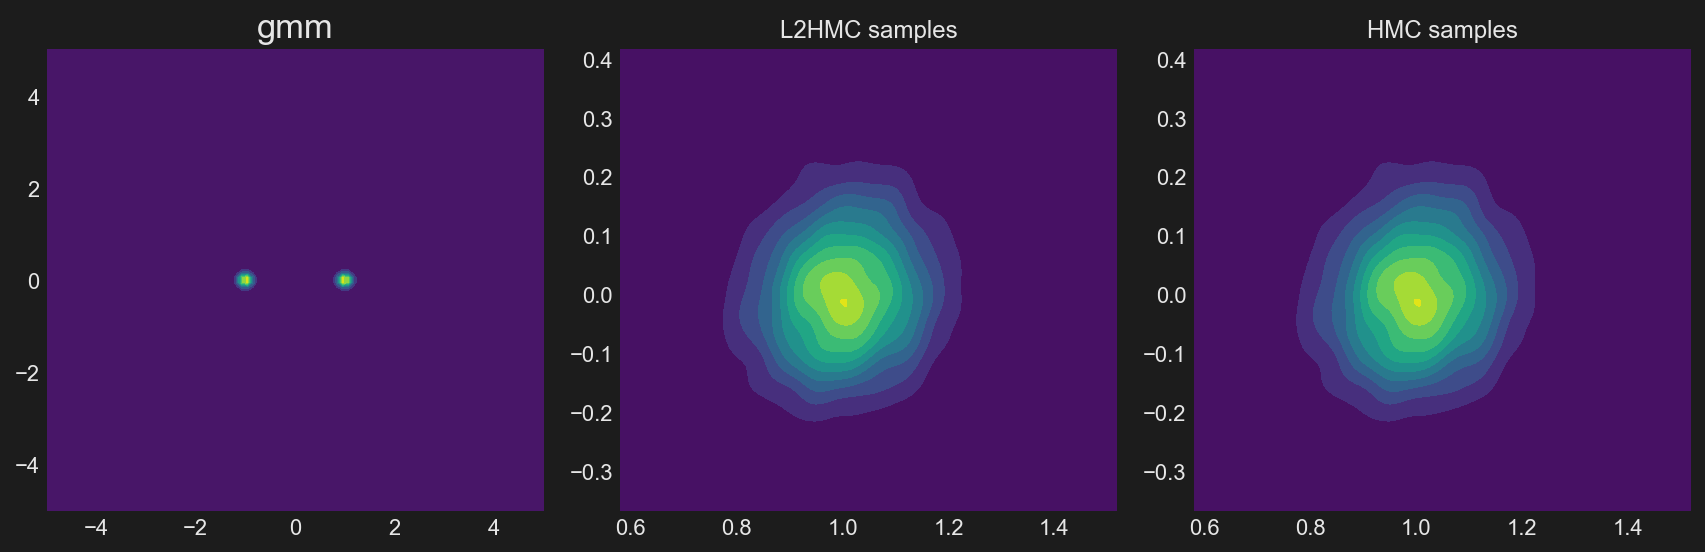

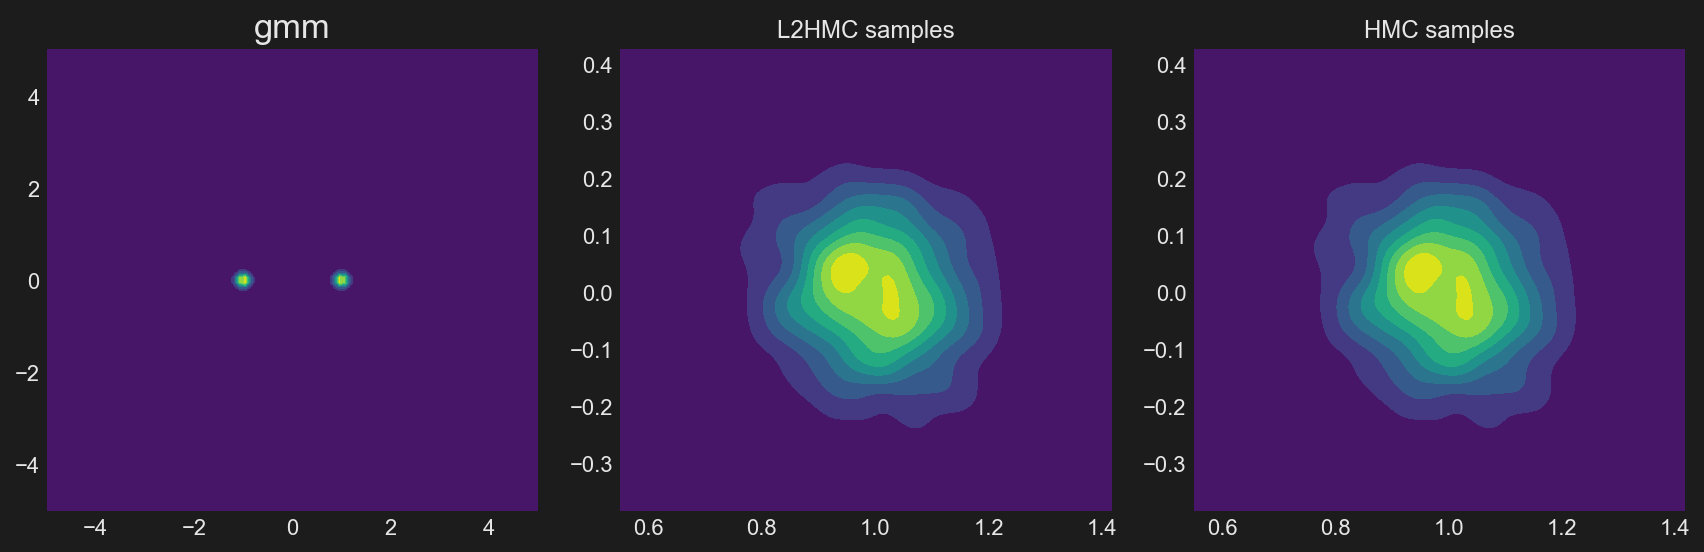

In [30]:
plot_density_estimation(dynamics.potential_fn, x_arr, x_arr,
                        num_plots=2, title=MODEL_TYPE, cmap='viridis')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

Text(0.5, 1.0, 'L2HMC samples')

Text(0.5, 1.0, 'HMC samples')

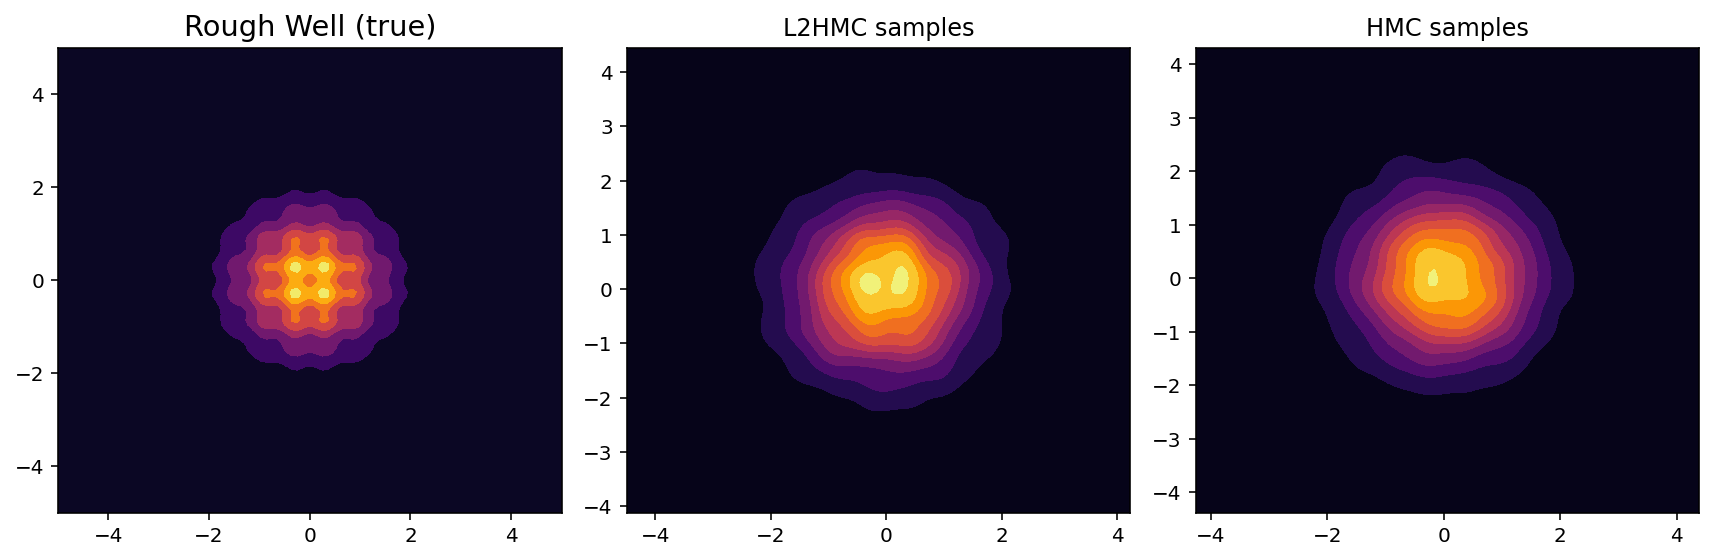

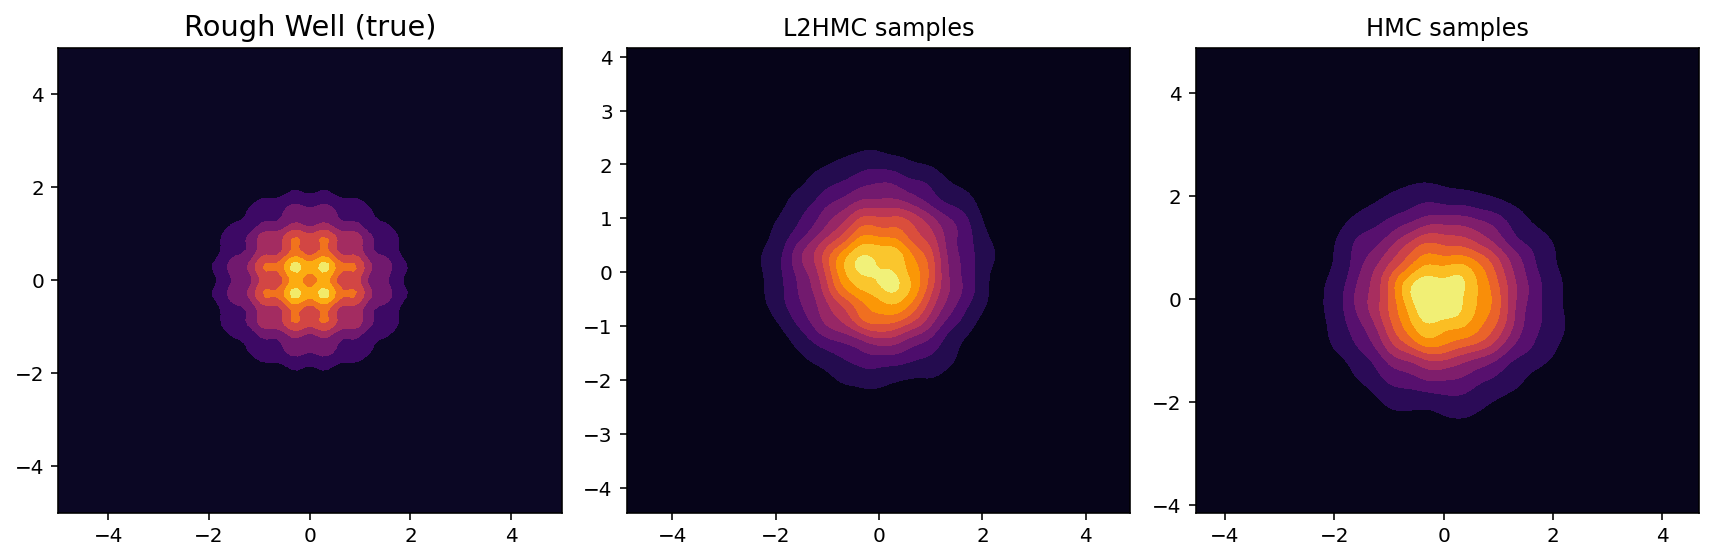

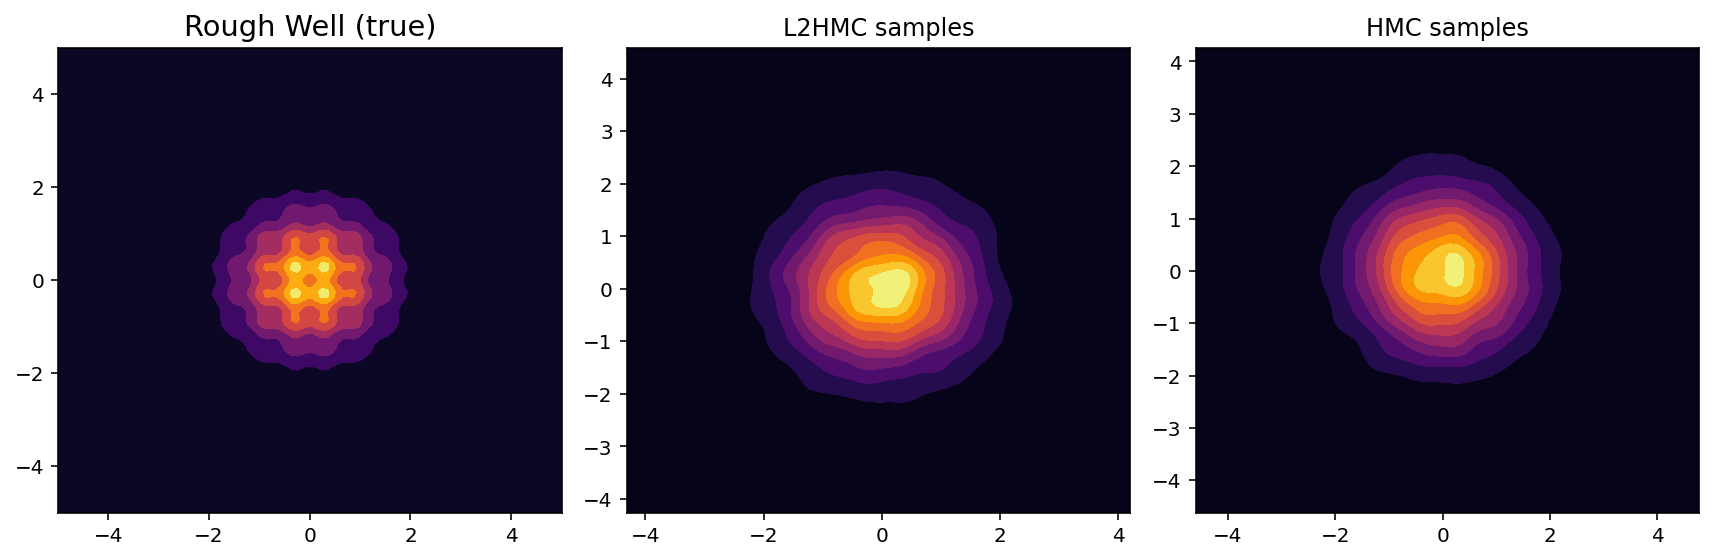

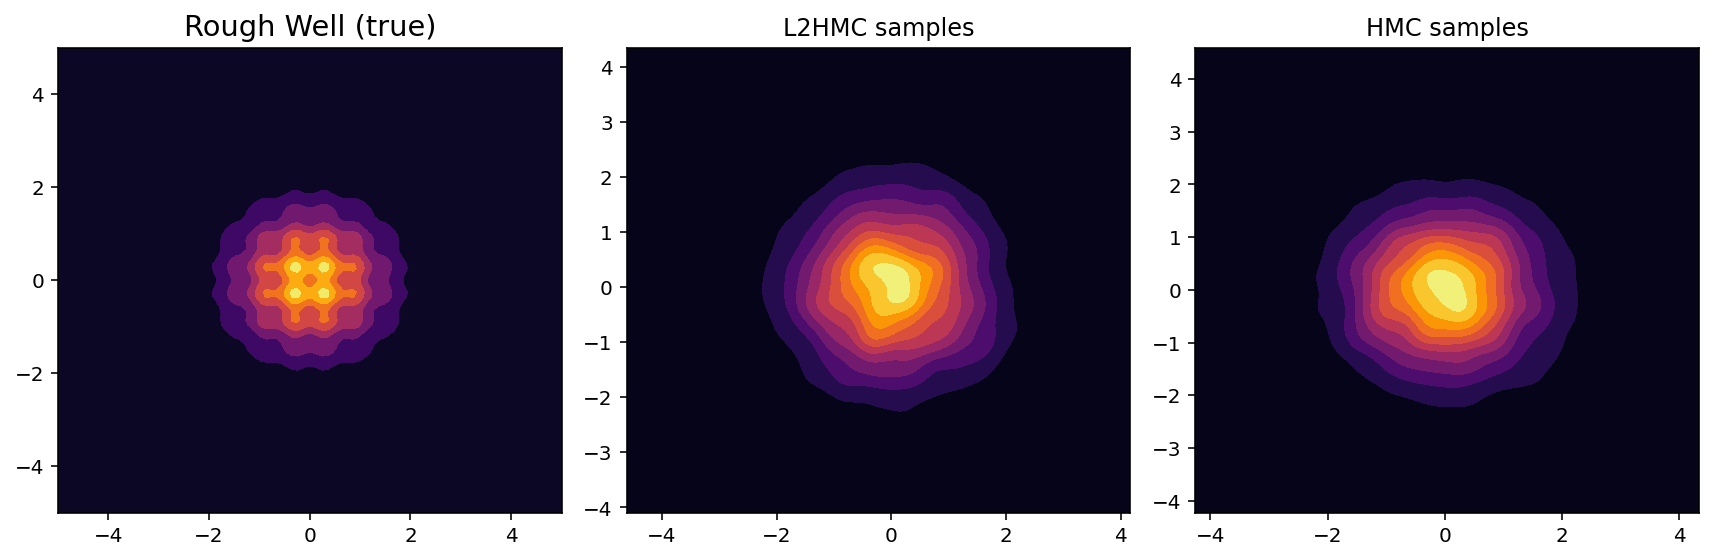

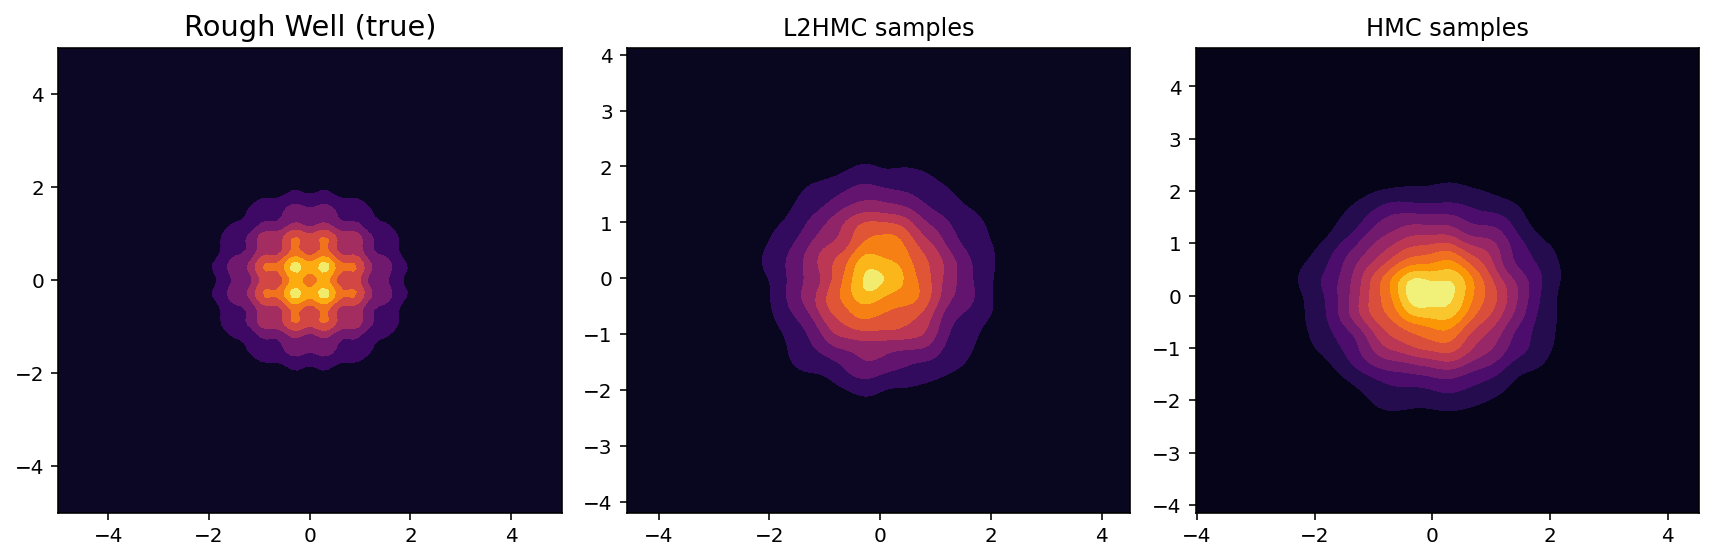

In [77]:
from utils.distributions import contour_potential
xl2hmc = np.array(x_arr)
xhmc = np.array(x_arr_hmc)

for idx in range(5):
    fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
    _ = contour_potential(POTENTIAL_FN, title='Rough Well (true)', ax=axes[0])
    _ = sns.kdeplot(xl2hmc[:, idx, 0], xl2hmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[1])
    _ = sns.kdeplot(xhmc[:, idx, 0], xhmc[:, idx, 1],
                    shade=True, cmap='inferno', ax=axes[2])
    _ = axes[1].set_title('L2HMC samples')
    _ = axes[2].set_title('HMC samples')
    plt.tight_layout()